In [25]:
import os 
import shutil
from ultralytics import YOLO
import torch
import supervision as sv
from tqdm import tqdm

## Prepare PATHS

In [2]:
NOTEBOOKS_PATH = os.getcwd()
print(f"Notebook path: {NOTEBOOKS_PATH}")

PROJECT_PATH = os.path.dirname(NOTEBOOKS_PATH)
print(f"Project path: {PROJECT_PATH}")

DATA_PATH = os.path.join(PROJECT_PATH, 'data')
MODELS_PATH = os.path.join(PROJECT_PATH, 'models')
print(f"Data Path: {DATA_PATH}")
print(f"Models Path: {MODELS_PATH}")

dataset_dir_name = 'football-players-detection-dataset'
DATASET_PATH = os.path.join(DATA_PATH, dataset_dir_name)
print(f"Dataset Path: {DATASET_PATH}")

DATA_YAML_PATH = os.path.join(DATASET_PATH, 'data.yaml')
print(f"YAML file path: {DATA_YAML_PATH}")

TRAIN_IMGS_PATH = os.path.join(DATASET_PATH, 'train/images')
TRAIN_LBLS_PATH = os.path.join(DATASET_PATH, 'train/labels')

VALID_IMGS_PATH = os.path.join(DATASET_PATH, 'valid/images')
VALID_LBLS_PATH = os.path.join(DATASET_PATH, 'valid/labels')

TEST_IMGS_PATH = os.path.join(DATASET_PATH, 'test/images')
TEST_LBLS_PATH = os.path.join(DATASET_PATH, 'test/labels')

print(f"Train images path: {TRAIN_IMGS_PATH}")
print(f"Train labels path: {TRAIN_LBLS_PATH}")
print(f"Valid images path: {VALID_IMGS_PATH}")
print(f"Valid labels path: {VALID_LBLS_PATH}")
print(f"Test images path: {TEST_IMGS_PATH}")
print(f"Test labels path: {TEST_LBLS_PATH}")

MODEL_PATH = os.path.join(MODELS_PATH, 'train5/weights/best.pt')
print(f"Model path: {MODEL_PATH}")

Notebook path: /home/gomaa/Ai/projects/Football-Match-Analysis/notebooks
Project path: /home/gomaa/Ai/projects/Football-Match-Analysis
Data Path: /home/gomaa/Ai/projects/Football-Match-Analysis/data
Models Path: /home/gomaa/Ai/projects/Football-Match-Analysis/models
Dataset Path: /home/gomaa/Ai/projects/Football-Match-Analysis/data/football-players-detection-dataset
YAML file path: /home/gomaa/Ai/projects/Football-Match-Analysis/data/football-players-detection-dataset/data.yaml
Train images path: /home/gomaa/Ai/projects/Football-Match-Analysis/data/football-players-detection-dataset/train/images
Train labels path: /home/gomaa/Ai/projects/Football-Match-Analysis/data/football-players-detection-dataset/train/labels
Valid images path: /home/gomaa/Ai/projects/Football-Match-Analysis/data/football-players-detection-dataset/valid/images
Valid labels path: /home/gomaa/Ai/projects/Football-Match-Analysis/data/football-players-detection-dataset/valid/labels
Test images path: /home/gomaa/Ai/proj

In [3]:
VIDEOS_PATH = os.path.join(DATA_PATH, 'videos')
print(f"Videos path: {VIDEOS_PATH}")
os.listdir(VIDEOS_PATH)

Videos path: /home/gomaa/Ai/projects/Football-Match-Analysis/data/videos


['0a2d9b_4.mp4',
 '08fd33_5.mp4',
 'vid1.mp4',
 '08fd33_2.mp4',
 '0a2d9b_7.mp4',
 '08fd33_1.mp4',
 '08fd33_0.mp4']

In [4]:
print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

CUDA available: True
GPU count: 1
Device: NVIDIA GeForce RTX 2050


## Load the Model

In [5]:
model = YOLO(MODEL_PATH)

## Test Model on a single frame

In [6]:
VIDEO_NAME = 'vid1.mp4' 
SOURCE_VIDEO_PATH = os.path.join(VIDEOS_PATH, VIDEO_NAME)
print(f"Source Video: {SOURCE_VIDEO_PATH}")

Source Video: /home/gomaa/Ai/projects/Football-Match-Analysis/data/videos/vid1.mp4



0: 576x1024 1 goalkeeper, 22 players, 3 referees, 81.5ms
Speed: 3.6ms preprocess, 81.5ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


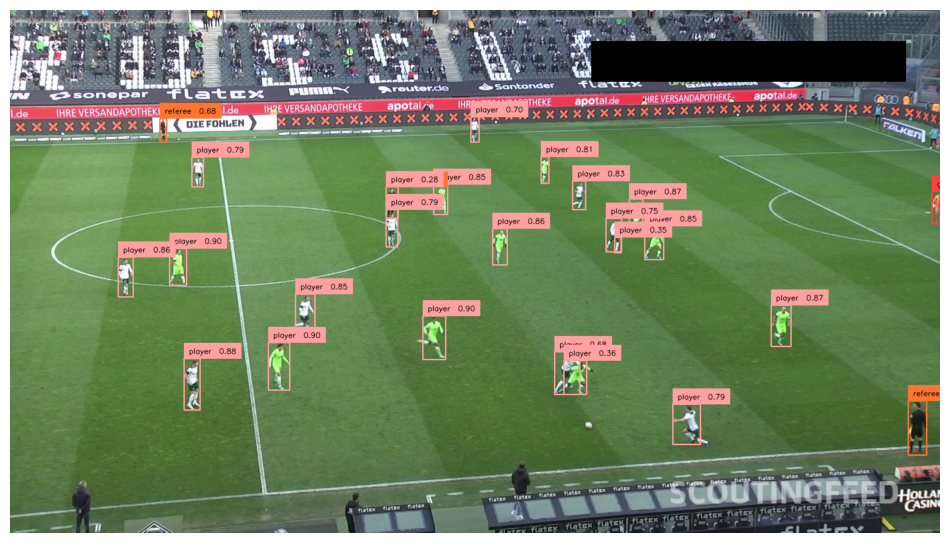

In [19]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.from_hex("#000000"))


frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = model.predict(frame, conf=0.25)[0]

# boxes = result.boxes.xyxy.cpu().numpy()
# confidences = result.boxes.conf.cpu().numpy()
# classes_ids = result.boxes.cls.cpu().numpy().astype(int)
# class_names = result.names

# class_labels = [class_names[i] for i in classes_ids]

# labels = [
#     f"{class_names[class_id]}  {conf:.2f}"
#     for class_id, conf in zip(classes_ids,confidences)
# ]

# detections = sv.Detections(
#     xyxy=boxes,
#     confidence=confidences,
#     class_id=classes_ids,
# )

detections = sv.Detections.from_ultralytics(result)
labels = [
    f"{class_name}  {conf:.2f}"
    for class_name, conf in zip(detections["class_name"],detections.confidence)
]

frame = box_annotator.annotate(scene=frame, detections=detections)
frame = label_annotator.annotate(scene=frame, detections=detections, labels=labels)

sv.plot_image(frame)

## Test Model on a Video

In [21]:
RESULT_VIDEO_PATH = os.path.join(DATA_PATH, 'results-videos')
print(f"Result videos path: {RESULT_VIDEO_PATH}")

Result videos path: /home/gomaa/Ai/projects/Football-Match-Analysis/data/results-videos


In [22]:
TARGET_VIDEO_PATH = os.path.join(RESULT_VIDEO_PATH, 'vid1_res.mp4')
print(f"Target video path: {TARGET_VIDEO_PATH}")

Target video path: /home/gomaa/Ai/projects/Football-Match-Analysis/data/results-videos/vid1_res.mp4


In [ ]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.from_hex("#000000"))


video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = model.predict(frame, conf=0.25)[0]

        detections = sv.Detections.from_ultralytics(result)
        labels = [
            f"{class_name}  {conf:.2f}"
            for class_name, conf in zip(detections["class_name"],detections.confidence)
        ]

        annotated_frame = frame.copy()
        annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

        video_sink.write_frame(frame=annotated_frame)



In [ ]:
TARGET_VIDEO_PATH = os.path.join(RESULT_VIDEO_PATH, 'vid1_res2.mp4')
# box_annotator = sv.BoxAnnotator()
# label_annotator = sv.LabelAnnotator(text_color=sv.Color.from_hex("#000000"))

BALL_ID = 0
ellipse_annot = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF','#FF1493','#FFE876']),
    thickness=2
)
triangle_annot = sv.TriangleAnnotator(
    color= sv.Color.from_hex('#9E5700'),
    base=20, height=17
)

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = model.predict(frame, conf=0.25)[0]

        detections = sv.Detections.from_ultralytics(result)

        ball_detections = detections[detections.class_id==BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        other_detections = detections[detections.class_id!=BALL_ID]

        other_detections = other_detections.with_nms(threshold=0.5, class_agnostic=True)
        other_detections.class_id = other_detections.class_id - 1

        annotated_frame = frame.copy()
        annotated_frame = ellipse_annot.annotate(scene=annotated_frame, detections=other_detections)
        annotated_frame = triangle_annot.annotate(scene=annotated_frame, detections=ball_detections)

        video_sink.write_frame(frame=annotated_frame)



  0%|          | 0/750 [00:00<?, ?it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 81.5ms
Speed: 20.1ms preprocess, 81.5ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


  0%|          | 1/750 [00:00<02:06,  5.92it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 80.8ms
Speed: 2.9ms preprocess, 80.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


  0%|          | 2/750 [00:00<01:38,  7.57it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 80.9ms
Speed: 4.3ms preprocess, 80.9ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


  0%|          | 3/750 [00:00<01:29,  8.31it/s]


0: 576x1024 1 goalkeeper, 20 players, 2 referees, 75.7ms
Speed: 4.1ms preprocess, 75.7ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 goalkeeper, 22 players, 2 referees, 75.9ms
Speed: 3.4ms preprocess, 75.9ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


  1%|          | 5/750 [00:00<01:21,  9.18it/s]


0: 576x1024 1 goalkeeper, 22 players, 2 referees, 76.2ms
Speed: 3.0ms preprocess, 76.2ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 goalkeeper, 23 players, 2 referees, 76.1ms
Speed: 2.8ms preprocess, 76.1ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


  1%|          | 7/750 [00:00<01:17,  9.55it/s]


0: 576x1024 1 goalkeeper, 22 players, 2 referees, 76.6ms
Speed: 2.9ms preprocess, 76.6ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


  1%|          | 8/750 [00:00<01:16,  9.65it/s]


0: 576x1024 1 goalkeeper, 21 players, 2 referees, 76.3ms
Speed: 3.0ms preprocess, 76.3ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 1 goalkeeper, 24 players, 2 referees, 76.1ms
Speed: 2.9ms preprocess, 76.1ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


  1%|▏         | 10/750 [00:01<01:15,  9.85it/s]


0: 576x1024 1 goalkeeper, 24 players, 2 referees, 76.1ms
Speed: 3.0ms preprocess, 76.1ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 goalkeeper, 24 players, 2 referees, 76.2ms
Speed: 2.8ms preprocess, 76.2ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


  2%|▏         | 12/750 [00:01<01:14,  9.93it/s]


0: 576x1024 1 goalkeeper, 25 players, 2 referees, 76.5ms
Speed: 2.8ms preprocess, 76.5ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


  2%|▏         | 13/750 [00:01<01:14,  9.88it/s]


0: 576x1024 1 goalkeeper, 23 players, 2 referees, 76.0ms
Speed: 2.8ms preprocess, 76.0ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 76.1ms
Speed: 2.7ms preprocess, 76.1ms inference, 4.5ms postprocess per image at shape (1, 3, 576, 1024)


  2%|▏         | 15/750 [00:01<01:13,  9.99it/s]


0: 576x1024 20 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 21 players, 3 referees, 76.2ms
Speed: 3.0ms preprocess, 76.2ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


  2%|▏         | 17/750 [00:01<01:13, 10.04it/s]


0: 576x1024 21 players, 3 referees, 75.6ms
Speed: 2.9ms preprocess, 75.6ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


  2%|▏         | 18/750 [00:01<01:13,  9.97it/s]


0: 576x1024 21 players, 3 referees, 76.4ms
Speed: 3.2ms preprocess, 76.4ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


  3%|▎         | 19/750 [00:01<01:13,  9.93it/s]


0: 576x1024 23 players, 3 referees, 76.1ms
Speed: 2.9ms preprocess, 76.1ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 76.1ms
Speed: 3.1ms preprocess, 76.1ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


  3%|▎         | 21/750 [00:02<01:12,  9.99it/s]


0: 576x1024 20 players, 5 referees, 75.8ms
Speed: 3.2ms preprocess, 75.8ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 4 referees, 76.3ms
Speed: 3.0ms preprocess, 76.3ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


  3%|▎         | 23/750 [00:02<01:12, 10.06it/s]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 23 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


  3%|▎         | 25/750 [00:02<01:12, 10.04it/s]


0: 576x1024 22 players, 3 referees, 76.2ms
Speed: 4.0ms preprocess, 76.2ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


  4%|▎         | 27/750 [00:02<01:11, 10.06it/s]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


  4%|▍         | 29/750 [00:02<01:11, 10.10it/s]


0: 576x1024 20 players, 4 referees, 75.8ms
Speed: 3.6ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


  4%|▍         | 31/750 [00:03<01:11, 10.11it/s]


0: 576x1024 22 players, 3 referees, 76.4ms
Speed: 2.9ms preprocess, 76.4ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 21 players, 3 referees, 76.2ms
Speed: 4.2ms preprocess, 76.2ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


  4%|▍         | 33/750 [00:03<01:11, 10.07it/s]


0: 576x1024 21 players, 3 referees, 76.7ms
Speed: 3.2ms preprocess, 76.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 75.7ms
Speed: 3.5ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


  5%|▍         | 35/750 [00:03<01:11,  9.98it/s]


0: 576x1024 20 players, 3 referees, 75.9ms
Speed: 3.8ms preprocess, 75.9ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


  5%|▍         | 36/750 [00:03<01:11,  9.93it/s]


0: 576x1024 20 players, 3 referees, 75.7ms
Speed: 3.6ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


  5%|▍         | 37/750 [00:03<01:11,  9.91it/s]


0: 576x1024 20 players, 3 referees, 75.9ms
Speed: 2.7ms preprocess, 75.9ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 20 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 7.0ms postprocess per image at shape (1, 3, 576, 1024)


  5%|▌         | 39/750 [00:03<01:12,  9.87it/s]


0: 576x1024 20 players, 3 referees, 76.3ms
Speed: 4.2ms preprocess, 76.3ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


  5%|▌         | 40/750 [00:04<01:11,  9.87it/s]


0: 576x1024 21 players, 3 referees, 75.7ms
Speed: 4.4ms preprocess, 75.7ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


  5%|▌         | 41/750 [00:04<01:12,  9.81it/s]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 3.1ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


  6%|▌         | 42/750 [00:04<01:12,  9.81it/s]


0: 576x1024 24 players, 2 referees, 75.6ms
Speed: 3.2ms preprocess, 75.6ms inference, 5.9ms postprocess per image at shape (1, 3, 576, 1024)


  6%|▌         | 43/750 [00:04<01:11,  9.82it/s]


0: 576x1024 22 players, 3 referees, 75.6ms
Speed: 3.4ms preprocess, 75.6ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


  6%|▌         | 44/750 [00:04<01:11,  9.85it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.6ms
Speed: 2.8ms preprocess, 75.6ms inference, 6.3ms postprocess per image at shape (1, 3, 576, 1024)


  6%|▌         | 45/750 [00:04<01:12,  9.78it/s]


0: 576x1024 21 players, 3 referees, 76.2ms
Speed: 2.9ms preprocess, 76.2ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


  6%|▌         | 46/750 [00:04<01:11,  9.82it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 76.2ms
Speed: 3.0ms preprocess, 76.2ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


  6%|▋         | 47/750 [00:04<01:12,  9.74it/s]


0: 576x1024 21 players, 3 referees, 75.7ms
Speed: 3.8ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


  6%|▋         | 48/750 [00:04<01:12,  9.73it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


  7%|▋         | 49/750 [00:05<01:11,  9.78it/s]


0: 576x1024 21 players, 5 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 5.9ms postprocess per image at shape (1, 3, 576, 1024)


  7%|▋         | 50/750 [00:05<01:11,  9.83it/s]


0: 576x1024 22 players, 5 referees, 75.7ms
Speed: 2.7ms preprocess, 75.7ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


  7%|▋         | 51/750 [00:05<01:11,  9.78it/s]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 3.6ms preprocess, 75.8ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


  7%|▋         | 52/750 [00:05<01:11,  9.77it/s]


0: 576x1024 20 players, 2 referees, 76.3ms
Speed: 2.9ms preprocess, 76.3ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 2 referees, 76.2ms
Speed: 3.0ms preprocess, 76.2ms inference, 4.4ms postprocess per image at shape (1, 3, 576, 1024)


  7%|▋         | 54/750 [00:05<01:10,  9.88it/s]


0: 576x1024 24 players, 3 referees, 75.7ms
Speed: 2.7ms preprocess, 75.7ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 4 referees, 76.0ms
Speed: 3.0ms preprocess, 76.0ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


  7%|▋         | 56/750 [00:05<01:09,  9.93it/s]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


  8%|▊         | 57/750 [00:05<01:09,  9.91it/s]


0: 576x1024 20 players, 2 referees, 76.2ms
Speed: 3.4ms preprocess, 76.2ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


  8%|▊         | 58/750 [00:05<01:09,  9.91it/s]


0: 576x1024 20 players, 2 referees, 76.2ms
Speed: 3.1ms preprocess, 76.2ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


  8%|▊         | 59/750 [00:06<01:09,  9.91it/s]


0: 576x1024 23 players, 3 referees, 76.3ms
Speed: 4.5ms preprocess, 76.3ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


  8%|▊         | 60/750 [00:06<01:10,  9.83it/s]


0: 576x1024 20 players, 3 referees, 76.2ms
Speed: 3.2ms preprocess, 76.2ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


  8%|▊         | 61/750 [00:06<01:10,  9.80it/s]


0: 576x1024 22 players, 4 referees, 75.9ms
Speed: 3.6ms preprocess, 75.9ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


  8%|▊         | 62/750 [00:06<01:10,  9.82it/s]


0: 576x1024 23 players, 2 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


  8%|▊         | 63/750 [00:06<01:09,  9.85it/s]


0: 576x1024 20 players, 3 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▊         | 64/750 [00:06<01:09,  9.87it/s]


0: 576x1024 21 players, 2 referees, 76.1ms
Speed: 2.8ms preprocess, 76.1ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▊         | 65/750 [00:06<01:09,  9.89it/s]


0: 576x1024 21 players, 1 referee, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▉         | 66/750 [00:06<01:09,  9.90it/s]


0: 576x1024 21 players, 1 referee, 76.2ms
Speed: 2.9ms preprocess, 76.2ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 21 players, 1 referee, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▉         | 68/750 [00:06<01:08,  9.98it/s]


0: 576x1024 23 players, 1 referee, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▉         | 69/750 [00:07<01:08,  9.98it/s]


0: 576x1024 24 players, 2 referees, 75.8ms
Speed: 3.2ms preprocess, 75.8ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▉         | 70/750 [00:07<01:08,  9.93it/s]


0: 576x1024 24 players, 2 referees, 76.1ms
Speed: 3.0ms preprocess, 76.1ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▉         | 71/750 [00:07<01:08,  9.91it/s]


0: 576x1024 22 players, 2 referees, 75.8ms
Speed: 3.1ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 10%|▉         | 72/750 [00:07<01:08,  9.90it/s]


0: 576x1024 22 players, 2 referees, 76.2ms
Speed: 4.4ms preprocess, 76.2ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 10%|▉         | 73/750 [00:07<01:08,  9.86it/s]


0: 576x1024 20 players, 2 referees, 76.1ms
Speed: 3.1ms preprocess, 76.1ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 24 players, 3 referees, 76.2ms
Speed: 3.9ms preprocess, 76.2ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 10%|█         | 75/750 [00:07<01:08,  9.92it/s]


0: 576x1024 25 players, 2 referees, 76.1ms
Speed: 2.8ms preprocess, 76.1ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 23 players, 2 referees, 76.2ms
Speed: 3.8ms preprocess, 76.2ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 10%|█         | 77/750 [00:07<01:07,  9.95it/s]


0: 576x1024 1 ball, 24 players, 2 referees, 76.4ms
Speed: 3.2ms preprocess, 76.4ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 10%|█         | 78/750 [00:07<01:07,  9.92it/s]


0: 576x1024 1 ball, 23 players, 2 referees, 76.3ms
Speed: 3.0ms preprocess, 76.3ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 11%|█         | 79/750 [00:08<01:07,  9.91it/s]


0: 576x1024 1 ball, 22 players, 2 referees, 76.0ms
Speed: 3.0ms preprocess, 76.0ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 11%|█         | 80/750 [00:08<01:07,  9.89it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 11%|█         | 81/750 [00:08<01:07,  9.89it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 11%|█         | 82/750 [00:08<01:07,  9.90it/s]


0: 576x1024 20 players, 2 referees, 76.0ms
Speed: 3.7ms preprocess, 76.0ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 11%|█         | 83/750 [00:08<01:07,  9.87it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 11%|█         | 84/750 [00:08<01:07,  9.88it/s]


0: 576x1024 22 players, 2 referees, 76.0ms
Speed: 3.0ms preprocess, 76.0ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 11%|█▏        | 85/750 [00:08<01:07,  9.91it/s]


0: 576x1024 1 ball, 22 players, 2 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 11%|█▏        | 86/750 [00:08<01:06,  9.92it/s]


0: 576x1024 1 ball, 22 players, 2 referees, 76.1ms
Speed: 3.0ms preprocess, 76.1ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 12%|█▏        | 87/750 [00:08<01:06,  9.92it/s]


0: 576x1024 1 ball, 23 players, 2 referees, 76.0ms
Speed: 2.7ms preprocess, 76.0ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 12%|█▏        | 88/750 [00:08<01:07,  9.82it/s]


0: 576x1024 2 balls, 23 players, 3 referees, 76.2ms
Speed: 5.0ms preprocess, 76.2ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 12%|█▏        | 89/750 [00:09<01:07,  9.74it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 12%|█▏        | 90/750 [00:09<01:07,  9.76it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 75.9ms
Speed: 4.3ms preprocess, 75.9ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 12%|█▏        | 91/750 [00:09<01:07,  9.77it/s]


0: 576x1024 20 players, 2 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 12%|█▏        | 92/750 [00:09<01:06,  9.83it/s]


0: 576x1024 1 ball, 20 players, 1 referee, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 12%|█▏        | 93/750 [00:09<01:06,  9.87it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 1 referee, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 13%|█▎        | 95/750 [00:09<01:05,  9.96it/s]


0: 576x1024 22 players, 1 referee, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 13%|█▎        | 96/750 [00:09<01:05,  9.95it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 21 players, 2 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 13%|█▎        | 98/750 [00:09<01:05,  9.96it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 75.8ms
Speed: 3.6ms preprocess, 75.8ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 13%|█▎        | 99/750 [00:10<01:05,  9.88it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 76.2ms
Speed: 4.1ms preprocess, 76.2ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 13%|█▎        | 100/750 [00:10<01:06,  9.84it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 20 players, 2 referees, 76.2ms
Speed: 3.0ms preprocess, 76.2ms inference, 4.4ms postprocess per image at shape (1, 3, 576, 1024)


 14%|█▎        | 102/750 [00:10<01:05,  9.91it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 76.2ms
Speed: 2.8ms preprocess, 76.2ms inference, 4.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 20 players, 2 referees, 76.2ms
Speed: 2.7ms preprocess, 76.2ms inference, 4.4ms postprocess per image at shape (1, 3, 576, 1024)


 14%|█▍        | 104/750 [00:10<01:04,  9.98it/s]


0: 576x1024 1 ball, 20 players, 1 referee, 76.2ms
Speed: 4.4ms preprocess, 76.2ms inference, 4.3ms postprocess per image at shape (1, 3, 576, 1024)


 14%|█▍        | 105/750 [00:10<01:04,  9.94it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 76.1ms
Speed: 2.7ms preprocess, 76.1ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 14%|█▍        | 106/750 [00:10<01:05,  9.89it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 76.1ms
Speed: 2.7ms preprocess, 76.1ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 20 players, 2 referees, 76.2ms
Speed: 3.0ms preprocess, 76.2ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 14%|█▍        | 108/750 [00:10<01:04,  9.93it/s]


0: 576x1024 2 balls, 20 players, 2 referees, 76.3ms
Speed: 3.0ms preprocess, 76.3ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 15%|█▍        | 109/750 [00:11<01:04,  9.94it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 76.2ms
Speed: 3.3ms preprocess, 76.2ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 15%|█▍        | 110/750 [00:11<01:04,  9.93it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 76.2ms
Speed: 2.9ms preprocess, 76.2ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 15%|█▍        | 111/750 [00:11<01:04,  9.95it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 76.1ms
Speed: 2.9ms preprocess, 76.1ms inference, 4.5ms postprocess per image at shape (1, 3, 576, 1024)


 15%|█▍        | 112/750 [00:11<01:04,  9.96it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 75.8ms
Speed: 3.6ms preprocess, 75.8ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 15%|█▌        | 113/750 [00:11<01:04,  9.91it/s]


0: 576x1024 20 players, 2 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 15%|█▌        | 114/750 [00:11<01:04,  9.93it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 75.3ms
Speed: 3.6ms preprocess, 75.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 15%|█▌        | 115/750 [00:11<01:04,  9.91it/s]


0: 576x1024 20 players, 2 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 20 players, 2 referees, 75.2ms
Speed: 3.1ms preprocess, 75.2ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 16%|█▌        | 117/750 [00:11<01:03,  9.98it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 75.2ms
Speed: 2.8ms preprocess, 75.2ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 2 referees, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 16%|█▌        | 119/750 [00:12<01:02, 10.05it/s]


0: 576x1024 21 players, 2 referees, 75.6ms
Speed: 3.2ms preprocess, 75.6ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 16%|█▌        | 121/750 [00:12<01:02, 10.02it/s]


0: 576x1024 1 goalkeeper, 21 players, 2 referees, 75.4ms
Speed: 3.1ms preprocess, 75.4ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 goalkeeper, 22 players, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 16%|█▋        | 123/750 [00:12<01:02, 10.02it/s]


0: 576x1024 1 goalkeeper, 20 players, 2 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 goalkeeper, 21 players, 2 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 17%|█▋        | 125/750 [00:12<01:02,  9.97it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 2 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 17%|█▋        | 126/750 [00:12<01:02,  9.94it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 2 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 17%|█▋        | 127/750 [00:12<01:02,  9.94it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 1 referee, 75.4ms
Speed: 3.1ms preprocess, 75.4ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 17%|█▋        | 128/750 [00:12<01:02,  9.92it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 1 referee, 75.5ms
Speed: 2.7ms preprocess, 75.5ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 17%|█▋        | 129/750 [00:13<01:03,  9.86it/s]


0: 576x1024 22 players, 1 referee, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 17%|█▋        | 130/750 [00:13<01:03,  9.84it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 17%|█▋        | 131/750 [00:13<01:02,  9.87it/s]


0: 576x1024 22 players, 1 referee, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 18%|█▊        | 132/750 [00:13<01:02,  9.87it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 18%|█▊        | 133/750 [00:13<01:02,  9.86it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 75.4ms
Speed: 3.2ms preprocess, 75.4ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 2 referees, 75.8ms
Speed: 3.2ms preprocess, 75.8ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 18%|█▊        | 135/750 [00:13<01:01,  9.93it/s]


0: 576x1024 1 ball, 22 players, 2 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 21 players, 2 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 4.5ms postprocess per image at shape (1, 3, 576, 1024)


 18%|█▊        | 137/750 [00:13<01:01,  9.99it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 6.0ms postprocess per image at shape (1, 3, 576, 1024)


 18%|█▊        | 138/750 [00:13<01:01,  9.95it/s]


0: 576x1024 24 players, 2 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 19%|█▊        | 139/750 [00:14<01:01,  9.95it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 1 referee, 75.6ms
Speed: 3.4ms preprocess, 75.6ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 19%|█▊        | 140/750 [00:14<01:01,  9.94it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 1 referee, 75.4ms
Speed: 3.2ms preprocess, 75.4ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 19%|█▉        | 141/750 [00:14<01:01,  9.89it/s]


0: 576x1024 1 ball, 1 goalkeeper, 23 players, 1 referee, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 11.2ms postprocess per image at shape (1, 3, 576, 1024)


 19%|█▉        | 142/750 [00:14<01:03,  9.64it/s]


0: 576x1024 1 ball, 22 players, 1 referee, 75.8ms
Speed: 3.4ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 19%|█▉        | 143/750 [00:14<01:02,  9.70it/s]


0: 576x1024 1 ball, 21 players, 1 referee, 75.9ms
Speed: 3.3ms preprocess, 75.9ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 19%|█▉        | 144/750 [00:14<01:02,  9.75it/s]


0: 576x1024 21 players, 1 referee, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 19%|█▉        | 145/750 [00:14<01:01,  9.79it/s]


0: 576x1024 1 ball, 21 players, 1 referee, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 24 players, 75.6ms
Speed: 3.0ms preprocess, 75.6ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 20%|█▉        | 147/750 [00:14<01:00,  9.90it/s]


0: 576x1024 22 players, 1 referee, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 1 referee, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 20%|█▉        | 149/750 [00:15<01:00,  9.97it/s]


0: 576x1024 1 ball, 22 players, 1 referee, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 20%|██        | 150/750 [00:15<01:00,  9.97it/s]


0: 576x1024 1 ball, 22 players, 1 referee, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 20%|██        | 151/750 [00:15<01:00,  9.96it/s]


0: 576x1024 23 players, 2 referees, 75.4ms
Speed: 3.1ms preprocess, 75.4ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 23 players, 1 referee, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 20%|██        | 153/750 [00:15<00:59,  9.97it/s]


0: 576x1024 1 ball, 22 players, 2 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██        | 154/750 [00:15<00:59,  9.97it/s]


0: 576x1024 1 ball, 21 players, 1 referee, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 21 players, 1 referee, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██        | 156/750 [00:15<00:59,  9.99it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██        | 157/750 [00:15<00:59,  9.98it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 21 players, 2 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██        | 159/750 [00:16<00:59, 10.01it/s]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██▏       | 160/750 [00:16<00:59,  9.97it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██▏       | 161/750 [00:16<00:59,  9.84it/s]


0: 576x1024 1 ball, 22 players, 1 referee, 75.8ms
Speed: 9.3ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 22%|██▏       | 162/750 [00:16<01:00,  9.68it/s]


0: 576x1024 21 players, 2 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 22%|██▏       | 163/750 [00:16<01:00,  9.75it/s]


0: 576x1024 21 players, 3 referees, 75.7ms
Speed: 2.7ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 3.6ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 22%|██▏       | 165/750 [00:16<00:59,  9.84it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 22%|██▏       | 167/750 [00:16<00:58,  9.89it/s]


0: 576x1024 21 players, 3 referees, 75.2ms
Speed: 4.6ms preprocess, 75.2ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 22%|██▏       | 168/750 [00:17<00:58,  9.87it/s]


0: 576x1024 1 ball, 22 players, 1 referee, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 23%|██▎       | 169/750 [00:17<00:58,  9.89it/s]


0: 576x1024 1 ball, 22 players, 1 referee, 75.2ms
Speed: 3.7ms preprocess, 75.2ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 23%|██▎       | 170/750 [00:17<00:58,  9.89it/s]


0: 576x1024 1 ball, 21 players, 1 referee, 75.2ms
Speed: 3.2ms preprocess, 75.2ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 23%|██▎       | 171/750 [00:17<00:58,  9.85it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 23%|██▎       | 173/750 [00:17<00:58,  9.94it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 3.4ms preprocess, 75.3ms inference, 12.2ms postprocess per image at shape (1, 3, 576, 1024)


 23%|██▎       | 174/750 [00:17<00:59,  9.73it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.8ms
Speed: 3.8ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 23%|██▎       | 175/750 [00:17<00:58,  9.78it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 3.6ms preprocess, 75.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 24%|██▎       | 177/750 [00:17<00:57,  9.88it/s]


0: 576x1024 21 players, 3 referees, 75.7ms
Speed: 3.5ms preprocess, 75.7ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 24%|██▎       | 178/750 [00:18<00:57,  9.90it/s]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 3.1ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 3.2ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 24%|██▍       | 180/750 [00:18<00:57,  9.95it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 24%|██▍       | 181/750 [00:18<00:57,  9.94it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 24%|██▍       | 183/750 [00:18<00:56, 10.01it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.8ms
Speed: 3.3ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 2 referees, 75.7ms
Speed: 3.5ms preprocess, 75.7ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 25%|██▍       | 185/750 [00:18<00:55, 10.10it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 3 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 25%|██▍       | 187/750 [00:18<00:55, 10.10it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.4ms
Speed: 3.5ms preprocess, 75.4ms inference, 6.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 3.4ms preprocess, 75.8ms inference, 6.2ms postprocess per image at shape (1, 3, 576, 1024)


 25%|██▌       | 189/750 [00:19<00:56,  9.94it/s]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 3.1ms preprocess, 75.8ms inference, 6.8ms postprocess per image at shape (1, 3, 576, 1024)


 25%|██▌       | 191/750 [00:19<00:56,  9.96it/s]


0: 576x1024 20 players, 3 referees, 75.4ms
Speed: 4.4ms preprocess, 75.4ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 26%|██▌       | 192/750 [00:19<00:56,  9.95it/s]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 26%|██▌       | 193/750 [00:19<00:55,  9.95it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.8ms
Speed: 3.3ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 3.3ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 26%|██▌       | 195/750 [00:19<00:55, 10.00it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 26%|██▌       | 196/750 [00:19<00:55,  9.99it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 3.2ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 26%|██▋       | 198/750 [00:20<00:55, 10.02it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 76.0ms
Speed: 2.9ms preprocess, 76.0ms inference, 7.5ms postprocess per image at shape (1, 3, 576, 1024)


 27%|██▋       | 200/750 [00:20<00:54, 10.00it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 27%|██▋       | 201/750 [00:20<00:55,  9.98it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 3 referees, 75.9ms
Speed: 4.1ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 27%|██▋       | 203/750 [00:20<00:54, 10.00it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 27%|██▋       | 205/750 [00:20<00:54,  9.99it/s]


0: 576x1024 1 ball, 23 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 4 referees, 75.8ms
Speed: 3.4ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 28%|██▊       | 207/750 [00:20<00:54, 10.03it/s]


0: 576x1024 1 ball, 21 players, 4 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 4 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 6.1ms postprocess per image at shape (1, 3, 576, 1024)


 28%|██▊       | 209/750 [00:21<00:53, 10.08it/s]


0: 576x1024 1 ball, 21 players, 4 referees, 75.8ms
Speed: 4.3ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 4 referees, 75.8ms
Speed: 3.2ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 28%|██▊       | 211/750 [00:21<00:53, 10.07it/s]


0: 576x1024 2 balls, 21 players, 4 referees, 75.6ms
Speed: 2.9ms preprocess, 75.6ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 28%|██▊       | 213/750 [00:21<00:53, 10.12it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.2ms
Speed: 2.7ms preprocess, 75.2ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 3.8ms preprocess, 75.3ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 29%|██▊       | 215/750 [00:21<00:52, 10.12it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 3.2ms preprocess, 75.3ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 29%|██▉       | 217/750 [00:21<00:52, 10.11it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 29%|██▉       | 219/750 [00:22<00:52, 10.10it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.0ms
Speed: 4.7ms preprocess, 75.0ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 29%|██▉       | 221/750 [00:22<00:52, 10.10it/s]


0: 576x1024 22 players, 3 referees, 75.5ms
Speed: 2.9ms preprocess, 75.5ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 21 players, 3 referees, 75.6ms
Speed: 2.9ms preprocess, 75.6ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 30%|██▉       | 223/750 [00:22<00:52, 10.11it/s]


0: 576x1024 20 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 20 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 30%|███       | 225/750 [00:22<00:51, 10.13it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 3.1ms preprocess, 75.3ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 3.2ms preprocess, 75.3ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 30%|███       | 227/750 [00:22<00:51, 10.16it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 3.3ms preprocess, 75.3ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 31%|███       | 229/750 [00:23<00:51, 10.12it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.2ms
Speed: 2.9ms preprocess, 75.2ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 31%|███       | 231/750 [00:23<00:51, 10.11it/s]


0: 576x1024 21 players, 3 referees, 75.4ms
Speed: 3.5ms preprocess, 75.4ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 75.2ms
Speed: 2.9ms preprocess, 75.2ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 31%|███       | 233/750 [00:23<00:51, 10.10it/s]


0: 576x1024 21 players, 4 referees, 75.8ms
Speed: 3.4ms preprocess, 75.8ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 21 players, 4 referees, 75.4ms
Speed: 3.6ms preprocess, 75.4ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 31%|███▏      | 235/750 [00:23<00:51, 10.01it/s]


0: 576x1024 22 players, 3 referees, 75.3ms
Speed: 4.6ms preprocess, 75.3ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 75.3ms
Speed: 3.7ms preprocess, 75.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 32%|███▏      | 237/750 [00:23<00:51,  9.98it/s]


0: 576x1024 21 players, 3 referees, 75.2ms
Speed: 3.3ms preprocess, 75.2ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 21 players, 3 referees, 75.3ms
Speed: 3.5ms preprocess, 75.3ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 32%|███▏      | 239/750 [00:24<00:51, 10.00it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 3.7ms preprocess, 75.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 3.2ms preprocess, 75.3ms inference, 6.0ms postprocess per image at shape (1, 3, 576, 1024)


 32%|███▏      | 241/750 [00:24<00:51,  9.96it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 32%|███▏      | 243/750 [00:24<00:50, 10.01it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 3.3ms preprocess, 75.3ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.5ms
Speed: 2.8ms preprocess, 75.5ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 33%|███▎      | 245/750 [00:24<00:50, 10.02it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.2ms
Speed: 3.8ms preprocess, 75.2ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 33%|███▎      | 247/750 [00:24<00:50, 10.00it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.2ms
Speed: 3.0ms preprocess, 75.2ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 33%|███▎      | 249/750 [00:25<00:49, 10.04it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 3.2ms preprocess, 75.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 24 players, 2 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 33%|███▎      | 251/750 [00:25<00:49, 10.02it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 34%|███▎      | 253/750 [00:25<00:49, 10.02it/s]


0: 576x1024 21 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 21 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 34%|███▍      | 255/750 [00:25<00:49, 10.09it/s]


0: 576x1024 21 players, 3 referees, 76.0ms
Speed: 4.3ms preprocess, 76.0ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 75.7ms
Speed: 3.4ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 34%|███▍      | 257/750 [00:25<00:48, 10.08it/s]


0: 576x1024 20 players, 3 referees, 75.7ms
Speed: 3.7ms preprocess, 75.7ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 23 players, 3 referees, 75.7ms
Speed: 4.1ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 35%|███▍      | 259/750 [00:26<00:48, 10.06it/s]


0: 576x1024 21 players, 3 referees, 75.4ms
Speed: 2.7ms preprocess, 75.4ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 21 players, 3 referees, 75.7ms
Speed: 4.0ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 35%|███▍      | 261/750 [00:26<00:48, 10.07it/s]


0: 576x1024 1 ball, 22 players, 2 referees, 75.4ms
Speed: 4.1ms preprocess, 75.4ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 2 referees, 75.5ms
Speed: 3.0ms preprocess, 75.5ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 35%|███▌      | 263/750 [00:26<00:48, 10.12it/s]


0: 576x1024 1 ball, 22 players, 2 referees, 75.3ms
Speed: 3.3ms preprocess, 75.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 3 referees, 75.3ms
Speed: 4.1ms preprocess, 75.3ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 35%|███▌      | 265/750 [00:26<00:48, 10.06it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 36%|███▌      | 267/750 [00:26<00:48, 10.05it/s]


0: 576x1024 1 ball, 23 players, 3 referees, 75.5ms
Speed: 4.0ms preprocess, 75.5ms inference, 6.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 36%|███▌      | 269/750 [00:27<00:48,  9.98it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.8ms
Speed: 3.6ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 36%|███▌      | 270/750 [00:27<00:48,  9.96it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.7ms
Speed: 3.5ms preprocess, 75.7ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 36%|███▌      | 271/750 [00:27<00:48,  9.95it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.5ms
Speed: 3.3ms preprocess, 75.5ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 36%|███▋      | 273/750 [00:27<00:47,  9.99it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.9ms
Speed: 3.3ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 37%|███▋      | 274/750 [00:27<00:47,  9.98it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.6ms
Speed: 2.8ms preprocess, 75.6ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 37%|███▋      | 276/750 [00:27<00:47, 10.03it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.5ms
Speed: 3.5ms preprocess, 75.5ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 20 players, 3 referees, 75.6ms
Speed: 3.2ms preprocess, 75.6ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 37%|███▋      | 278/750 [00:27<00:47, 10.02it/s]


0: 576x1024 1 ball, 20 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 20 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 6.2ms postprocess per image at shape (1, 3, 576, 1024)


 37%|███▋      | 280/750 [00:28<00:46, 10.03it/s]


0: 576x1024 1 ball, 20 players, 3 referees, 75.8ms
Speed: 3.7ms preprocess, 75.8ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 19 players, 3 referees, 75.2ms
Speed: 3.0ms preprocess, 75.2ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 38%|███▊      | 282/750 [00:28<00:46, 10.10it/s]


0: 576x1024 1 ball, 19 players, 3 referees, 75.4ms
Speed: 3.4ms preprocess, 75.4ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 38%|███▊      | 284/750 [00:28<00:45, 10.15it/s]


0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 3.1ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 2 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 38%|███▊      | 286/750 [00:28<00:45, 10.13it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 20 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 38%|███▊      | 288/750 [00:28<00:45, 10.13it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.2ms
Speed: 2.8ms preprocess, 75.2ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 39%|███▊      | 290/750 [00:29<00:45, 10.10it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 39%|███▉      | 292/750 [00:29<00:45, 10.13it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 23 players, 3 referees, 75.9ms
Speed: 4.5ms preprocess, 75.9ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 39%|███▉      | 294/750 [00:29<00:45, 10.05it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.0ms
Speed: 3.3ms preprocess, 76.0ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 3 referees, 76.0ms
Speed: 3.0ms preprocess, 76.0ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 39%|███▉      | 296/750 [00:29<00:45, 10.04it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.7ms
Speed: 3.8ms preprocess, 75.7ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 3 referees, 75.5ms
Speed: 2.8ms preprocess, 75.5ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 40%|███▉      | 298/750 [00:29<00:44, 10.07it/s]


0: 576x1024 22 players, 3 referees, 75.5ms
Speed: 2.8ms preprocess, 75.5ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 75.5ms
Speed: 4.2ms preprocess, 75.5ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 40%|████      | 300/750 [00:30<00:44, 10.06it/s]


0: 576x1024 1 ball, 26 players, 3 referees, 75.5ms
Speed: 2.8ms preprocess, 75.5ms inference, 6.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 24 players, 3 referees, 75.4ms
Speed: 3.1ms preprocess, 75.4ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 40%|████      | 302/750 [00:30<00:44, 10.02it/s]


0: 576x1024 23 players, 3 referees, 75.5ms
Speed: 4.2ms preprocess, 75.5ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 23 players, 3 referees, 75.5ms
Speed: 2.9ms preprocess, 75.5ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 41%|████      | 304/750 [00:30<00:44,  9.99it/s]


0: 576x1024 23 players, 3 referees, 75.7ms
Speed: 3.4ms preprocess, 75.7ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 41%|████      | 305/750 [00:30<00:44,  9.99it/s]


0: 576x1024 23 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 23 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 41%|████      | 307/750 [00:30<00:44, 10.02it/s]


0: 576x1024 22 players, 3 referees, 75.4ms
Speed: 3.2ms preprocess, 75.4ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 3.7ms preprocess, 75.8ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 41%|████      | 309/750 [00:31<00:44,  9.92it/s]


0: 576x1024 25 players, 3 referees, 75.9ms
Speed: 3.6ms preprocess, 75.9ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 41%|████▏     | 310/750 [00:31<00:44,  9.91it/s]


0: 576x1024 24 players, 3 referees, 75.8ms
Speed: 3.1ms preprocess, 75.8ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 41%|████▏     | 311/750 [00:31<00:44,  9.93it/s]


0: 576x1024 23 players, 2 referees, 75.8ms
Speed: 3.1ms preprocess, 75.8ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 42%|████▏     | 312/750 [00:31<00:44,  9.94it/s]


0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 3.4ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 42%|████▏     | 313/750 [00:31<00:44,  9.92it/s]


0: 576x1024 24 players, 3 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 23 players, 2 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 42%|████▏     | 315/750 [00:31<00:43,  9.99it/s]


0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 3.3ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 21 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 42%|████▏     | 317/750 [00:31<00:43, 10.05it/s]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 43%|████▎     | 319/750 [00:32<00:42, 10.04it/s]


0: 576x1024 21 players, 3 referees, 75.5ms
Speed: 3.0ms preprocess, 75.5ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 2 referees, 75.2ms
Speed: 2.8ms preprocess, 75.2ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 43%|████▎     | 321/750 [00:32<00:42, 10.06it/s]


0: 576x1024 21 players, 3 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 75.0ms
Speed: 2.8ms preprocess, 75.0ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 43%|████▎     | 323/750 [00:32<00:42, 10.06it/s]


0: 576x1024 21 players, 3 referees, 75.4ms
Speed: 3.3ms preprocess, 75.4ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 75.7ms
Speed: 4.0ms preprocess, 75.7ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 43%|████▎     | 325/750 [00:32<00:42,  9.97it/s]


0: 576x1024 21 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 3.3ms preprocess, 75.8ms inference, 6.4ms postprocess per image at shape (1, 3, 576, 1024)


 44%|████▎     | 327/750 [00:32<00:42,  9.95it/s]


0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 3.5ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 44%|████▎     | 328/750 [00:32<00:42,  9.92it/s]


0: 576x1024 21 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 44%|████▍     | 330/750 [00:33<00:42,  9.97it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 44%|████▍     | 331/750 [00:33<00:42,  9.97it/s]


0: 576x1024 21 players, 3 referees, 75.7ms
Speed: 3.2ms preprocess, 75.7ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 44%|████▍     | 333/750 [00:33<00:41, 10.00it/s]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 45%|████▍     | 335/750 [00:33<00:41, 10.01it/s]


0: 576x1024 22 players, 3 referees, 75.3ms
Speed: 4.7ms preprocess, 75.3ms inference, 10.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 25 players, 3 referees, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 45%|████▍     | 337/750 [00:33<00:42,  9.82it/s]


0: 576x1024 22 players, 3 referees, 76.0ms
Speed: 2.8ms preprocess, 76.0ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 45%|████▌     | 338/750 [00:33<00:41,  9.84it/s]


0: 576x1024 23 players, 2 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 45%|████▌     | 339/750 [00:34<00:41,  9.86it/s]


0: 576x1024 21 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 45%|████▌     | 340/750 [00:34<00:41,  9.89it/s]


0: 576x1024 21 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 23 players, 3 referees, 75.5ms
Speed: 2.9ms preprocess, 75.5ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 46%|████▌     | 342/750 [00:34<00:41,  9.93it/s]


0: 576x1024 1 ball, 24 players, 3 referees, 75.6ms
Speed: 2.9ms preprocess, 75.6ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 46%|████▌     | 343/750 [00:34<00:41,  9.91it/s]


0: 576x1024 23 players, 4 referees, 75.9ms
Speed: 4.2ms preprocess, 75.9ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 46%|████▌     | 344/750 [00:34<00:41,  9.87it/s]


0: 576x1024 22 players, 3 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 46%|████▌     | 345/750 [00:34<00:41,  9.79it/s]


0: 576x1024 24 players, 3 referees, 75.2ms
Speed: 3.0ms preprocess, 75.2ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 46%|████▌     | 346/750 [00:34<00:41,  9.79it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 46%|████▋     | 347/750 [00:34<00:40,  9.83it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 46%|████▋     | 348/750 [00:35<00:40,  9.81it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 47%|████▋     | 350/750 [00:35<00:40,  9.93it/s]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 47%|████▋     | 351/750 [00:35<00:40,  9.92it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.5ms
Speed: 3.1ms preprocess, 75.5ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 47%|████▋     | 352/750 [00:35<00:40,  9.94it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.5ms
Speed: 2.8ms preprocess, 75.5ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 47%|████▋     | 353/750 [00:35<00:39,  9.95it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 47%|████▋     | 354/750 [00:35<00:39,  9.95it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 6.3ms postprocess per image at shape (1, 3, 576, 1024)


 47%|████▋     | 355/750 [00:35<00:39,  9.91it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.4ms
Speed: 3.1ms preprocess, 75.4ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 47%|████▋     | 356/750 [00:35<00:39,  9.93it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 76.0ms
Speed: 3.0ms preprocess, 76.0ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 48%|████▊     | 357/750 [00:35<00:39,  9.91it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.6ms
Speed: 2.9ms preprocess, 75.6ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 48%|████▊     | 358/750 [00:36<00:39,  9.90it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 48%|████▊     | 360/750 [00:36<00:39,  9.96it/s]


0: 576x1024 1 ball, 20 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 21 players, 3 referees, 75.1ms
Speed: 3.0ms preprocess, 75.1ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 48%|████▊     | 362/750 [00:36<00:38, 10.02it/s]


0: 576x1024 22 players, 3 referees, 75.6ms
Speed: 3.0ms preprocess, 75.6ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 48%|████▊     | 363/750 [00:36<00:38,  9.97it/s]


0: 576x1024 20 players, 3 referees, 75.7ms
Speed: 3.2ms preprocess, 75.7ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 49%|████▊     | 364/750 [00:36<00:38,  9.96it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.7ms
Speed: 3.2ms preprocess, 75.7ms inference, 7.5ms postprocess per image at shape (1, 3, 576, 1024)


 49%|████▊     | 365/750 [00:36<00:39,  9.85it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.3ms
Speed: 3.1ms preprocess, 75.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 49%|████▉     | 366/750 [00:36<00:38,  9.86it/s]


0: 576x1024 21 players, 3 referees, 75.5ms
Speed: 4.0ms preprocess, 75.5ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 49%|████▉     | 367/750 [00:36<00:39,  9.80it/s]


0: 576x1024 1 ball, 20 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 49%|████▉     | 368/750 [00:37<00:38,  9.85it/s]


0: 576x1024 22 players, 3 referees, 75.4ms
Speed: 2.7ms preprocess, 75.4ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 49%|████▉     | 369/750 [00:37<00:38,  9.87it/s]


0: 576x1024 22 players, 3 referees, 75.3ms
Speed: 2.7ms preprocess, 75.3ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 75.3ms
Speed: 3.9ms preprocess, 75.3ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 49%|████▉     | 371/750 [00:37<00:38,  9.92it/s]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 3.5ms preprocess, 75.8ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 50%|████▉     | 372/750 [00:37<00:38,  9.84it/s]


0: 576x1024 24 players, 3 referees, 75.9ms
Speed: 4.4ms preprocess, 75.9ms inference, 7.8ms postprocess per image at shape (1, 3, 576, 1024)


 50%|████▉     | 373/750 [00:37<00:39,  9.59it/s]


0: 576x1024 24 players, 3 referees, 75.6ms
Speed: 3.3ms preprocess, 75.6ms inference, 8.1ms postprocess per image at shape (1, 3, 576, 1024)


 50%|████▉     | 374/750 [00:37<00:39,  9.57it/s]


0: 576x1024 19 players, 3 referees, 75.8ms
Speed: 3.2ms preprocess, 75.8ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 50%|█████     | 375/750 [00:37<00:38,  9.65it/s]


0: 576x1024 23 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 50%|█████     | 376/750 [00:37<00:38,  9.67it/s]


0: 576x1024 1 ball, 20 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 50%|█████     | 377/750 [00:37<00:38,  9.75it/s]


0: 576x1024 1 ball, 20 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 50%|█████     | 378/750 [00:38<00:37,  9.79it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 51%|█████     | 379/750 [00:38<00:37,  9.83it/s]


0: 576x1024 1 ball, 24 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 51%|█████     | 380/750 [00:38<00:37,  9.84it/s]


0: 576x1024 22 players, 3 referees, 75.3ms
Speed: 3.4ms preprocess, 75.3ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 51%|█████     | 381/750 [00:38<00:37,  9.81it/s]


0: 576x1024 19 players, 3 referees, 75.5ms
Speed: 4.4ms preprocess, 75.5ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 51%|█████     | 382/750 [00:38<00:37,  9.75it/s]


0: 576x1024 20 players, 3 referees, 76.0ms
Speed: 2.9ms preprocess, 76.0ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 51%|█████     | 383/750 [00:38<00:37,  9.74it/s]


0: 576x1024 22 players, 3 referees, 76.0ms
Speed: 2.8ms preprocess, 76.0ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 51%|█████     | 384/750 [00:38<00:37,  9.75it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 51%|█████▏    | 385/750 [00:38<00:37,  9.80it/s]


0: 576x1024 1 ball, 26 players, 3 referees, 75.9ms
Speed: 3.3ms preprocess, 75.9ms inference, 5.9ms postprocess per image at shape (1, 3, 576, 1024)


 51%|█████▏    | 386/750 [00:38<00:37,  9.83it/s]


0: 576x1024 1 ball, 23 players, 3 referees, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 52%|█████▏    | 387/750 [00:38<00:36,  9.86it/s]


0: 576x1024 1 ball, 26 players, 3 referees, 75.5ms
Speed: 3.1ms preprocess, 75.5ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 52%|█████▏    | 388/750 [00:39<00:36,  9.89it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 3.8ms preprocess, 75.3ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 52%|█████▏    | 389/750 [00:39<00:36,  9.85it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.4ms
Speed: 3.8ms preprocess, 75.4ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 52%|█████▏    | 390/750 [00:39<00:36,  9.84it/s]


0: 576x1024 24 players, 3 referees, 75.4ms
Speed: 2.7ms preprocess, 75.4ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 23 players, 3 referees, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 52%|█████▏    | 392/750 [00:39<00:36,  9.94it/s]


0: 576x1024 1 ball, 23 players, 3 referees, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 52%|█████▏    | 393/750 [00:39<00:35,  9.93it/s]


0: 576x1024 1 ball, 25 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 394/750 [00:39<00:35,  9.92it/s]


0: 576x1024 26 players, 3 referees, 75.5ms
Speed: 2.9ms preprocess, 75.5ms inference, 6.0ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 395/750 [00:39<00:35,  9.94it/s]


0: 576x1024 22 players, 3 referees, 75.4ms
Speed: 2.7ms preprocess, 75.4ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 396/750 [00:39<00:35,  9.94it/s]


0: 576x1024 21 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 397/750 [00:39<00:35,  9.93it/s]


0: 576x1024 24 players, 3 referees, 76.0ms
Speed: 3.0ms preprocess, 76.0ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 398/750 [00:40<00:35,  9.94it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.6ms
Speed: 3.1ms preprocess, 75.6ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 399/750 [00:40<00:35,  9.93it/s]


0: 576x1024 1 ball, 23 players, 2 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 6.4ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 400/750 [00:40<00:35,  9.88it/s]


0: 576x1024 21 players, 2 referees, 75.8ms
Speed: 3.2ms preprocess, 75.8ms inference, 11.5ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 401/750 [00:40<00:36,  9.57it/s]


0: 576x1024 1 ball, 23 players, 2 referees, 75.4ms
Speed: 3.2ms preprocess, 75.4ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 54%|█████▎    | 402/750 [00:40<00:36,  9.62it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 54%|█████▎    | 403/750 [00:40<00:35,  9.68it/s]


0: 576x1024 1 ball, 24 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 23 players, 3 referees, 75.7ms
Speed: 3.7ms preprocess, 75.7ms inference, 7.2ms postprocess per image at shape (1, 3, 576, 1024)


 54%|█████▍    | 405/750 [00:40<00:35,  9.68it/s]


0: 576x1024 22 players, 3 referees, 75.6ms
Speed: 4.2ms preprocess, 75.6ms inference, 8.5ms postprocess per image at shape (1, 3, 576, 1024)


 54%|█████▍    | 406/750 [00:40<00:35,  9.61it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 54%|█████▍    | 407/750 [00:41<00:35,  9.66it/s]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 3.3ms preprocess, 75.8ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 54%|█████▍    | 408/750 [00:41<00:35,  9.61it/s]


0: 576x1024 24 players, 3 referees, 75.8ms
Speed: 3.2ms preprocess, 75.8ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 55%|█████▍    | 409/750 [00:41<00:35,  9.66it/s]


0: 576x1024 21 players, 3 referees, 75.2ms
Speed: 3.4ms preprocess, 75.2ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 55%|█████▍    | 410/750 [00:41<00:34,  9.74it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.2ms
Speed: 3.1ms preprocess, 75.2ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 55%|█████▍    | 411/750 [00:41<00:34,  9.79it/s]


0: 576x1024 20 players, 3 referees, 75.5ms
Speed: 3.4ms preprocess, 75.5ms inference, 6.0ms postprocess per image at shape (1, 3, 576, 1024)


 55%|█████▍    | 412/750 [00:41<00:34,  9.77it/s]


0: 576x1024 20 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 55%|█████▌    | 413/750 [00:41<00:34,  9.82it/s]


0: 576x1024 21 players, 3 referees, 75.1ms
Speed: 3.1ms preprocess, 75.1ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 55%|█████▌    | 414/750 [00:41<00:34,  9.85it/s]


0: 576x1024 20 players, 3 referees, 75.5ms
Speed: 3.1ms preprocess, 75.5ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 55%|█████▌    | 416/750 [00:41<00:33,  9.98it/s]


0: 576x1024 20 players, 3 referees, 75.4ms
Speed: 3.1ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 56%|█████▌    | 417/750 [00:42<00:33,  9.97it/s]


0: 576x1024 1 ball, 20 players, 3 referees, 75.4ms
Speed: 2.7ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 20 players, 3 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 56%|█████▌    | 419/750 [00:42<00:32, 10.05it/s]


0: 576x1024 21 players, 3 referees, 75.2ms
Speed: 3.0ms preprocess, 75.2ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 20 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 56%|█████▌    | 421/750 [00:42<00:32, 10.03it/s]


0: 576x1024 20 players, 3 referees, 75.5ms
Speed: 3.0ms preprocess, 75.5ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 24 players, 3 referees, 75.3ms
Speed: 3.6ms preprocess, 75.3ms inference, 5.9ms postprocess per image at shape (1, 3, 576, 1024)


 56%|█████▋    | 423/750 [00:42<00:32,  9.96it/s]


0: 576x1024 23 players, 3 referees, 75.4ms
Speed: 3.1ms preprocess, 75.4ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 57%|█████▋    | 424/750 [00:42<00:32,  9.97it/s]


0: 576x1024 21 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 57%|█████▋    | 425/750 [00:42<00:32,  9.85it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 3.4ms preprocess, 75.9ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 57%|█████▋    | 426/750 [00:42<00:32,  9.83it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.5ms
Speed: 3.0ms preprocess, 75.5ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 57%|█████▋    | 427/750 [00:43<00:34,  9.46it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.9ms
Speed: 5.3ms preprocess, 75.9ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 57%|█████▋    | 428/750 [00:43<00:33,  9.50it/s]


0: 576x1024 22 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 57%|█████▋    | 429/750 [00:43<00:33,  9.62it/s]


0: 576x1024 23 players, 3 referees, 75.3ms
Speed: 3.1ms preprocess, 75.3ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 57%|█████▋    | 430/750 [00:43<00:33,  9.60it/s]


0: 576x1024 1 ball, 23 players, 3 referees, 75.8ms
Speed: 3.9ms preprocess, 75.8ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 57%|█████▋    | 431/750 [00:43<00:33,  9.62it/s]


0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 3.3ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 58%|█████▊    | 432/750 [00:43<00:32,  9.65it/s]


0: 576x1024 23 players, 3 referees, 75.9ms
Speed: 3.5ms preprocess, 75.9ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 58%|█████▊    | 433/750 [00:43<00:32,  9.69it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 3.2ms preprocess, 75.8ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 58%|█████▊    | 434/750 [00:43<00:32,  9.75it/s]


0: 576x1024 1 ball, 23 players, 3 referees, 75.6ms
Speed: 3.0ms preprocess, 75.6ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 58%|█████▊    | 435/750 [00:43<00:32,  9.73it/s]


0: 576x1024 1 ball, 25 players, 3 referees, 75.2ms
Speed: 3.2ms preprocess, 75.2ms inference, 6.3ms postprocess per image at shape (1, 3, 576, 1024)


 58%|█████▊    | 436/750 [00:43<00:32,  9.80it/s]


0: 576x1024 1 ball, 20 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 21 players, 2 referees, 75.3ms
Speed: 3.4ms preprocess, 75.3ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 58%|█████▊    | 438/750 [00:44<00:31,  9.84it/s]


0: 576x1024 22 players, 4 referees, 75.5ms
Speed: 3.0ms preprocess, 75.5ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 59%|█████▊    | 439/750 [00:44<00:31,  9.76it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.7ms
Speed: 3.2ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 59%|█████▊    | 440/750 [00:44<00:31,  9.78it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.8ms
Speed: 4.0ms preprocess, 75.8ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 59%|█████▉    | 441/750 [00:44<00:31,  9.79it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 59%|█████▉    | 442/750 [00:44<00:31,  9.85it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.0ms
Speed: 2.9ms preprocess, 76.0ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 59%|█████▉    | 444/750 [00:44<00:30,  9.92it/s]


0: 576x1024 1 ball, 24 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 59%|█████▉    | 445/750 [00:44<00:30,  9.88it/s]


0: 576x1024 1 ball, 23 players, 3 referees, 76.0ms
Speed: 2.8ms preprocess, 76.0ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 59%|█████▉    | 446/750 [00:44<00:30,  9.91it/s]


0: 576x1024 21 players, 3 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 23 players, 2 referees, 76.0ms
Speed: 2.9ms preprocess, 76.0ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 60%|█████▉    | 448/750 [00:45<00:30,  9.93it/s]


0: 576x1024 2 balls, 22 players, 3 referees, 75.5ms
Speed: 3.1ms preprocess, 75.5ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 60%|█████▉    | 449/750 [00:45<00:30,  9.94it/s]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 60%|██████    | 450/750 [00:45<00:30,  9.92it/s]


0: 576x1024 1 ball, 26 players, 2 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 6.1ms postprocess per image at shape (1, 3, 576, 1024)


 60%|██████    | 451/750 [00:45<00:30,  9.93it/s]


0: 576x1024 1 ball, 22 players, 2 referees, 75.5ms
Speed: 2.9ms preprocess, 75.5ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 balls, 22 players, 3 referees, 75.6ms
Speed: 2.9ms preprocess, 75.6ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 60%|██████    | 453/750 [00:45<00:29,  9.96it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 23 players, 1 referee, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 61%|██████    | 455/750 [00:45<00:29, 10.01it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 61%|██████    | 456/750 [00:45<00:29, 10.00it/s]


0: 576x1024 1 ball, 27 players, 3 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 6.0ms postprocess per image at shape (1, 3, 576, 1024)


 61%|██████    | 457/750 [00:46<00:29,  9.97it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.6ms
Speed: 3.0ms preprocess, 75.6ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 20 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 61%|██████    | 459/750 [00:46<00:29, 10.00it/s]


0: 576x1024 1 ball, 23 players, 3 referees, 75.3ms
Speed: 3.4ms preprocess, 75.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 61%|██████▏   | 460/750 [00:46<00:29,  9.99it/s]


0: 576x1024 1 ball, 24 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 61%|██████▏   | 461/750 [00:46<00:29,  9.87it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.0ms
Speed: 4.5ms preprocess, 76.0ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 62%|██████▏   | 462/750 [00:46<00:29,  9.76it/s]


0: 576x1024 20 players, 3 referees, 75.8ms
Speed: 3.2ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 62%|██████▏   | 463/750 [00:46<00:29,  9.80it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 62%|██████▏   | 464/750 [00:46<00:29,  9.83it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.9ms
Speed: 2.7ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 62%|██████▏   | 465/750 [00:46<00:28,  9.84it/s]


0: 576x1024 22 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 62%|██████▏   | 466/750 [00:46<00:28,  9.83it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.6ms
Speed: 3.0ms preprocess, 75.6ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 62%|██████▏   | 467/750 [00:47<00:28,  9.87it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 23 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 63%|██████▎   | 469/750 [00:47<00:28,  9.95it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.5ms
Speed: 3.0ms preprocess, 75.5ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 76.0ms
Speed: 3.1ms preprocess, 76.0ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 63%|██████▎   | 471/750 [00:47<00:28,  9.93it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.6ms
Speed: 3.8ms preprocess, 75.6ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 63%|██████▎   | 472/750 [00:47<00:28,  9.90it/s]


0: 576x1024 20 players, 3 referees, 75.3ms
Speed: 2.7ms preprocess, 75.3ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 23 players, 3 referees, 75.6ms
Speed: 3.4ms preprocess, 75.6ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 63%|██████▎   | 474/750 [00:47<00:27,  9.93it/s]


0: 576x1024 22 players, 3 referees, 75.6ms
Speed: 2.9ms preprocess, 75.6ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 63%|██████▎   | 475/750 [00:47<00:27,  9.92it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 24 players, 3 referees, 75.5ms
Speed: 3.4ms preprocess, 75.5ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 64%|██████▎   | 477/750 [00:48<00:27,  9.93it/s]


0: 576x1024 1 ball, 23 players, 2 referees, 75.6ms
Speed: 2.9ms preprocess, 75.6ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 64%|██████▎   | 478/750 [00:48<00:27,  9.91it/s]


0: 576x1024 1 ball, 20 players, 4 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 64%|██████▍   | 479/750 [00:48<00:27,  9.92it/s]


0: 576x1024 21 players, 4 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 64%|██████▍   | 480/750 [00:48<00:27,  9.90it/s]


0: 576x1024 1 ball, 20 players, 3 referees, 75.9ms
Speed: 2.7ms preprocess, 75.9ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 64%|██████▍   | 481/750 [00:48<00:27,  9.91it/s]


0: 576x1024 21 players, 4 referees, 75.7ms
Speed: 3.1ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 64%|██████▍   | 482/750 [00:48<00:27,  9.92it/s]


0: 576x1024 20 players, 3 referees, 75.7ms
Speed: 3.4ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 64%|██████▍   | 483/750 [00:48<00:26,  9.90it/s]


0: 576x1024 20 players, 2 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 65%|██████▍   | 484/750 [00:48<00:26,  9.92it/s]


0: 576x1024 22 players, 2 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 65%|██████▍   | 485/750 [00:48<00:26,  9.89it/s]


0: 576x1024 21 players, 2 referees, 75.4ms
Speed: 3.3ms preprocess, 75.4ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 65%|██████▍   | 486/750 [00:49<00:26,  9.88it/s]


0: 576x1024 21 players, 3 referees, 75.4ms
Speed: 2.7ms preprocess, 75.4ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 21 players, 3 referees, 75.6ms
Speed: 2.9ms preprocess, 75.6ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 65%|██████▌   | 488/750 [00:49<00:26,  9.96it/s]


0: 576x1024 22 players, 3 referees, 76.0ms
Speed: 3.1ms preprocess, 76.0ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 65%|██████▌   | 489/750 [00:49<00:26,  9.94it/s]


0: 576x1024 1 ball, 22 players, 4 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 65%|██████▌   | 490/750 [00:49<00:26,  9.93it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.6ms
Speed: 2.9ms preprocess, 75.6ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 65%|██████▌   | 491/750 [00:49<00:26,  9.94it/s]


0: 576x1024 2 balls, 23 players, 3 referees, 75.5ms
Speed: 3.6ms preprocess, 75.5ms inference, 6.2ms postprocess per image at shape (1, 3, 576, 1024)


 66%|██████▌   | 492/750 [00:49<00:26,  9.85it/s]


0: 576x1024 2 balls, 20 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 66%|██████▌   | 493/750 [00:49<00:26,  9.84it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.6ms
Speed: 2.9ms preprocess, 75.6ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 66%|██████▌   | 494/750 [00:49<00:25,  9.87it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.6ms
Speed: 2.8ms preprocess, 75.6ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 66%|██████▌   | 495/750 [00:49<00:25,  9.86it/s]


0: 576x1024 1 ball, 24 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 66%|██████▌   | 496/750 [00:50<00:25,  9.86it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 66%|██████▋   | 497/750 [00:50<00:25,  9.89it/s]


0: 576x1024 1 ball, 1 goalkeeper, 23 players, 3 referees, 76.0ms
Speed: 2.9ms preprocess, 76.0ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 66%|██████▋   | 498/750 [00:50<00:25,  9.80it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 3.3ms preprocess, 75.9ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 67%|██████▋   | 499/750 [00:50<00:25,  9.79it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 67%|██████▋   | 500/750 [00:50<00:25,  9.80it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.3ms
Speed: 2.7ms preprocess, 75.3ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 67%|██████▋   | 501/750 [00:50<00:25,  9.79it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 5.9ms postprocess per image at shape (1, 3, 576, 1024)


 67%|██████▋   | 502/750 [00:50<00:25,  9.77it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.6ms
Speed: 2.7ms preprocess, 75.6ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 goalkeeper, 25 players, 3 referees, 75.6ms
Speed: 2.7ms preprocess, 75.6ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 67%|██████▋   | 504/750 [00:50<00:24,  9.85it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 67%|██████▋   | 505/750 [00:50<00:24,  9.84it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 4.0ms preprocess, 75.9ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 67%|██████▋   | 506/750 [00:51<00:24,  9.77it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.3ms
Speed: 3.1ms preprocess, 75.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 68%|██████▊   | 507/750 [00:51<00:24,  9.78it/s]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 68%|██████▊   | 508/750 [00:51<00:24,  9.83it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.5ms
Speed: 2.7ms preprocess, 75.5ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 68%|██████▊   | 509/750 [00:51<00:24,  9.84it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.4ms
Speed: 4.2ms preprocess, 75.4ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 68%|██████▊   | 510/750 [00:51<00:24,  9.79it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.4ms
Speed: 2.7ms preprocess, 75.4ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 68%|██████▊   | 511/750 [00:51<00:24,  9.73it/s]


0: 576x1024 1 ball, 1 goalkeeper, 24 players, 3 referees, 76.0ms
Speed: 5.1ms preprocess, 76.0ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 68%|██████▊   | 512/750 [00:51<00:24,  9.68it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.4ms
Speed: 3.9ms preprocess, 75.4ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 68%|██████▊   | 513/750 [00:51<00:24,  9.70it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.4ms
Speed: 2.7ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▊   | 514/750 [00:51<00:24,  9.77it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▊   | 515/750 [00:51<00:23,  9.84it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.4ms
Speed: 2.7ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▉   | 516/750 [00:52<00:23,  9.84it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.4ms
Speed: 3.6ms preprocess, 75.4ms inference, 6.1ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▉   | 517/750 [00:52<00:23,  9.78it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.5ms
Speed: 3.1ms preprocess, 75.5ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▉   | 518/750 [00:52<00:23,  9.77it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.7ms
Speed: 3.1ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▉   | 519/750 [00:52<00:23,  9.78it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.0ms
Speed: 2.9ms preprocess, 76.0ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▉   | 520/750 [00:52<00:23,  9.76it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▉   | 521/750 [00:52<00:23,  9.78it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.4ms
Speed: 3.2ms preprocess, 75.4ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 70%|██████▉   | 522/750 [00:52<00:23,  9.80it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.6ms
Speed: 3.6ms preprocess, 75.6ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 70%|██████▉   | 523/750 [00:52<00:23,  9.77it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.6ms
Speed: 3.8ms preprocess, 75.6ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 70%|██████▉   | 524/750 [00:52<00:23,  9.76it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.5ms
Speed: 2.9ms preprocess, 75.5ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 70%|███████   | 525/750 [00:52<00:23,  9.69it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.0ms
Speed: 2.8ms preprocess, 76.0ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 70%|███████   | 526/750 [00:53<00:23,  9.69it/s]


0: 576x1024 1 goalkeeper, 22 players, 4 referees, 76.0ms
Speed: 3.0ms preprocess, 76.0ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 70%|███████   | 527/750 [00:53<00:22,  9.71it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.6ms
Speed: 4.0ms preprocess, 75.6ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 70%|███████   | 528/750 [00:53<00:22,  9.68it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.7ms
Speed: 2.7ms preprocess, 75.7ms inference, 5.9ms postprocess per image at shape (1, 3, 576, 1024)


 71%|███████   | 529/750 [00:53<00:22,  9.68it/s]


0: 576x1024 1 goalkeeper, 19 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.6ms
Speed: 2.7ms preprocess, 75.6ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 71%|███████   | 531/750 [00:53<00:22,  9.83it/s]


0: 576x1024 1 ball, 1 goalkeeper, 25 players, 2 referees, 75.4ms
Speed: 3.3ms preprocess, 75.4ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 4.1ms preprocess, 75.9ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 71%|███████   | 533/750 [00:53<00:21,  9.89it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 76.0ms
Speed: 2.8ms preprocess, 76.0ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 71%|███████   | 534/750 [00:53<00:21,  9.89it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 71%|███████▏  | 536/750 [00:54<00:21,  9.96it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 72%|███████▏  | 537/750 [00:54<00:21,  9.95it/s]


0: 576x1024 1 ball, 1 goalkeeper, 23 players, 3 referees, 76.1ms
Speed: 2.9ms preprocess, 76.1ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 72%|███████▏  | 538/750 [00:54<00:21,  9.90it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 72%|███████▏  | 539/750 [00:54<00:21,  9.90it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.9ms
Speed: 2.7ms preprocess, 75.9ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 72%|███████▏  | 540/750 [00:54<00:21,  9.90it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.8ms
Speed: 4.2ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 72%|███████▏  | 541/750 [00:54<00:21,  9.84it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.6ms
Speed: 3.1ms preprocess, 75.6ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 72%|███████▏  | 542/750 [00:54<00:21,  9.88it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 72%|███████▏  | 543/750 [00:54<00:20,  9.91it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 73%|███████▎  | 544/750 [00:54<00:20,  9.89it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 4 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.5ms
Speed: 2.8ms preprocess, 75.5ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 73%|███████▎  | 546/750 [00:55<00:20,  9.95it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 73%|███████▎  | 547/750 [00:55<00:20,  9.92it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.3ms
Speed: 2.7ms preprocess, 75.3ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 73%|███████▎  | 548/750 [00:55<00:20,  9.92it/s]


0: 576x1024 22 players, 3 referees, 75.4ms
Speed: 3.2ms preprocess, 75.4ms inference, 7.2ms postprocess per image at shape (1, 3, 576, 1024)


 73%|███████▎  | 549/750 [00:55<00:20,  9.77it/s]


0: 576x1024 1 goalkeeper, 21 players, 2 referees, 76.0ms
Speed: 4.6ms preprocess, 76.0ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 73%|███████▎  | 550/750 [00:55<00:20,  9.74it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.4ms
Speed: 3.2ms preprocess, 75.4ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 73%|███████▎  | 551/750 [00:55<00:20,  9.76it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.4ms
Speed: 3.8ms preprocess, 75.4ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 74%|███████▎  | 552/750 [00:55<00:20,  9.70it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.5ms
Speed: 4.5ms preprocess, 75.5ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 74%|███████▎  | 553/750 [00:55<00:20,  9.68it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 74%|███████▍  | 554/750 [00:55<00:20,  9.76it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 74%|███████▍  | 555/750 [00:56<00:19,  9.79it/s]


0: 576x1024 3 goalkeepers, 22 players, 3 referees, 75.6ms
Speed: 3.0ms preprocess, 75.6ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 74%|███████▍  | 556/750 [00:56<00:19,  9.76it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.9ms
Speed: 3.9ms preprocess, 75.9ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 74%|███████▍  | 557/750 [00:56<00:19,  9.73it/s]


0: 576x1024 1 ball, 23 players, 3 referees, 75.4ms
Speed: 4.3ms preprocess, 75.4ms inference, 6.2ms postprocess per image at shape (1, 3, 576, 1024)


 74%|███████▍  | 558/750 [00:56<00:19,  9.65it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.5ms
Speed: 2.9ms preprocess, 75.5ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 75%|███████▍  | 559/750 [00:56<00:19,  9.72it/s]


0: 576x1024 22 players, 3 referees, 76.0ms
Speed: 4.5ms preprocess, 76.0ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 75%|███████▍  | 560/750 [00:56<00:19,  9.66it/s]


0: 576x1024 24 players, 3 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 75%|███████▍  | 561/750 [00:56<00:19,  9.73it/s]


0: 576x1024 1 ball, 1 goalkeeper, 23 players, 3 referees, 75.8ms
Speed: 3.1ms preprocess, 75.8ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 75%|███████▍  | 562/750 [00:56<00:19,  9.78it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.1ms
Speed: 2.8ms preprocess, 76.1ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 75%|███████▌  | 563/750 [00:56<00:19,  9.82it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 6.9ms postprocess per image at shape (1, 3, 576, 1024)


 75%|███████▌  | 564/750 [00:56<00:19,  9.77it/s]


0: 576x1024 1 goalkeeper, 22 players, 2 referees, 75.4ms
Speed: 3.1ms preprocess, 75.4ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 75%|███████▌  | 565/750 [00:57<00:18,  9.80it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.5ms
Speed: 2.7ms preprocess, 75.5ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 75%|███████▌  | 566/750 [00:57<00:18,  9.84it/s]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.6ms
Speed: 3.0ms preprocess, 75.6ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 76%|███████▌  | 567/750 [00:57<00:18,  9.85it/s]


0: 576x1024 1 goalkeeper, 20 players, 2 referees, 75.5ms
Speed: 3.4ms preprocess, 75.5ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 76%|███████▌  | 568/750 [00:57<00:18,  9.87it/s]


0: 576x1024 1 goalkeeper, 20 players, 2 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.5ms
Speed: 3.3ms preprocess, 75.5ms inference, 10.4ms postprocess per image at shape (1, 3, 576, 1024)


 76%|███████▌  | 570/750 [00:57<00:18,  9.75it/s]


0: 576x1024 1 goalkeeper, 23 players, 2 referees, 76.1ms
Speed: 3.0ms preprocess, 76.1ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 76%|███████▌  | 571/750 [00:57<00:18,  9.74it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 6.6ms postprocess per image at shape (1, 3, 576, 1024)


 76%|███████▋  | 572/750 [00:57<00:18,  9.72it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.6ms
Speed: 2.9ms preprocess, 75.6ms inference, 6.2ms postprocess per image at shape (1, 3, 576, 1024)


 76%|███████▋  | 573/750 [00:57<00:18,  9.69it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.7ms
Speed: 3.1ms preprocess, 75.7ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 77%|███████▋  | 574/750 [00:57<00:18,  9.69it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 77%|███████▋  | 575/750 [00:58<00:18,  9.70it/s]


0: 576x1024 1 goalkeeper, 20 players, 2 referees, 75.5ms
Speed: 5.4ms preprocess, 75.5ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 77%|███████▋  | 576/750 [00:58<00:17,  9.68it/s]


0: 576x1024 1 goalkeeper, 20 players, 2 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 77%|███████▋  | 577/750 [00:58<00:17,  9.73it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.4ms
Speed: 2.7ms preprocess, 75.4ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 21 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 77%|███████▋  | 579/750 [00:58<00:17,  9.91it/s]


0: 576x1024 21 players, 3 referees, 75.5ms
Speed: 3.1ms preprocess, 75.5ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 22 players, 3 referees, 75.9ms
Speed: 3.3ms preprocess, 75.9ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 77%|███████▋  | 581/750 [00:58<00:16,  9.95it/s]


0: 576x1024 21 players, 3 referees, 75.4ms
Speed: 4.8ms preprocess, 75.4ms inference, 7.3ms postprocess per image at shape (1, 3, 576, 1024)


 78%|███████▊  | 582/750 [00:58<00:17,  9.79it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 78%|███████▊  | 583/750 [00:58<00:17,  9.78it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.0ms
Speed: 3.5ms preprocess, 76.0ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 78%|███████▊  | 584/750 [00:59<00:17,  9.74it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 78%|███████▊  | 585/750 [00:59<00:16,  9.71it/s]


0: 576x1024 22 players, 3 referees, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 78%|███████▊  | 586/750 [00:59<00:16,  9.77it/s]


0: 576x1024 21 players, 3 referees, 75.6ms
Speed: 3.1ms preprocess, 75.6ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 78%|███████▊  | 587/750 [00:59<00:16,  9.81it/s]


0: 576x1024 21 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 78%|███████▊  | 588/750 [00:59<00:16,  9.80it/s]


0: 576x1024 21 players, 3 referees, 75.5ms
Speed: 2.8ms preprocess, 75.5ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 79%|███████▊  | 589/750 [00:59<00:16,  9.74it/s]


0: 576x1024 21 players, 3 referees, 76.3ms
Speed: 6.7ms preprocess, 76.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 79%|███████▊  | 590/750 [00:59<00:16,  9.59it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.4ms
Speed: 3.5ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 79%|███████▉  | 591/750 [00:59<00:16,  9.66it/s]


0: 576x1024 21 players, 3 referees, 75.5ms
Speed: 2.9ms preprocess, 75.5ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 79%|███████▉  | 592/750 [00:59<00:16,  9.71it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.3ms
Speed: 3.4ms preprocess, 75.3ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 79%|███████▉  | 593/750 [00:59<00:16,  9.75it/s]


0: 576x1024 1 ball, 1 goalkeeper, 23 players, 3 referees, 75.5ms
Speed: 2.9ms preprocess, 75.5ms inference, 6.3ms postprocess per image at shape (1, 3, 576, 1024)


 79%|███████▉  | 594/750 [01:00<00:16,  9.73it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 79%|███████▉  | 595/750 [01:00<00:15,  9.81it/s]


0: 576x1024 1 goalkeeper, 20 players, 2 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 79%|███████▉  | 596/750 [01:00<00:15,  9.86it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 2 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 80%|███████▉  | 597/750 [01:00<00:15,  9.89it/s]


0: 576x1024 1 goalkeeper, 21 players, 2 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 7.3ms postprocess per image at shape (1, 3, 576, 1024)


 80%|███████▉  | 598/750 [01:00<00:15,  9.81it/s]


0: 576x1024 1 goalkeeper, 21 players, 2 referees, 76.0ms
Speed: 3.1ms preprocess, 76.0ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 80%|███████▉  | 599/750 [01:00<00:15,  9.75it/s]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 80%|████████  | 600/750 [01:00<00:15,  9.76it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.5ms
Speed: 3.8ms preprocess, 75.5ms inference, 10.3ms postprocess per image at shape (1, 3, 576, 1024)


 80%|████████  | 601/750 [01:00<00:15,  9.53it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.0ms
Speed: 3.5ms preprocess, 76.0ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 80%|████████  | 602/750 [01:00<00:15,  9.63it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.5ms
Speed: 2.9ms preprocess, 75.5ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 80%|████████  | 603/750 [01:00<00:15,  9.70it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 2.7ms preprocess, 75.9ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 81%|████████  | 605/750 [01:01<00:14,  9.86it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 76.0ms
Speed: 2.7ms preprocess, 76.0ms inference, 7.3ms postprocess per image at shape (1, 3, 576, 1024)


 81%|████████  | 606/750 [01:01<00:14,  9.75it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.5ms
Speed: 3.1ms preprocess, 75.5ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 81%|████████  | 607/750 [01:01<00:14,  9.66it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 6.2ms postprocess per image at shape (1, 3, 576, 1024)


 81%|████████  | 608/750 [01:01<00:14,  9.69it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 4.3ms preprocess, 75.9ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 81%|████████  | 609/750 [01:01<00:14,  9.72it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.4ms
Speed: 3.2ms preprocess, 75.4ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 81%|████████▏ | 610/750 [01:01<00:14,  9.77it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.5ms
Speed: 2.9ms preprocess, 75.5ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 82%|████████▏ | 612/750 [01:01<00:13,  9.87it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 4 referees, 75.5ms
Speed: 3.0ms preprocess, 75.5ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 82%|████████▏ | 613/750 [01:01<00:13,  9.87it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 5 referees, 75.5ms
Speed: 4.3ms preprocess, 75.5ms inference, 6.0ms postprocess per image at shape (1, 3, 576, 1024)


 82%|████████▏ | 614/750 [01:02<00:13,  9.78it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 5 referees, 76.1ms
Speed: 3.7ms preprocess, 76.1ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 82%|████████▏ | 615/750 [01:02<00:13,  9.74it/s]


0: 576x1024 1 goalkeeper, 20 players, 5 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 82%|████████▏ | 616/750 [01:02<00:13,  9.77it/s]


0: 576x1024 1 goalkeeper, 20 players, 5 referees, 75.5ms
Speed: 3.2ms preprocess, 75.5ms inference, 5.9ms postprocess per image at shape (1, 3, 576, 1024)


 82%|████████▏ | 617/750 [01:02<00:13,  9.79it/s]


0: 576x1024 1 goalkeeper, 21 players, 4 referees, 76.2ms
Speed: 3.4ms preprocess, 76.2ms inference, 6.0ms postprocess per image at shape (1, 3, 576, 1024)


 82%|████████▏ | 618/750 [01:02<00:13,  9.73it/s]


0: 576x1024 1 goalkeeper, 21 players, 5 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 619/750 [01:02<00:13,  9.69it/s]


0: 576x1024 1 goalkeeper, 21 players, 5 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 620/750 [01:02<00:13,  9.74it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.6ms
Speed: 3.1ms preprocess, 75.6ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 621/750 [01:02<00:13,  9.78it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.0ms
Speed: 3.1ms preprocess, 76.0ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 622/750 [01:02<00:13,  9.81it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.1ms
Speed: 3.0ms preprocess, 76.1ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 623/750 [01:03<00:12,  9.86it/s]


0: 576x1024 1 goalkeeper, 21 players, 2 referees, 76.0ms
Speed: 2.8ms preprocess, 76.0ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 624/750 [01:03<00:12,  9.81it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.1ms
Speed: 3.4ms preprocess, 76.1ms inference, 6.7ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 625/750 [01:03<00:12,  9.64it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.5ms
Speed: 3.8ms preprocess, 75.5ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 626/750 [01:03<00:12,  9.69it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.6ms
Speed: 3.1ms preprocess, 75.6ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 84%|████████▎ | 627/750 [01:03<00:12,  9.71it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 84%|████████▎ | 628/750 [01:03<00:12,  9.69it/s]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 3.9ms preprocess, 75.9ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 84%|████████▍ | 629/750 [01:03<00:12,  9.72it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 3.6ms preprocess, 75.9ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 84%|████████▍ | 630/750 [01:03<00:12,  9.70it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.4ms
Speed: 3.3ms preprocess, 75.4ms inference, 9.4ms postprocess per image at shape (1, 3, 576, 1024)


 84%|████████▍ | 631/750 [01:03<00:12,  9.58it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.8ms
Speed: 3.7ms preprocess, 75.8ms inference, 7.5ms postprocess per image at shape (1, 3, 576, 1024)


 84%|████████▍ | 632/750 [01:03<00:12,  9.57it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.1ms
Speed: 3.3ms preprocess, 76.1ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 84%|████████▍ | 633/750 [01:04<00:12,  9.59it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.7ms
Speed: 3.3ms preprocess, 75.7ms inference, 6.4ms postprocess per image at shape (1, 3, 576, 1024)


 85%|████████▍ | 634/750 [01:04<00:12,  9.59it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.6ms
Speed: 3.9ms preprocess, 75.6ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 85%|████████▍ | 635/750 [01:04<00:11,  9.62it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 76.1ms
Speed: 3.0ms preprocess, 76.1ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 85%|████████▍ | 636/750 [01:04<00:11,  9.60it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.2ms
Speed: 3.6ms preprocess, 76.2ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 85%|████████▍ | 637/750 [01:04<00:11,  9.63it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 6.6ms postprocess per image at shape (1, 3, 576, 1024)


 85%|████████▌ | 639/750 [01:04<00:11,  9.73it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.5ms
Speed: 3.8ms preprocess, 75.5ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 85%|████████▌ | 640/750 [01:04<00:11,  9.74it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.7ms
Speed: 3.2ms preprocess, 75.7ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 85%|████████▌ | 641/750 [01:04<00:11,  9.75it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.5ms
Speed: 3.1ms preprocess, 75.5ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 86%|████████▌ | 642/750 [01:04<00:11,  9.76it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 3.3ms preprocess, 75.9ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 86%|████████▌ | 643/750 [01:05<00:10,  9.79it/s]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 86%|████████▌ | 644/750 [01:05<00:10,  9.80it/s]


0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 86%|████████▌ | 645/750 [01:05<00:10,  9.77it/s]


0: 576x1024 1 ball, 1 goalkeeper, 23 players, 3 referees, 76.0ms
Speed: 2.9ms preprocess, 76.0ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 86%|████████▌ | 646/750 [01:05<00:10,  9.75it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.5ms
Speed: 4.0ms preprocess, 75.5ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 86%|████████▋ | 647/750 [01:05<00:10,  9.74it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.6ms
Speed: 3.8ms preprocess, 75.6ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 86%|████████▋ | 648/750 [01:05<00:10,  9.72it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 2 referees, 75.6ms
Speed: 2.8ms preprocess, 75.6ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 87%|████████▋ | 649/750 [01:05<00:10,  9.75it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.5ms
Speed: 3.3ms preprocess, 75.5ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 87%|████████▋ | 650/750 [01:05<00:10,  9.79it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 87%|████████▋ | 651/750 [01:05<00:10,  9.80it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.5ms
Speed: 3.5ms preprocess, 75.5ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 87%|████████▋ | 652/750 [01:05<00:09,  9.81it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.7ms
Speed: 3.3ms preprocess, 75.7ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 87%|████████▋ | 653/750 [01:06<00:09,  9.82it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.5ms
Speed: 2.8ms preprocess, 75.5ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 87%|████████▋ | 654/750 [01:06<00:09,  9.82it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.5ms
Speed: 4.3ms preprocess, 75.5ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 87%|████████▋ | 655/750 [01:06<00:09,  9.58it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.6ms
Speed: 3.4ms preprocess, 75.6ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 87%|████████▋ | 656/750 [01:06<00:09,  9.63it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.5ms
Speed: 3.5ms preprocess, 75.5ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 88%|████████▊ | 657/750 [01:06<00:09,  9.69it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.6ms
Speed: 2.9ms preprocess, 75.6ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 88%|████████▊ | 658/750 [01:06<00:09,  9.71it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.8ms
Speed: 3.1ms preprocess, 75.8ms inference, 5.9ms postprocess per image at shape (1, 3, 576, 1024)


 88%|████████▊ | 659/750 [01:06<00:09,  9.77it/s]


0: 576x1024 1 goalkeeper, 26 players, 3 referees, 75.6ms
Speed: 2.9ms preprocess, 75.6ms inference, 6.1ms postprocess per image at shape (1, 3, 576, 1024)


 88%|████████▊ | 660/750 [01:06<00:09,  9.77it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.3ms
Speed: 3.1ms preprocess, 75.3ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 88%|████████▊ | 661/750 [01:06<00:09,  9.79it/s]


0: 576x1024 22 players, 2 referees, 75.6ms
Speed: 2.9ms preprocess, 75.6ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 88%|████████▊ | 662/750 [01:07<00:09,  9.74it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.7ms
Speed: 3.7ms preprocess, 75.7ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 88%|████████▊ | 663/750 [01:07<00:08,  9.67it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.3ms
Speed: 4.1ms preprocess, 75.3ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 89%|████████▊ | 664/750 [01:07<00:08,  9.65it/s]


0: 576x1024 23 players, 3 referees, 75.5ms
Speed: 3.8ms preprocess, 75.5ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 89%|████████▊ | 665/750 [01:07<00:08,  9.70it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 7.9ms postprocess per image at shape (1, 3, 576, 1024)


 89%|████████▉ | 666/750 [01:07<00:08,  9.63it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 76.0ms
Speed: 2.9ms preprocess, 76.0ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 89%|████████▉ | 667/750 [01:07<00:08,  9.66it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 76.0ms
Speed: 3.1ms preprocess, 76.0ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 89%|████████▉ | 668/750 [01:07<00:08,  9.71it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.1ms
Speed: 3.0ms preprocess, 76.1ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 89%|████████▉ | 669/750 [01:07<00:08,  9.77it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.9ms
Speed: 2.7ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 89%|████████▉ | 670/750 [01:07<00:08,  9.82it/s]


0: 576x1024 1 goalkeeper, 21 players, 2 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 89%|████████▉ | 671/750 [01:07<00:08,  9.86it/s]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.3ms
Speed: 3.8ms preprocess, 75.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 90%|████████▉ | 672/750 [01:08<00:07,  9.85it/s]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 6.0ms postprocess per image at shape (1, 3, 576, 1024)


 90%|████████▉ | 673/750 [01:08<00:07,  9.81it/s]


0: 576x1024 1 goalkeeper, 25 players, 3 referees, 75.5ms
Speed: 3.2ms preprocess, 75.5ms inference, 6.1ms postprocess per image at shape (1, 3, 576, 1024)


 90%|████████▉ | 674/750 [01:08<00:07,  9.78it/s]


0: 576x1024 1 goalkeeper, 24 players, 2 referees, 76.1ms
Speed: 4.9ms preprocess, 76.1ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 90%|█████████ | 675/750 [01:08<00:07,  9.70it/s]


0: 576x1024 1 goalkeeper, 24 players, 2 referees, 76.0ms
Speed: 3.0ms preprocess, 76.0ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 90%|█████████ | 676/750 [01:08<00:07,  9.74it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 76.0ms
Speed: 3.1ms preprocess, 76.0ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 90%|█████████ | 677/750 [01:08<00:07,  9.79it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.5ms
Speed: 4.0ms preprocess, 75.5ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 90%|█████████ | 678/750 [01:08<00:07,  9.75it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.7ms
Speed: 4.0ms preprocess, 75.7ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████ | 679/750 [01:08<00:07,  9.78it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.5ms
Speed: 3.0ms preprocess, 75.5ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████ | 680/750 [01:08<00:07,  9.84it/s]


0: 576x1024 2 balls, 1 goalkeeper, 22 players, 3 referees, 75.5ms
Speed: 2.8ms preprocess, 75.5ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████ | 681/750 [01:08<00:07,  9.86it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.4ms
Speed: 3.3ms preprocess, 75.4ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████ | 682/750 [01:09<00:06,  9.84it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.1ms
Speed: 4.4ms preprocess, 76.1ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████ | 683/750 [01:09<00:06,  9.84it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.0ms
Speed: 2.9ms preprocess, 76.0ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████ | 684/750 [01:09<00:06,  9.85it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.4ms
Speed: 3.1ms preprocess, 75.4ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████▏| 685/750 [01:09<00:06,  9.87it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 76.0ms
Speed: 2.8ms preprocess, 76.0ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████▏| 686/750 [01:09<00:06,  9.90it/s]


0: 576x1024 2 balls, 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 92%|█████████▏| 687/750 [01:09<00:06,  9.89it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.0ms
Speed: 3.0ms preprocess, 76.0ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 92%|█████████▏| 688/750 [01:09<00:06,  9.92it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 92%|█████████▏| 689/750 [01:09<00:06,  9.88it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.0ms
Speed: 3.0ms preprocess, 76.0ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 92%|█████████▏| 690/750 [01:09<00:06,  9.87it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.6ms
Speed: 3.4ms preprocess, 75.6ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 92%|█████████▏| 691/750 [01:09<00:05,  9.86it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.5ms
Speed: 3.3ms preprocess, 75.5ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 92%|█████████▏| 692/750 [01:10<00:05,  9.87it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 6.3ms postprocess per image at shape (1, 3, 576, 1024)


 92%|█████████▏| 693/750 [01:10<00:05,  9.79it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.5ms
Speed: 4.3ms preprocess, 75.5ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 93%|█████████▎| 694/750 [01:10<00:05,  9.78it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 76.0ms
Speed: 3.3ms preprocess, 76.0ms inference, 8.4ms postprocess per image at shape (1, 3, 576, 1024)


 93%|█████████▎| 695/750 [01:10<00:05,  9.71it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.1ms
Speed: 3.4ms preprocess, 76.1ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 93%|█████████▎| 696/750 [01:10<00:05,  9.68it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.6ms
Speed: 3.4ms preprocess, 75.6ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 93%|█████████▎| 697/750 [01:10<00:05,  9.67it/s]


0: 576x1024 1 ball, 1 goalkeeper, 23 players, 3 referees, 75.5ms
Speed: 2.8ms preprocess, 75.5ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 93%|█████████▎| 698/750 [01:10<00:05,  9.74it/s]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.5ms
Speed: 2.9ms preprocess, 75.5ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 93%|█████████▎| 699/750 [01:10<00:05,  9.78it/s]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.5ms
Speed: 2.8ms preprocess, 75.5ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 93%|█████████▎| 700/750 [01:10<00:05,  9.79it/s]


0: 576x1024 1 ball, 1 goalkeeper, 23 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 93%|█████████▎| 701/750 [01:11<00:04,  9.83it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 3.2ms preprocess, 75.9ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 94%|█████████▎| 702/750 [01:11<00:04,  9.82it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 94%|█████████▎| 703/750 [01:11<00:04,  9.85it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 76.0ms
Speed: 3.1ms preprocess, 76.0ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 94%|█████████▍| 704/750 [01:11<00:04,  9.79it/s]


0: 576x1024 21 players, 3 referees, 75.4ms
Speed: 3.3ms preprocess, 75.4ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 94%|█████████▍| 705/750 [01:11<00:04,  9.84it/s]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.5ms
Speed: 2.9ms preprocess, 75.5ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 94%|█████████▍| 706/750 [01:11<00:04,  9.85it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.4ms
Speed: 4.7ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 94%|█████████▍| 707/750 [01:11<00:04,  9.76it/s]


0: 576x1024 21 players, 3 referees, 75.6ms
Speed: 3.0ms preprocess, 75.6ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 94%|█████████▍| 708/750 [01:11<00:04,  9.78it/s]


0: 576x1024 23 players, 3 referees, 75.6ms
Speed: 3.0ms preprocess, 75.6ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 95%|█████████▍| 709/750 [01:11<00:04,  9.82it/s]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 3.2ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 95%|█████████▍| 710/750 [01:11<00:04,  9.86it/s]


0: 576x1024 25 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 95%|█████████▍| 711/750 [01:12<00:03,  9.87it/s]


0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 95%|█████████▍| 712/750 [01:12<00:03,  9.89it/s]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 95%|█████████▌| 713/750 [01:12<00:03,  9.86it/s]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 3.3ms preprocess, 75.9ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 95%|█████████▌| 714/750 [01:12<00:03,  9.85it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 95%|█████████▌| 715/750 [01:12<00:03,  9.89it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 6.4ms postprocess per image at shape (1, 3, 576, 1024)


 95%|█████████▌| 716/750 [01:12<00:03,  9.69it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 4.5ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 96%|█████████▌| 717/750 [01:12<00:03,  9.67it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.6ms
Speed: 2.8ms preprocess, 75.6ms inference, 7.0ms postprocess per image at shape (1, 3, 576, 1024)


 96%|█████████▌| 718/750 [01:12<00:03,  9.62it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.5ms
Speed: 2.9ms preprocess, 75.5ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 96%|█████████▌| 719/750 [01:12<00:03,  9.70it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.5ms
Speed: 2.8ms preprocess, 75.5ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 96%|█████████▌| 720/750 [01:12<00:03,  9.73it/s]


0: 576x1024 1 goalkeeper, 23 players, 2 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 96%|█████████▌| 721/750 [01:13<00:02,  9.76it/s]


0: 576x1024 1 goalkeeper, 24 players, 1 referee, 75.6ms
Speed: 3.0ms preprocess, 75.6ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 96%|█████████▋| 722/750 [01:13<00:02,  9.81it/s]


0: 576x1024 1 goalkeeper, 24 players, 1 referee, 76.3ms
Speed: 2.9ms preprocess, 76.3ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 96%|█████████▋| 723/750 [01:13<00:02,  9.82it/s]


0: 576x1024 1 goalkeeper, 24 players, 1 referee, 75.6ms
Speed: 2.9ms preprocess, 75.6ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 97%|█████████▋| 724/750 [01:13<00:02,  9.87it/s]


0: 576x1024 24 players, 2 referees, 75.6ms
Speed: 3.8ms preprocess, 75.6ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 97%|█████████▋| 725/750 [01:13<00:02,  9.90it/s]


0: 576x1024 1 goalkeeper, 22 players, 2 referees, 75.6ms
Speed: 3.0ms preprocess, 75.6ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 97%|█████████▋| 726/750 [01:13<00:02,  9.89it/s]


0: 576x1024 1 goalkeeper, 23 players, 2 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 97%|█████████▋| 727/750 [01:13<00:02,  9.90it/s]


0: 576x1024 1 goalkeeper, 26 players, 2 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 97%|█████████▋| 728/750 [01:13<00:02,  9.90it/s]


0: 576x1024 1 goalkeeper, 26 players, 2 referees, 76.0ms
Speed: 2.9ms preprocess, 76.0ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 97%|█████████▋| 729/750 [01:13<00:02,  9.89it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 97%|█████████▋| 730/750 [01:13<00:02,  9.92it/s]


0: 576x1024 1 goalkeeper, 22 players, 2 referees, 76.0ms
Speed: 3.4ms preprocess, 76.0ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 97%|█████████▋| 731/750 [01:14<00:01,  9.92it/s]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 98%|█████████▊| 732/750 [01:14<00:01,  9.90it/s]


0: 576x1024 23 players, 2 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 98%|█████████▊| 733/750 [01:14<00:01,  9.89it/s]


0: 576x1024 24 players, 3 referees, 76.0ms
Speed: 3.0ms preprocess, 76.0ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 98%|█████████▊| 734/750 [01:14<00:01,  9.90it/s]


0: 576x1024 1 goalkeeper, 24 players, 2 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 98%|█████████▊| 735/750 [01:14<00:01,  9.88it/s]


0: 576x1024 1 goalkeeper, 24 players, 3 referees, 75.5ms
Speed: 3.2ms preprocess, 75.5ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 98%|█████████▊| 736/750 [01:14<00:01,  9.85it/s]


0: 576x1024 1 goalkeeper, 24 players, 3 referees, 75.5ms
Speed: 3.1ms preprocess, 75.5ms inference, 6.3ms postprocess per image at shape (1, 3, 576, 1024)


 98%|█████████▊| 737/750 [01:14<00:01,  9.85it/s]


0: 576x1024 24 players, 3 referees, 75.5ms
Speed: 3.2ms preprocess, 75.5ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 98%|█████████▊| 738/750 [01:14<00:01,  9.82it/s]


0: 576x1024 21 players, 3 referees, 75.5ms
Speed: 2.8ms preprocess, 75.5ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▊| 739/750 [01:14<00:01,  9.86it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.9ms
Speed: 4.3ms preprocess, 75.9ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▊| 740/750 [01:14<00:01,  9.72it/s]


0: 576x1024 1 goalkeeper, 22 players, 2 referees, 75.9ms
Speed: 3.5ms preprocess, 75.9ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▉| 741/750 [01:15<00:00,  9.71it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▉| 742/750 [01:15<00:00,  9.79it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 2 referees, 75.6ms
Speed: 3.0ms preprocess, 75.6ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▉| 743/750 [01:15<00:00,  9.81it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 4 referees, 75.4ms
Speed: 3.2ms preprocess, 75.4ms inference, 7.4ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▉| 744/750 [01:15<00:00,  9.78it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 4 referees, 75.5ms
Speed: 3.4ms preprocess, 75.5ms inference, 6.1ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▉| 745/750 [01:15<00:00,  9.76it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 76.1ms
Speed: 2.9ms preprocess, 76.1ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▉| 746/750 [01:15<00:00,  9.75it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 76.1ms
Speed: 2.9ms preprocess, 76.1ms inference, 6.0ms postprocess per image at shape (1, 3, 576, 1024)


100%|█████████▉| 747/750 [01:15<00:00,  9.74it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


100%|█████████▉| 748/750 [01:15<00:00,  9.75it/s]


0: 576x1024 1 goalkeeper, 23 players, 2 referees, 75.4ms
Speed: 3.1ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


100%|█████████▉| 749/750 [01:15<00:00,  9.81it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


100%|██████████| 750/750 [01:15<00:00,  9.87it/s]


## Test Tracking

In [33]:
TARGET_VIDEO_PATH = os.path.join(RESULT_VIDEO_PATH, 'vid1_resTrack1.mp4')

colors_list = ['#00BFFF','#FF1493','#FFE876']

BALL_ID = 0

ellipse_annot = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(colors_list),
    thickness=2
)

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(colors_list),
    text_color=sv.Color.from_hex("#000000"),
    text_position=sv.Position.BOTTOM_CENTER
)

triangle_annot = sv.TriangleAnnotator(
    color= sv.Color.from_hex('#9E5700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = model.predict(frame, conf=0.25)[0]

        detections = sv.Detections.from_ultralytics(result)

        ball_detections = detections[detections.class_id==BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        other_detections = detections[detections.class_id!=BALL_ID]

        other_detections = other_detections.with_nms(threshold=0.5, class_agnostic=True)
        other_detections.class_id = other_detections.class_id - 1

        other_detections = tracker.update_with_detections(other_detections)

        labels = [
            f"#{tracker_id}"
            for tracker_id in other_detections.tracker_id
        ]


        annotated_frame = frame.copy()
        annotated_frame = ellipse_annot.annotate(scene=annotated_frame, detections=other_detections)
        annotated_frame = triangle_annot.annotate(scene=annotated_frame, detections=ball_detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=other_detections, labels=labels)
        video_sink.write_frame(frame=annotated_frame)



  0%|          | 0/750 [00:00<?, ?it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 81.4ms
Speed: 18.8ms preprocess, 81.4ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


  0%|          | 1/750 [00:00<02:10,  5.72it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 80.8ms
Speed: 3.1ms preprocess, 80.8ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


  0%|          | 2/750 [00:00<01:46,  7.01it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 80.4ms
Speed: 3.4ms preprocess, 80.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


  0%|          | 3/750 [00:00<01:34,  7.89it/s]


0: 576x1024 1 goalkeeper, 20 players, 2 referees, 76.0ms
Speed: 2.8ms preprocess, 76.0ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


  1%|          | 4/750 [00:00<01:27,  8.57it/s]


0: 576x1024 1 goalkeeper, 22 players, 2 referees, 76.4ms
Speed: 3.0ms preprocess, 76.4ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


  1%|          | 5/750 [00:00<01:23,  8.94it/s]


0: 576x1024 1 goalkeeper, 22 players, 2 referees, 75.7ms
Speed: 3.7ms preprocess, 75.7ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


  1%|          | 6/750 [00:00<01:21,  9.09it/s]


0: 576x1024 1 goalkeeper, 23 players, 2 referees, 76.2ms
Speed: 4.9ms preprocess, 76.2ms inference, 5.9ms postprocess per image at shape (1, 3, 576, 1024)


  1%|          | 7/750 [00:00<01:21,  9.11it/s]


0: 576x1024 1 goalkeeper, 22 players, 2 referees, 75.6ms
Speed: 3.3ms preprocess, 75.6ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


  1%|          | 8/750 [00:00<01:19,  9.32it/s]


0: 576x1024 1 goalkeeper, 21 players, 2 referees, 75.6ms
Speed: 2.8ms preprocess, 75.6ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


  1%|          | 9/750 [00:01<01:18,  9.46it/s]


0: 576x1024 1 ball, 1 goalkeeper, 24 players, 2 referees, 75.6ms
Speed: 3.0ms preprocess, 75.6ms inference, 7.1ms postprocess per image at shape (1, 3, 576, 1024)


  1%|▏         | 10/750 [00:01<01:17,  9.55it/s]


0: 576x1024 1 goalkeeper, 24 players, 2 referees, 75.6ms
Speed: 3.6ms preprocess, 75.6ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


  1%|▏         | 11/750 [00:01<01:16,  9.61it/s]


0: 576x1024 1 goalkeeper, 24 players, 2 referees, 76.1ms
Speed: 2.7ms preprocess, 76.1ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


  2%|▏         | 12/750 [00:01<01:16,  9.68it/s]


0: 576x1024 1 goalkeeper, 25 players, 2 referees, 76.0ms
Speed: 2.9ms preprocess, 76.0ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


  2%|▏         | 13/750 [00:01<01:16,  9.61it/s]


0: 576x1024 1 goalkeeper, 23 players, 2 referees, 75.6ms
Speed: 3.1ms preprocess, 75.6ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


  2%|▏         | 14/750 [00:01<01:16,  9.66it/s]


0: 576x1024 20 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


  2%|▏         | 15/750 [00:01<01:16,  9.65it/s]


0: 576x1024 20 players, 3 referees, 75.6ms
Speed: 4.0ms preprocess, 75.6ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


  2%|▏         | 16/750 [00:01<01:16,  9.61it/s]


0: 576x1024 21 players, 3 referees, 76.1ms
Speed: 3.2ms preprocess, 76.1ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


  2%|▏         | 17/750 [00:01<01:15,  9.69it/s]


0: 576x1024 21 players, 3 referees, 76.2ms
Speed: 3.0ms preprocess, 76.2ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


  2%|▏         | 18/750 [00:01<01:15,  9.66it/s]


0: 576x1024 21 players, 3 referees, 76.3ms
Speed: 4.4ms preprocess, 76.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


  3%|▎         | 19/750 [00:02<01:15,  9.62it/s]


0: 576x1024 23 players, 3 referees, 75.8ms
Speed: 3.5ms preprocess, 75.8ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


  3%|▎         | 20/750 [00:02<01:15,  9.65it/s]


0: 576x1024 20 players, 3 referees, 75.8ms
Speed: 3.1ms preprocess, 75.8ms inference, 6.7ms postprocess per image at shape (1, 3, 576, 1024)


  3%|▎         | 21/750 [00:02<01:15,  9.63it/s]


0: 576x1024 20 players, 5 referees, 76.0ms
Speed: 2.7ms preprocess, 76.0ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


  3%|▎         | 22/750 [00:02<01:15,  9.70it/s]


0: 576x1024 20 players, 4 referees, 76.0ms
Speed: 7.2ms preprocess, 76.0ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


  3%|▎         | 23/750 [00:02<01:16,  9.54it/s]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


  3%|▎         | 24/750 [00:02<01:15,  9.61it/s]


0: 576x1024 23 players, 3 referees, 75.7ms
Speed: 4.2ms preprocess, 75.7ms inference, 6.7ms postprocess per image at shape (1, 3, 576, 1024)


  3%|▎         | 25/750 [00:02<01:16,  9.46it/s]


0: 576x1024 22 players, 3 referees, 76.2ms
Speed: 3.0ms preprocess, 76.2ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


  3%|▎         | 26/750 [00:02<01:15,  9.59it/s]


0: 576x1024 22 players, 3 referees, 75.6ms
Speed: 3.2ms preprocess, 75.6ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


  4%|▎         | 27/750 [00:02<01:14,  9.66it/s]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 3.1ms preprocess, 75.8ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


  4%|▎         | 28/750 [00:02<01:14,  9.74it/s]


0: 576x1024 21 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


  4%|▍         | 29/750 [00:03<01:14,  9.66it/s]


0: 576x1024 20 players, 4 referees, 76.1ms
Speed: 6.9ms preprocess, 76.1ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


  4%|▍         | 30/750 [00:03<01:16,  9.41it/s]


0: 576x1024 20 players, 3 referees, 75.8ms
Speed: 4.2ms preprocess, 75.8ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


  4%|▍         | 31/750 [00:03<01:16,  9.46it/s]


0: 576x1024 22 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


  4%|▍         | 32/750 [00:03<01:15,  9.56it/s]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


  4%|▍         | 33/750 [00:03<01:14,  9.58it/s]


0: 576x1024 21 players, 3 referees, 76.2ms
Speed: 4.4ms preprocess, 76.2ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


  5%|▍         | 34/750 [00:03<01:15,  9.52it/s]


0: 576x1024 20 players, 3 referees, 75.8ms
Speed: 4.3ms preprocess, 75.8ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


  5%|▍         | 35/750 [00:03<01:14,  9.54it/s]


0: 576x1024 20 players, 3 referees, 76.0ms
Speed: 3.4ms preprocess, 76.0ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


  5%|▍         | 36/750 [00:03<01:14,  9.57it/s]


0: 576x1024 20 players, 3 referees, 76.2ms
Speed: 3.1ms preprocess, 76.2ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


  5%|▍         | 37/750 [00:03<01:14,  9.58it/s]


0: 576x1024 20 players, 3 referees, 76.2ms
Speed: 4.1ms preprocess, 76.2ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


  5%|▌         | 38/750 [00:04<01:14,  9.52it/s]


0: 576x1024 1 ball, 20 players, 3 referees, 76.2ms
Speed: 3.5ms preprocess, 76.2ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


  5%|▌         | 39/750 [00:04<01:14,  9.57it/s]


0: 576x1024 20 players, 3 referees, 76.1ms
Speed: 3.2ms preprocess, 76.1ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


  5%|▌         | 40/750 [00:04<01:13,  9.63it/s]


0: 576x1024 21 players, 3 referees, 76.1ms
Speed: 3.0ms preprocess, 76.1ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


  5%|▌         | 41/750 [00:04<01:13,  9.64it/s]


0: 576x1024 21 players, 3 referees, 75.6ms
Speed: 3.6ms preprocess, 75.6ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


  6%|▌         | 42/750 [00:04<01:13,  9.57it/s]


0: 576x1024 24 players, 2 referees, 76.0ms
Speed: 4.4ms preprocess, 76.0ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


  6%|▌         | 43/750 [00:04<01:14,  9.52it/s]


0: 576x1024 22 players, 3 referees, 76.0ms
Speed: 3.6ms preprocess, 76.0ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


  6%|▌         | 44/750 [00:04<01:14,  9.52it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.5ms
Speed: 3.2ms preprocess, 75.5ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


  6%|▌         | 45/750 [00:04<01:13,  9.58it/s]


0: 576x1024 21 players, 3 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


  6%|▌         | 46/750 [00:04<01:13,  9.60it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


  6%|▋         | 47/750 [00:04<01:12,  9.65it/s]


0: 576x1024 21 players, 3 referees, 76.1ms
Speed: 3.2ms preprocess, 76.1ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


  6%|▋         | 48/750 [00:05<01:13,  9.59it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.3ms
Speed: 2.9ms preprocess, 76.3ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


  7%|▋         | 49/750 [00:05<01:13,  9.59it/s]


0: 576x1024 21 players, 5 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


  7%|▋         | 50/750 [00:05<01:12,  9.59it/s]


0: 576x1024 22 players, 5 referees, 75.8ms
Speed: 3.3ms preprocess, 75.8ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


  7%|▋         | 51/750 [00:05<01:13,  9.55it/s]


0: 576x1024 21 players, 3 referees, 76.2ms
Speed: 3.1ms preprocess, 76.2ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


  7%|▋         | 52/750 [00:05<01:13,  9.56it/s]


0: 576x1024 20 players, 2 referees, 75.6ms
Speed: 3.1ms preprocess, 75.6ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


  7%|▋         | 53/750 [00:05<01:12,  9.62it/s]


0: 576x1024 20 players, 2 referees, 75.7ms
Speed: 3.1ms preprocess, 75.7ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


  7%|▋         | 54/750 [00:05<01:13,  9.49it/s]


0: 576x1024 24 players, 3 referees, 76.0ms
Speed: 3.4ms preprocess, 76.0ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


  7%|▋         | 55/750 [00:05<01:13,  9.44it/s]


0: 576x1024 20 players, 4 referees, 75.7ms
Speed: 4.5ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


  7%|▋         | 56/750 [00:05<01:13,  9.43it/s]


0: 576x1024 21 players, 3 referees, 76.1ms
Speed: 3.6ms preprocess, 76.1ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


  8%|▊         | 57/750 [00:06<01:13,  9.48it/s]


0: 576x1024 20 players, 2 referees, 76.1ms
Speed: 3.0ms preprocess, 76.1ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


  8%|▊         | 58/750 [00:06<01:12,  9.55it/s]


0: 576x1024 20 players, 2 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


  8%|▊         | 59/750 [00:06<01:11,  9.61it/s]


0: 576x1024 23 players, 3 referees, 75.6ms
Speed: 3.2ms preprocess, 75.6ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


  8%|▊         | 60/750 [00:06<01:12,  9.58it/s]


0: 576x1024 20 players, 3 referees, 76.0ms
Speed: 2.9ms preprocess, 76.0ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


  8%|▊         | 61/750 [00:06<01:12,  9.53it/s]


0: 576x1024 22 players, 4 referees, 76.1ms
Speed: 3.7ms preprocess, 76.1ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


  8%|▊         | 62/750 [00:06<01:12,  9.55it/s]


0: 576x1024 23 players, 2 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


  8%|▊         | 63/750 [00:06<01:12,  9.48it/s]


0: 576x1024 20 players, 3 referees, 76.2ms
Speed: 6.0ms preprocess, 76.2ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▊         | 64/750 [00:06<01:13,  9.32it/s]


0: 576x1024 21 players, 2 referees, 75.7ms
Speed: 3.2ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▊         | 65/750 [00:06<01:12,  9.42it/s]


0: 576x1024 21 players, 1 referee, 75.7ms
Speed: 3.2ms preprocess, 75.7ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▉         | 66/750 [00:06<01:12,  9.45it/s]


0: 576x1024 21 players, 1 referee, 76.2ms
Speed: 3.2ms preprocess, 76.2ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▉         | 67/750 [00:07<01:11,  9.50it/s]


0: 576x1024 21 players, 1 referee, 76.2ms
Speed: 4.1ms preprocess, 76.2ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▉         | 68/750 [00:07<01:11,  9.54it/s]


0: 576x1024 23 players, 1 referee, 76.3ms
Speed: 3.0ms preprocess, 76.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▉         | 69/750 [00:07<01:11,  9.48it/s]


0: 576x1024 24 players, 2 referees, 76.0ms
Speed: 3.0ms preprocess, 76.0ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▉         | 70/750 [00:07<01:11,  9.48it/s]


0: 576x1024 24 players, 2 referees, 76.2ms
Speed: 3.1ms preprocess, 76.2ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


  9%|▉         | 71/750 [00:07<01:11,  9.54it/s]


0: 576x1024 22 players, 2 referees, 75.7ms
Speed: 4.2ms preprocess, 75.7ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 10%|▉         | 72/750 [00:07<01:11,  9.53it/s]


0: 576x1024 22 players, 2 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 10%|▉         | 73/750 [00:07<01:10,  9.54it/s]


0: 576x1024 20 players, 2 referees, 76.2ms
Speed: 2.9ms preprocess, 76.2ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 10%|▉         | 74/750 [00:07<01:10,  9.62it/s]


0: 576x1024 24 players, 3 referees, 76.1ms
Speed: 3.8ms preprocess, 76.1ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 10%|█         | 75/750 [00:07<01:10,  9.59it/s]


0: 576x1024 25 players, 2 referees, 75.6ms
Speed: 3.2ms preprocess, 75.6ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 10%|█         | 76/750 [00:08<01:09,  9.64it/s]


0: 576x1024 1 ball, 23 players, 2 referees, 75.7ms
Speed: 3.1ms preprocess, 75.7ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 10%|█         | 77/750 [00:08<01:10,  9.61it/s]


0: 576x1024 1 ball, 24 players, 2 referees, 76.2ms
Speed: 3.4ms preprocess, 76.2ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 10%|█         | 78/750 [00:08<01:09,  9.61it/s]


0: 576x1024 1 ball, 23 players, 2 referees, 76.0ms
Speed: 3.0ms preprocess, 76.0ms inference, 6.1ms postprocess per image at shape (1, 3, 576, 1024)


 11%|█         | 79/750 [00:08<01:10,  9.56it/s]


0: 576x1024 1 ball, 22 players, 2 referees, 75.7ms
Speed: 3.7ms preprocess, 75.7ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 11%|█         | 80/750 [00:08<01:10,  9.57it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 76.0ms
Speed: 4.2ms preprocess, 76.0ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 11%|█         | 81/750 [00:08<01:09,  9.58it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 76.1ms
Speed: 3.1ms preprocess, 76.1ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 11%|█         | 82/750 [00:08<01:09,  9.59it/s]


0: 576x1024 20 players, 2 referees, 76.2ms
Speed: 3.2ms preprocess, 76.2ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 11%|█         | 83/750 [00:08<01:09,  9.59it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 76.1ms
Speed: 2.9ms preprocess, 76.1ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 11%|█         | 84/750 [00:08<01:09,  9.53it/s]


0: 576x1024 22 players, 2 referees, 76.0ms
Speed: 5.6ms preprocess, 76.0ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 11%|█▏        | 85/750 [00:08<01:10,  9.41it/s]


0: 576x1024 1 ball, 22 players, 2 referees, 75.8ms
Speed: 4.3ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 11%|█▏        | 86/750 [00:09<01:10,  9.46it/s]


0: 576x1024 1 ball, 22 players, 2 referees, 75.7ms
Speed: 3.1ms preprocess, 75.7ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 12%|█▏        | 87/750 [00:09<01:09,  9.50it/s]


0: 576x1024 1 ball, 23 players, 2 referees, 75.6ms
Speed: 2.8ms preprocess, 75.6ms inference, 5.9ms postprocess per image at shape (1, 3, 576, 1024)


 12%|█▏        | 88/750 [00:09<01:09,  9.50it/s]


0: 576x1024 2 balls, 23 players, 3 referees, 76.0ms
Speed: 3.2ms preprocess, 76.0ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 12%|█▏        | 89/750 [00:09<01:09,  9.57it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 76.0ms
Speed: 2.9ms preprocess, 76.0ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 12%|█▏        | 90/750 [00:09<01:08,  9.59it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 12%|█▏        | 91/750 [00:09<01:08,  9.65it/s]


0: 576x1024 20 players, 2 referees, 75.5ms
Speed: 3.0ms preprocess, 75.5ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 12%|█▏        | 92/750 [00:09<01:08,  9.65it/s]


0: 576x1024 1 ball, 20 players, 1 referee, 76.2ms
Speed: 3.3ms preprocess, 76.2ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 12%|█▏        | 93/750 [00:09<01:08,  9.65it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 76.2ms
Speed: 3.3ms preprocess, 76.2ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 13%|█▎        | 94/750 [00:09<01:07,  9.68it/s]


0: 576x1024 1 ball, 22 players, 1 referee, 76.1ms
Speed: 3.3ms preprocess, 76.1ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 13%|█▎        | 95/750 [00:10<01:07,  9.65it/s]


0: 576x1024 22 players, 1 referee, 75.8ms
Speed: 4.3ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 13%|█▎        | 96/750 [00:10<01:08,  9.56it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 76.1ms
Speed: 4.2ms preprocess, 76.1ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 13%|█▎        | 97/750 [00:10<01:08,  9.55it/s]


0: 576x1024 21 players, 2 referees, 76.2ms
Speed: 3.7ms preprocess, 76.2ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 13%|█▎        | 98/750 [00:10<01:08,  9.56it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 13%|█▎        | 99/750 [00:10<01:07,  9.58it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 75.6ms
Speed: 3.1ms preprocess, 75.6ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 13%|█▎        | 100/750 [00:10<01:07,  9.62it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 76.1ms
Speed: 2.9ms preprocess, 76.1ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 13%|█▎        | 101/750 [00:10<01:07,  9.63it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 76.2ms
Speed: 3.5ms preprocess, 76.2ms inference, 4.4ms postprocess per image at shape (1, 3, 576, 1024)


 14%|█▎        | 102/750 [00:10<01:07,  9.60it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 75.7ms
Speed: 3.1ms preprocess, 75.7ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 14%|█▎        | 103/750 [00:10<01:07,  9.62it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 75.6ms
Speed: 2.8ms preprocess, 75.6ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 14%|█▍        | 104/750 [00:10<01:06,  9.65it/s]


0: 576x1024 1 ball, 20 players, 1 referee, 75.7ms
Speed: 2.7ms preprocess, 75.7ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 14%|█▍        | 105/750 [00:11<01:07,  9.58it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 76.2ms
Speed: 3.1ms preprocess, 76.2ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 14%|█▍        | 106/750 [00:11<01:08,  9.47it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 76.0ms
Speed: 3.3ms preprocess, 76.0ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 14%|█▍        | 107/750 [00:11<01:08,  9.45it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 76.3ms
Speed: 2.9ms preprocess, 76.3ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 14%|█▍        | 108/750 [00:11<01:07,  9.44it/s]


0: 576x1024 2 balls, 20 players, 2 referees, 76.0ms
Speed: 5.6ms preprocess, 76.0ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 15%|█▍        | 109/750 [00:11<01:08,  9.38it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 76.2ms
Speed: 2.8ms preprocess, 76.2ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 15%|█▍        | 110/750 [00:11<01:07,  9.44it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 76.3ms
Speed: 2.9ms preprocess, 76.3ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 15%|█▍        | 111/750 [00:11<01:07,  9.52it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 15%|█▍        | 112/750 [00:11<01:06,  9.59it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 15%|█▌        | 113/750 [00:11<01:06,  9.64it/s]


0: 576x1024 20 players, 2 referees, 75.8ms
Speed: 3.5ms preprocess, 75.8ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 15%|█▌        | 114/750 [00:12<01:05,  9.64it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 76.2ms
Speed: 2.9ms preprocess, 76.2ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 15%|█▌        | 115/750 [00:12<01:05,  9.67it/s]


0: 576x1024 20 players, 2 referees, 76.2ms
Speed: 3.2ms preprocess, 76.2ms inference, 4.5ms postprocess per image at shape (1, 3, 576, 1024)


 15%|█▌        | 116/750 [00:12<01:05,  9.67it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 76.3ms
Speed: 3.2ms preprocess, 76.3ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 16%|█▌        | 117/750 [00:12<01:05,  9.61it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 76.0ms
Speed: 4.3ms preprocess, 76.0ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 16%|█▌        | 118/750 [00:12<01:05,  9.59it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 76.0ms
Speed: 2.9ms preprocess, 76.0ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 16%|█▌        | 119/750 [00:12<01:05,  9.66it/s]


0: 576x1024 21 players, 2 referees, 76.2ms
Speed: 3.2ms preprocess, 76.2ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 16%|█▌        | 120/750 [00:12<01:05,  9.63it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 76.3ms
Speed: 2.8ms preprocess, 76.3ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 16%|█▌        | 121/750 [00:12<01:05,  9.60it/s]


0: 576x1024 1 goalkeeper, 21 players, 2 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 16%|█▋        | 122/750 [00:12<01:05,  9.63it/s]


0: 576x1024 1 goalkeeper, 22 players, 76.0ms
Speed: 3.0ms preprocess, 76.0ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 16%|█▋        | 123/750 [00:12<01:04,  9.65it/s]


0: 576x1024 1 goalkeeper, 20 players, 2 referees, 76.0ms
Speed: 2.9ms preprocess, 76.0ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 17%|█▋        | 124/750 [00:13<01:04,  9.64it/s]


0: 576x1024 1 goalkeeper, 21 players, 2 referees, 76.3ms
Speed: 2.8ms preprocess, 76.3ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 17%|█▋        | 125/750 [00:13<01:04,  9.67it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 2 referees, 75.6ms
Speed: 3.3ms preprocess, 75.6ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 17%|█▋        | 126/750 [00:13<01:04,  9.65it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 2 referees, 75.9ms
Speed: 4.1ms preprocess, 75.9ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 17%|█▋        | 127/750 [00:13<01:04,  9.62it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 1 referee, 76.2ms
Speed: 3.2ms preprocess, 76.2ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 17%|█▋        | 128/750 [00:13<01:04,  9.61it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 1 referee, 76.5ms
Speed: 2.8ms preprocess, 76.5ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 17%|█▋        | 129/750 [00:13<01:05,  9.48it/s]


0: 576x1024 22 players, 1 referee, 76.3ms
Speed: 5.6ms preprocess, 76.3ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 17%|█▋        | 130/750 [00:13<01:05,  9.40it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 76.2ms
Speed: 2.8ms preprocess, 76.2ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 17%|█▋        | 131/750 [00:13<01:05,  9.48it/s]


0: 576x1024 22 players, 1 referee, 76.2ms
Speed: 2.9ms preprocess, 76.2ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 18%|█▊        | 132/750 [00:13<01:04,  9.54it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 18%|█▊        | 133/750 [00:13<01:04,  9.54it/s]


0: 576x1024 1 ball, 20 players, 2 referees, 76.1ms
Speed: 3.2ms preprocess, 76.1ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 18%|█▊        | 134/750 [00:14<01:04,  9.58it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 76.2ms
Speed: 2.9ms preprocess, 76.2ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 18%|█▊        | 135/750 [00:14<01:04,  9.61it/s]


0: 576x1024 1 ball, 22 players, 2 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 18%|█▊        | 136/750 [00:14<01:03,  9.68it/s]


0: 576x1024 21 players, 2 referees, 75.7ms
Speed: 3.1ms preprocess, 75.7ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 18%|█▊        | 137/750 [00:14<01:03,  9.71it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 75.7ms
Speed: 3.1ms preprocess, 75.7ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 18%|█▊        | 138/750 [00:14<01:04,  9.51it/s]


0: 576x1024 24 players, 2 referees, 76.1ms
Speed: 5.7ms preprocess, 76.1ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 19%|█▊        | 139/750 [00:14<01:04,  9.42it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 1 referee, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 19%|█▊        | 140/750 [00:14<01:04,  9.45it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 1 referee, 76.2ms
Speed: 3.3ms preprocess, 76.2ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 19%|█▉        | 141/750 [00:14<01:04,  9.45it/s]


0: 576x1024 1 ball, 1 goalkeeper, 23 players, 1 referee, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 19%|█▉        | 142/750 [00:14<01:03,  9.50it/s]


0: 576x1024 1 ball, 22 players, 1 referee, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 19%|█▉        | 143/750 [00:15<01:03,  9.59it/s]


0: 576x1024 1 ball, 21 players, 1 referee, 76.0ms
Speed: 2.7ms preprocess, 76.0ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 19%|█▉        | 144/750 [00:15<01:03,  9.61it/s]


0: 576x1024 21 players, 1 referee, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 8.1ms postprocess per image at shape (1, 3, 576, 1024)


 19%|█▉        | 145/750 [00:15<01:03,  9.54it/s]


0: 576x1024 1 ball, 21 players, 1 referee, 76.0ms
Speed: 3.0ms preprocess, 76.0ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 19%|█▉        | 146/750 [00:15<01:03,  9.55it/s]


0: 576x1024 1 ball, 24 players, 75.9ms
Speed: 3.7ms preprocess, 75.9ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 20%|█▉        | 147/750 [00:15<01:04,  9.39it/s]


0: 576x1024 22 players, 1 referee, 76.3ms
Speed: 4.6ms preprocess, 76.3ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 20%|█▉        | 148/750 [00:15<01:04,  9.37it/s]


0: 576x1024 1 ball, 22 players, 1 referee, 75.8ms
Speed: 3.1ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 20%|█▉        | 149/750 [00:15<01:03,  9.48it/s]


0: 576x1024 1 ball, 22 players, 1 referee, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 20%|██        | 150/750 [00:15<01:03,  9.52it/s]


0: 576x1024 1 ball, 22 players, 1 referee, 76.2ms
Speed: 4.0ms preprocess, 76.2ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 20%|██        | 151/750 [00:15<01:02,  9.53it/s]


0: 576x1024 23 players, 2 referees, 75.9ms
Speed: 3.4ms preprocess, 75.9ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 20%|██        | 152/750 [00:15<01:02,  9.59it/s]


0: 576x1024 1 ball, 23 players, 1 referee, 75.8ms
Speed: 3.4ms preprocess, 75.8ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 20%|██        | 153/750 [00:16<01:02,  9.60it/s]


0: 576x1024 1 ball, 22 players, 2 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██        | 154/750 [00:16<01:01,  9.65it/s]


0: 576x1024 1 ball, 21 players, 1 referee, 76.3ms
Speed: 2.8ms preprocess, 76.3ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██        | 155/750 [00:16<01:01,  9.73it/s]


0: 576x1024 21 players, 1 referee, 76.4ms
Speed: 2.8ms preprocess, 76.4ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██        | 156/750 [00:16<01:01,  9.73it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 76.1ms
Speed: 2.9ms preprocess, 76.1ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██        | 157/750 [00:16<01:01,  9.67it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 75.7ms
Speed: 3.1ms preprocess, 75.7ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██        | 158/750 [00:16<01:00,  9.74it/s]


0: 576x1024 21 players, 2 referees, 75.6ms
Speed: 3.0ms preprocess, 75.6ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██        | 159/750 [00:16<01:00,  9.78it/s]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 2.7ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██▏       | 160/750 [00:16<01:00,  9.75it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.9ms
Speed: 5.0ms preprocess, 75.9ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 21%|██▏       | 161/750 [00:16<01:01,  9.62it/s]


0: 576x1024 1 ball, 22 players, 1 referee, 76.5ms
Speed: 3.4ms preprocess, 76.5ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 22%|██▏       | 162/750 [00:17<01:01,  9.60it/s]


0: 576x1024 21 players, 2 referees, 75.7ms
Speed: 3.8ms preprocess, 75.7ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 22%|██▏       | 163/750 [00:17<01:01,  9.59it/s]


0: 576x1024 21 players, 3 referees, 76.0ms
Speed: 3.3ms preprocess, 76.0ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 22%|██▏       | 164/750 [00:17<01:01,  9.60it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.0ms
Speed: 3.1ms preprocess, 76.0ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 22%|██▏       | 165/750 [00:17<01:00,  9.61it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.1ms
Speed: 2.9ms preprocess, 76.1ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 22%|██▏       | 166/750 [00:17<01:00,  9.65it/s]


0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 3.3ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 22%|██▏       | 167/750 [00:17<01:00,  9.67it/s]


0: 576x1024 21 players, 3 referees, 75.6ms
Speed: 3.0ms preprocess, 75.6ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 22%|██▏       | 168/750 [00:17<01:00,  9.70it/s]


0: 576x1024 1 ball, 22 players, 1 referee, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 23%|██▎       | 169/750 [00:17<01:00,  9.66it/s]


0: 576x1024 1 ball, 22 players, 1 referee, 76.1ms
Speed: 3.2ms preprocess, 76.1ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 23%|██▎       | 170/750 [00:17<00:59,  9.70it/s]


0: 576x1024 1 ball, 21 players, 1 referee, 76.2ms
Speed: 2.8ms preprocess, 76.2ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 23%|██▎       | 171/750 [00:17<00:59,  9.73it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.3ms
Speed: 2.9ms preprocess, 76.3ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 23%|██▎       | 172/750 [00:18<00:59,  9.69it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 23%|██▎       | 173/750 [00:18<00:59,  9.68it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 4.3ms preprocess, 75.9ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 23%|██▎       | 174/750 [00:18<00:59,  9.64it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 76.3ms
Speed: 4.0ms preprocess, 76.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 23%|██▎       | 175/750 [00:18<00:59,  9.67it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.1ms
Speed: 3.1ms preprocess, 76.1ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 23%|██▎       | 176/750 [00:18<00:59,  9.68it/s]


0: 576x1024 22 players, 3 referees, 75.9ms
Speed: 4.2ms preprocess, 75.9ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 24%|██▎       | 177/750 [00:18<00:59,  9.63it/s]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 3.6ms preprocess, 75.9ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 24%|██▎       | 178/750 [00:18<00:59,  9.62it/s]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 24%|██▍       | 179/750 [00:18<00:59,  9.65it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.1ms
Speed: 3.0ms preprocess, 76.1ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 24%|██▍       | 180/750 [00:18<00:59,  9.65it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.2ms
Speed: 4.1ms preprocess, 76.2ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 24%|██▍       | 181/750 [00:18<00:59,  9.57it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 24%|██▍       | 182/750 [00:19<00:58,  9.64it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 6.7ms postprocess per image at shape (1, 3, 576, 1024)


 24%|██▍       | 183/750 [00:19<00:59,  9.59it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 76.3ms
Speed: 2.8ms preprocess, 76.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 25%|██▍       | 184/750 [00:19<00:58,  9.69it/s]


0: 576x1024 1 ball, 22 players, 2 referees, 76.3ms
Speed: 2.9ms preprocess, 76.3ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 25%|██▍       | 185/750 [00:19<00:57,  9.76it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.3ms
Speed: 3.0ms preprocess, 76.3ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 25%|██▍       | 186/750 [00:19<00:57,  9.73it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 76.2ms
Speed: 3.4ms preprocess, 76.2ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 25%|██▍       | 187/750 [00:19<00:57,  9.72it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 25%|██▌       | 188/750 [00:19<00:57,  9.77it/s]


0: 576x1024 22 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 25%|██▌       | 189/750 [00:19<00:57,  9.78it/s]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 25%|██▌       | 190/750 [00:19<00:57,  9.82it/s]


0: 576x1024 21 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 6.8ms postprocess per image at shape (1, 3, 576, 1024)


 25%|██▌       | 191/750 [00:19<00:57,  9.78it/s]


0: 576x1024 20 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 26%|██▌       | 192/750 [00:20<00:57,  9.75it/s]


0: 576x1024 21 players, 3 referees, 76.6ms
Speed: 3.7ms preprocess, 76.6ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 26%|██▌       | 193/750 [00:20<00:58,  9.60it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.9ms
Speed: 3.3ms preprocess, 75.9ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 26%|██▌       | 194/750 [00:20<00:57,  9.65it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.6ms
Speed: 3.5ms preprocess, 75.6ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 26%|██▌       | 195/750 [00:20<00:57,  9.69it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.2ms
Speed: 2.7ms preprocess, 76.2ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 26%|██▌       | 196/750 [00:20<00:57,  9.71it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.2ms
Speed: 3.0ms preprocess, 76.2ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 26%|██▋       | 197/750 [00:20<00:56,  9.74it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.5ms
Speed: 2.8ms preprocess, 76.5ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 26%|██▋       | 198/750 [00:20<00:56,  9.75it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 27%|██▋       | 199/750 [00:20<00:56,  9.75it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 27%|██▋       | 200/750 [00:20<00:56,  9.78it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 27%|██▋       | 201/750 [00:21<00:56,  9.77it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 6.4ms postprocess per image at shape (1, 3, 576, 1024)


 27%|██▋       | 202/750 [00:21<00:56,  9.70it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 76.2ms
Speed: 4.1ms preprocess, 76.2ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 27%|██▋       | 203/750 [00:21<00:56,  9.64it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 27%|██▋       | 204/750 [00:21<00:56,  9.66it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 27%|██▋       | 205/750 [00:21<00:56,  9.65it/s]


0: 576x1024 1 ball, 23 players, 3 referees, 75.7ms
Speed: 3.1ms preprocess, 75.7ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 27%|██▋       | 206/750 [00:21<00:55,  9.72it/s]


0: 576x1024 1 ball, 21 players, 4 referees, 75.9ms
Speed: 3.5ms preprocess, 75.9ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 28%|██▊       | 207/750 [00:21<00:55,  9.76it/s]


0: 576x1024 1 ball, 21 players, 4 referees, 76.3ms
Speed: 3.0ms preprocess, 76.3ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 28%|██▊       | 208/750 [00:21<00:55,  9.80it/s]


0: 576x1024 1 ball, 21 players, 4 referees, 76.2ms
Speed: 3.2ms preprocess, 76.2ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 28%|██▊       | 209/750 [00:21<00:55,  9.81it/s]


0: 576x1024 1 ball, 21 players, 4 referees, 76.0ms
Speed: 3.0ms preprocess, 76.0ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 28%|██▊       | 210/750 [00:21<00:54,  9.84it/s]


0: 576x1024 1 ball, 21 players, 4 referees, 76.4ms
Speed: 4.5ms preprocess, 76.4ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 28%|██▊       | 211/750 [00:22<00:54,  9.82it/s]


0: 576x1024 2 balls, 21 players, 4 referees, 76.3ms
Speed: 4.2ms preprocess, 76.3ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 28%|██▊       | 212/750 [00:22<00:55,  9.76it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.6ms
Speed: 4.8ms preprocess, 75.6ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 28%|██▊       | 213/750 [00:22<00:55,  9.73it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.0ms
Speed: 4.0ms preprocess, 76.0ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 29%|██▊       | 214/750 [00:22<00:55,  9.65it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.2ms
Speed: 2.8ms preprocess, 76.2ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 29%|██▊       | 215/750 [00:22<00:55,  9.68it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.3ms
Speed: 2.9ms preprocess, 76.3ms inference, 6.0ms postprocess per image at shape (1, 3, 576, 1024)


 29%|██▉       | 216/750 [00:22<00:55,  9.66it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 29%|██▉       | 217/750 [00:22<00:55,  9.65it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 29%|██▉       | 218/750 [00:22<00:54,  9.73it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 76.0ms
Speed: 3.4ms preprocess, 76.0ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 29%|██▉       | 219/750 [00:22<00:54,  9.70it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.3ms
Speed: 3.9ms preprocess, 76.3ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 29%|██▉       | 220/750 [00:22<00:54,  9.73it/s]


0: 576x1024 22 players, 3 referees, 76.1ms
Speed: 2.8ms preprocess, 76.1ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 29%|██▉       | 221/750 [00:23<00:53,  9.80it/s]


0: 576x1024 22 players, 3 referees, 76.2ms
Speed: 2.8ms preprocess, 76.2ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 30%|██▉       | 222/750 [00:23<00:53,  9.84it/s]


0: 576x1024 21 players, 3 referees, 76.3ms
Speed: 2.8ms preprocess, 76.3ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 30%|██▉       | 223/750 [00:23<00:54,  9.74it/s]


0: 576x1024 20 players, 3 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 30%|██▉       | 224/750 [00:23<00:53,  9.77it/s]


0: 576x1024 1 ball, 20 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 30%|███       | 225/750 [00:23<00:53,  9.79it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 30%|███       | 226/750 [00:23<00:53,  9.84it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 30%|███       | 228/750 [00:23<00:52,  9.89it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 3.4ms preprocess, 75.9ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 31%|███       | 229/750 [00:23<00:53,  9.83it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.5ms
Speed: 2.9ms preprocess, 76.5ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 31%|███       | 230/750 [00:24<00:53,  9.81it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.3ms
Speed: 3.7ms preprocess, 76.3ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 31%|███       | 231/750 [00:24<00:53,  9.75it/s]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 3.3ms preprocess, 75.8ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 31%|███       | 232/750 [00:24<00:53,  9.74it/s]


0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 6.7ms postprocess per image at shape (1, 3, 576, 1024)


 31%|███       | 233/750 [00:24<00:53,  9.74it/s]


0: 576x1024 21 players, 4 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 31%|███       | 234/750 [00:24<00:52,  9.75it/s]


0: 576x1024 21 players, 4 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 31%|███▏      | 235/750 [00:24<00:52,  9.80it/s]


0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 31%|███▏      | 236/750 [00:24<00:52,  9.83it/s]


0: 576x1024 22 players, 3 referees, 76.3ms
Speed: 2.9ms preprocess, 76.3ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 32%|███▏      | 237/750 [00:24<00:52,  9.81it/s]


0: 576x1024 21 players, 3 referees, 76.3ms
Speed: 3.1ms preprocess, 76.3ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 32%|███▏      | 238/750 [00:24<00:52,  9.80it/s]


0: 576x1024 21 players, 3 referees, 76.1ms
Speed: 3.0ms preprocess, 76.1ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 32%|███▏      | 239/750 [00:24<00:52,  9.81it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.2ms
Speed: 2.8ms preprocess, 76.2ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 32%|███▏      | 240/750 [00:25<00:52,  9.80it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 7.6ms postprocess per image at shape (1, 3, 576, 1024)


 32%|███▏      | 241/750 [00:25<00:53,  9.57it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 76.2ms
Speed: 2.9ms preprocess, 76.2ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 32%|███▏      | 242/750 [00:25<00:52,  9.67it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.2ms
Speed: 3.0ms preprocess, 76.2ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 32%|███▏      | 243/750 [00:25<00:52,  9.72it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.3ms
Speed: 2.8ms preprocess, 76.3ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 33%|███▎      | 244/750 [00:25<00:51,  9.77it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.3ms
Speed: 2.8ms preprocess, 76.3ms inference, 6.0ms postprocess per image at shape (1, 3, 576, 1024)


 33%|███▎      | 245/750 [00:25<00:51,  9.77it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 33%|███▎      | 246/750 [00:25<00:51,  9.76it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 3.4ms preprocess, 75.8ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 33%|███▎      | 247/750 [00:25<00:51,  9.78it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 33%|███▎      | 248/750 [00:25<00:51,  9.83it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 6.0ms postprocess per image at shape (1, 3, 576, 1024)


 33%|███▎      | 249/750 [00:25<00:51,  9.80it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 24 players, 2 referees, 76.4ms
Speed: 3.9ms preprocess, 76.4ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 33%|███▎      | 251/750 [00:26<00:51,  9.75it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.9ms
Speed: 4.3ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 34%|███▎      | 252/750 [00:26<00:51,  9.73it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 4.2ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 34%|███▎      | 253/750 [00:26<00:51,  9.63it/s]


0: 576x1024 21 players, 3 referees, 76.0ms
Speed: 3.6ms preprocess, 76.0ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 34%|███▍      | 254/750 [00:26<00:51,  9.71it/s]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 34%|███▍      | 255/750 [00:26<00:50,  9.76it/s]


0: 576x1024 21 players, 3 referees, 76.4ms
Speed: 3.1ms preprocess, 76.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 34%|███▍      | 256/750 [00:26<00:50,  9.76it/s]


0: 576x1024 22 players, 3 referees, 76.1ms
Speed: 3.0ms preprocess, 76.1ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 34%|███▍      | 257/750 [00:26<00:50,  9.74it/s]


0: 576x1024 20 players, 3 referees, 76.2ms
Speed: 3.1ms preprocess, 76.2ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 34%|███▍      | 258/750 [00:26<00:50,  9.80it/s]


0: 576x1024 23 players, 3 referees, 76.3ms
Speed: 3.0ms preprocess, 76.3ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 35%|███▍      | 259/750 [00:26<00:50,  9.79it/s]


0: 576x1024 21 players, 3 referees, 75.6ms
Speed: 2.7ms preprocess, 75.6ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 35%|███▍      | 260/750 [00:27<00:50,  9.79it/s]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 35%|███▍      | 261/750 [00:27<00:50,  9.69it/s]


0: 576x1024 1 ball, 22 players, 2 referees, 76.3ms
Speed: 3.2ms preprocess, 76.3ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 35%|███▍      | 262/750 [00:27<00:50,  9.72it/s]


0: 576x1024 1 ball, 22 players, 2 referees, 76.3ms
Speed: 3.1ms preprocess, 76.3ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 35%|███▌      | 263/750 [00:27<00:49,  9.77it/s]


0: 576x1024 1 ball, 22 players, 2 referees, 76.2ms
Speed: 3.3ms preprocess, 76.2ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 35%|███▌      | 264/750 [00:27<00:49,  9.79it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 76.3ms
Speed: 3.1ms preprocess, 76.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 35%|███▌      | 265/750 [00:27<00:50,  9.68it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 76.0ms
Speed: 5.7ms preprocess, 76.0ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 35%|███▌      | 266/750 [00:27<00:50,  9.59it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 76.2ms
Speed: 3.2ms preprocess, 76.2ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 36%|███▌      | 267/750 [00:27<00:50,  9.64it/s]


0: 576x1024 1 ball, 23 players, 3 referees, 76.2ms
Speed: 2.9ms preprocess, 76.2ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 36%|███▌      | 268/750 [00:27<00:49,  9.66it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.7ms
Speed: 3.2ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 36%|███▌      | 269/750 [00:28<00:49,  9.72it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.6ms
Speed: 3.0ms preprocess, 75.6ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 36%|███▌      | 270/750 [00:28<00:49,  9.71it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 5.9ms postprocess per image at shape (1, 3, 576, 1024)


 36%|███▌      | 271/750 [00:28<00:49,  9.73it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 36%|███▋      | 272/750 [00:28<00:49,  9.75it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.4ms
Speed: 3.7ms preprocess, 76.4ms inference, 10.3ms postprocess per image at shape (1, 3, 576, 1024)


 36%|███▋      | 273/750 [00:28<00:50,  9.45it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.6ms
Speed: 3.0ms preprocess, 75.6ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 37%|███▋      | 274/750 [00:28<00:49,  9.55it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.3ms
Speed: 3.0ms preprocess, 76.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 37%|███▋      | 275/750 [00:28<00:49,  9.62it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.8ms
Speed: 3.2ms preprocess, 76.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 37%|███▋      | 276/750 [00:28<00:49,  9.63it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.4ms
Speed: 2.9ms preprocess, 76.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 37%|███▋      | 277/750 [00:28<00:49,  9.63it/s]


0: 576x1024 1 ball, 20 players, 3 referees, 75.8ms
Speed: 3.6ms preprocess, 75.8ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 37%|███▋      | 278/750 [00:28<00:48,  9.69it/s]


0: 576x1024 1 ball, 20 players, 3 referees, 75.8ms
Speed: 3.1ms preprocess, 75.8ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 37%|███▋      | 279/750 [00:29<00:48,  9.72it/s]


0: 576x1024 1 ball, 20 players, 3 referees, 75.7ms
Speed: 3.7ms preprocess, 75.7ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 37%|███▋      | 280/750 [00:29<00:48,  9.76it/s]


0: 576x1024 1 ball, 20 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 19 players, 3 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 38%|███▊      | 282/750 [00:29<00:47,  9.79it/s]


0: 576x1024 1 ball, 19 players, 3 referees, 76.3ms
Speed: 2.8ms preprocess, 76.3ms inference, 4.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 ball, 22 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 38%|███▊      | 284/750 [00:29<00:47,  9.90it/s]


0: 576x1024 22 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 38%|███▊      | 285/750 [00:29<00:46,  9.90it/s]


0: 576x1024 1 ball, 22 players, 2 referees, 76.3ms
Speed: 2.8ms preprocess, 76.3ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 38%|███▊      | 286/750 [00:29<00:47,  9.87it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 76.3ms
Speed: 3.0ms preprocess, 76.3ms inference, 8.9ms postprocess per image at shape (1, 3, 576, 1024)


 38%|███▊      | 287/750 [00:29<00:47,  9.69it/s]


0: 576x1024 1 ball, 20 players, 3 referees, 75.7ms
Speed: 3.4ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 38%|███▊      | 288/750 [00:29<00:47,  9.72it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 6.9ms postprocess per image at shape (1, 3, 576, 1024)


 39%|███▊      | 289/750 [00:30<00:47,  9.65it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.0ms
Speed: 2.7ms preprocess, 76.0ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 39%|███▊      | 290/750 [00:30<00:47,  9.71it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.9ms
Speed: 2.7ms preprocess, 75.9ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 39%|███▉      | 291/750 [00:30<00:47,  9.74it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.3ms
Speed: 2.8ms preprocess, 76.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 39%|███▉      | 292/750 [00:30<00:46,  9.79it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 76.2ms
Speed: 2.8ms preprocess, 76.2ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 39%|███▉      | 293/750 [00:30<00:46,  9.73it/s]


0: 576x1024 1 ball, 23 players, 3 referees, 76.4ms
Speed: 4.0ms preprocess, 76.4ms inference, 6.2ms postprocess per image at shape (1, 3, 576, 1024)


 39%|███▉      | 294/750 [00:30<00:47,  9.64it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 76.2ms
Speed: 2.8ms preprocess, 76.2ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 39%|███▉      | 295/750 [00:30<00:47,  9.64it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 76.3ms
Speed: 2.8ms preprocess, 76.3ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 39%|███▉      | 296/750 [00:30<00:46,  9.74it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 76.0ms
Speed: 2.8ms preprocess, 76.0ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 40%|███▉      | 297/750 [00:30<00:46,  9.76it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 76.4ms
Speed: 2.9ms preprocess, 76.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 40%|███▉      | 298/750 [00:30<00:46,  9.78it/s]


0: 576x1024 22 players, 3 referees, 76.1ms
Speed: 3.1ms preprocess, 76.1ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 40%|███▉      | 299/750 [00:31<00:45,  9.81it/s]


0: 576x1024 22 players, 3 referees, 76.1ms
Speed: 2.8ms preprocess, 76.1ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 40%|████      | 300/750 [00:31<00:45,  9.83it/s]


0: 576x1024 1 ball, 26 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 40%|████      | 301/750 [00:31<00:45,  9.78it/s]


0: 576x1024 24 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 40%|████      | 302/750 [00:31<00:45,  9.80it/s]


0: 576x1024 23 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 40%|████      | 303/750 [00:31<00:45,  9.82it/s]


0: 576x1024 23 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 41%|████      | 304/750 [00:31<00:45,  9.82it/s]


0: 576x1024 23 players, 3 referees, 76.1ms
Speed: 3.0ms preprocess, 76.1ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 41%|████      | 305/750 [00:31<00:45,  9.81it/s]


0: 576x1024 23 players, 3 referees, 76.1ms
Speed: 2.9ms preprocess, 76.1ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 41%|████      | 306/750 [00:31<00:45,  9.80it/s]


0: 576x1024 23 players, 3 referees, 76.3ms
Speed: 2.9ms preprocess, 76.3ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 41%|████      | 307/750 [00:31<00:45,  9.79it/s]


0: 576x1024 22 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 6.0ms postprocess per image at shape (1, 3, 576, 1024)


 41%|████      | 308/750 [00:32<00:45,  9.74it/s]


0: 576x1024 22 players, 3 referees, 76.4ms
Speed: 2.8ms preprocess, 76.4ms inference, 6.9ms postprocess per image at shape (1, 3, 576, 1024)


 41%|████      | 309/750 [00:32<00:45,  9.68it/s]


0: 576x1024 25 players, 3 referees, 75.8ms
Speed: 4.1ms preprocess, 75.8ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 41%|████▏     | 310/750 [00:32<00:45,  9.65it/s]


0: 576x1024 24 players, 3 referees, 76.1ms
Speed: 3.0ms preprocess, 76.1ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 41%|████▏     | 311/750 [00:32<00:45,  9.68it/s]


0: 576x1024 23 players, 2 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 42%|████▏     | 312/750 [00:32<00:45,  9.62it/s]


0: 576x1024 22 players, 3 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 42%|████▏     | 313/750 [00:32<00:45,  9.63it/s]


0: 576x1024 24 players, 3 referees, 75.9ms
Speed: 2.7ms preprocess, 75.9ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 42%|████▏     | 314/750 [00:32<00:44,  9.71it/s]


0: 576x1024 23 players, 2 referees, 76.2ms
Speed: 2.7ms preprocess, 76.2ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 42%|████▏     | 315/750 [00:32<00:44,  9.73it/s]


0: 576x1024 22 players, 3 referees, 76.2ms
Speed: 3.0ms preprocess, 76.2ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 42%|████▏     | 316/750 [00:32<00:44,  9.77it/s]


0: 576x1024 21 players, 3 referees, 76.2ms
Speed: 2.8ms preprocess, 76.2ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 42%|████▏     | 317/750 [00:32<00:44,  9.81it/s]


0: 576x1024 21 players, 3 referees, 76.2ms
Speed: 2.9ms preprocess, 76.2ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 42%|████▏     | 318/750 [00:33<00:44,  9.80it/s]


0: 576x1024 22 players, 3 referees, 76.1ms
Speed: 2.8ms preprocess, 76.1ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 43%|████▎     | 319/750 [00:33<00:44,  9.78it/s]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 43%|████▎     | 320/750 [00:33<00:43,  9.77it/s]


0: 576x1024 22 players, 2 referees, 75.6ms
Speed: 2.8ms preprocess, 75.6ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 43%|████▎     | 321/750 [00:33<00:43,  9.76it/s]


0: 576x1024 21 players, 3 referees, 76.1ms
Speed: 3.1ms preprocess, 76.1ms inference, 11.7ms postprocess per image at shape (1, 3, 576, 1024)


 43%|████▎     | 322/750 [00:33<00:45,  9.42it/s]


0: 576x1024 22 players, 3 referees, 76.0ms
Speed: 3.0ms preprocess, 76.0ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 43%|████▎     | 323/750 [00:33<00:44,  9.50it/s]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 43%|████▎     | 324/750 [00:33<00:44,  9.58it/s]


0: 576x1024 22 players, 3 referees, 76.2ms
Speed: 3.2ms preprocess, 76.2ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 43%|████▎     | 325/750 [00:33<00:44,  9.58it/s]


0: 576x1024 21 players, 3 referees, 76.5ms
Speed: 3.4ms preprocess, 76.5ms inference, 6.5ms postprocess per image at shape (1, 3, 576, 1024)


 43%|████▎     | 326/750 [00:33<00:44,  9.55it/s]


0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 44%|████▎     | 327/750 [00:33<00:44,  9.61it/s]


0: 576x1024 22 players, 3 referees, 75.9ms
Speed: 2.7ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 44%|████▎     | 328/750 [00:34<00:43,  9.70it/s]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 44%|████▍     | 329/750 [00:34<00:43,  9.76it/s]


0: 576x1024 21 players, 3 referees, 76.4ms
Speed: 4.1ms preprocess, 76.4ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 44%|████▍     | 330/750 [00:34<00:43,  9.72it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 44%|████▍     | 331/750 [00:34<00:42,  9.75it/s]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 4.4ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 44%|████▍     | 332/750 [00:34<00:43,  9.72it/s]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 44%|████▍     | 333/750 [00:34<00:42,  9.74it/s]


0: 576x1024 21 players, 3 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 45%|████▍     | 334/750 [00:34<00:42,  9.78it/s]


0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 45%|████▍     | 335/750 [00:34<00:42,  9.80it/s]


0: 576x1024 22 players, 3 referees, 75.3ms
Speed: 3.1ms preprocess, 75.3ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 45%|████▍     | 336/750 [00:34<00:42,  9.77it/s]


0: 576x1024 25 players, 3 referees, 75.7ms
Speed: 3.8ms preprocess, 75.7ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 45%|████▍     | 337/750 [00:35<00:42,  9.72it/s]


0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 45%|████▌     | 338/750 [00:35<00:42,  9.77it/s]


0: 576x1024 23 players, 2 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 45%|████▌     | 339/750 [00:35<00:42,  9.76it/s]


0: 576x1024 21 players, 3 referees, 75.1ms
Speed: 2.9ms preprocess, 75.1ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 45%|████▌     | 340/750 [00:35<00:41,  9.78it/s]


0: 576x1024 21 players, 3 referees, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 45%|████▌     | 341/750 [00:35<00:41,  9.79it/s]


0: 576x1024 1 ball, 23 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 46%|████▌     | 342/750 [00:35<00:41,  9.75it/s]


0: 576x1024 1 ball, 24 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 46%|████▌     | 343/750 [00:35<00:41,  9.71it/s]


0: 576x1024 23 players, 4 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 46%|████▌     | 344/750 [00:35<00:41,  9.70it/s]


0: 576x1024 22 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 46%|████▌     | 345/750 [00:35<00:41,  9.69it/s]


0: 576x1024 24 players, 3 referees, 75.7ms
Speed: 4.3ms preprocess, 75.7ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 46%|████▌     | 346/750 [00:35<00:42,  9.55it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.7ms
Speed: 2.7ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 46%|████▋     | 347/750 [00:36<00:42,  9.59it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 46%|████▋     | 348/750 [00:36<00:42,  9.53it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 47%|████▋     | 349/750 [00:36<00:41,  9.57it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 76.1ms
Speed: 3.1ms preprocess, 76.1ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 47%|████▋     | 350/750 [00:36<00:41,  9.57it/s]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.6ms
Speed: 2.7ms preprocess, 75.6ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 47%|████▋     | 351/750 [00:36<00:41,  9.62it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 47%|████▋     | 352/750 [00:36<00:41,  9.63it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.3ms
Speed: 2.7ms preprocess, 75.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 47%|████▋     | 353/750 [00:36<00:41,  9.68it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.2ms
Speed: 2.9ms preprocess, 75.2ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 47%|████▋     | 354/750 [00:36<00:40,  9.68it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.4ms
Speed: 2.7ms preprocess, 75.4ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 47%|████▋     | 355/750 [00:36<00:40,  9.70it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.3ms
Speed: 2.7ms preprocess, 75.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 47%|████▋     | 356/750 [00:36<00:40,  9.74it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 48%|████▊     | 357/750 [00:37<00:40,  9.72it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 48%|████▊     | 358/750 [00:37<00:40,  9.68it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 48%|████▊     | 359/750 [00:37<00:40,  9.71it/s]


0: 576x1024 21 players, 3 referees, 75.4ms
Speed: 2.7ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 48%|████▊     | 360/750 [00:37<00:40,  9.73it/s]


0: 576x1024 1 ball, 20 players, 3 referees, 75.5ms
Speed: 2.8ms preprocess, 75.5ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 48%|████▊     | 361/750 [00:37<00:39,  9.76it/s]


0: 576x1024 21 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 48%|████▊     | 362/750 [00:37<00:39,  9.82it/s]


0: 576x1024 22 players, 3 referees, 75.9ms
Speed: 2.7ms preprocess, 75.9ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 48%|████▊     | 363/750 [00:37<00:39,  9.81it/s]


0: 576x1024 20 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 49%|████▊     | 364/750 [00:37<00:39,  9.83it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 49%|████▊     | 365/750 [00:37<00:39,  9.84it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 49%|████▉     | 366/750 [00:37<00:39,  9.81it/s]


0: 576x1024 21 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 49%|████▉     | 367/750 [00:38<00:39,  9.80it/s]


0: 576x1024 1 ball, 20 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 49%|████▉     | 368/750 [00:38<00:38,  9.81it/s]


0: 576x1024 22 players, 3 referees, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 49%|████▉     | 369/750 [00:38<00:38,  9.80it/s]


0: 576x1024 22 players, 3 referees, 75.5ms
Speed: 3.0ms preprocess, 75.5ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 49%|████▉     | 370/750 [00:38<00:38,  9.82it/s]


0: 576x1024 22 players, 3 referees, 75.5ms
Speed: 3.0ms preprocess, 75.5ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 49%|████▉     | 371/750 [00:38<00:38,  9.83it/s]


0: 576x1024 21 players, 3 referees, 75.5ms
Speed: 2.8ms preprocess, 75.5ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 50%|████▉     | 372/750 [00:38<00:38,  9.82it/s]


0: 576x1024 24 players, 3 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 50%|████▉     | 373/750 [00:38<00:38,  9.80it/s]


0: 576x1024 24 players, 3 referees, 75.7ms
Speed: 2.7ms preprocess, 75.7ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 50%|████▉     | 374/750 [00:38<00:38,  9.81it/s]


0: 576x1024 19 players, 3 referees, 75.8ms
Speed: 3.1ms preprocess, 75.8ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 50%|█████     | 375/750 [00:38<00:38,  9.78it/s]


0: 576x1024 23 players, 3 referees, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 50%|█████     | 376/750 [00:39<00:38,  9.77it/s]


0: 576x1024 1 ball, 20 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 50%|█████     | 377/750 [00:39<00:38,  9.78it/s]


0: 576x1024 1 ball, 20 players, 3 referees, 75.5ms
Speed: 3.5ms preprocess, 75.5ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 50%|█████     | 378/750 [00:39<00:38,  9.75it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 51%|█████     | 379/750 [00:39<00:37,  9.78it/s]


0: 576x1024 1 ball, 24 players, 3 referees, 76.0ms
Speed: 2.7ms preprocess, 76.0ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 51%|█████     | 380/750 [00:39<00:37,  9.77it/s]


0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 51%|█████     | 381/750 [00:39<00:37,  9.76it/s]


0: 576x1024 19 players, 3 referees, 75.5ms
Speed: 2.8ms preprocess, 75.5ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 51%|█████     | 382/750 [00:39<00:37,  9.81it/s]


0: 576x1024 20 players, 3 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 51%|█████     | 383/750 [00:39<00:37,  9.83it/s]


0: 576x1024 22 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 51%|█████     | 384/750 [00:39<00:37,  9.83it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.4ms
Speed: 2.7ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 51%|█████▏    | 385/750 [00:39<00:37,  9.81it/s]


0: 576x1024 1 ball, 26 players, 3 referees, 75.4ms
Speed: 2.7ms preprocess, 75.4ms inference, 5.9ms postprocess per image at shape (1, 3, 576, 1024)


 51%|█████▏    | 386/750 [00:40<00:37,  9.81it/s]


0: 576x1024 1 ball, 23 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 52%|█████▏    | 387/750 [00:40<00:37,  9.80it/s]


0: 576x1024 1 ball, 26 players, 3 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 52%|█████▏    | 388/750 [00:40<00:36,  9.80it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 52%|█████▏    | 389/750 [00:40<00:37,  9.65it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.4ms
Speed: 4.4ms preprocess, 75.4ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 52%|█████▏    | 390/750 [00:40<00:37,  9.59it/s]


0: 576x1024 24 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 52%|█████▏    | 391/750 [00:40<00:37,  9.66it/s]


0: 576x1024 23 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 52%|█████▏    | 392/750 [00:40<00:36,  9.72it/s]


0: 576x1024 1 ball, 23 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 52%|█████▏    | 393/750 [00:40<00:36,  9.69it/s]


0: 576x1024 1 ball, 25 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 394/750 [00:40<00:36,  9.65it/s]


0: 576x1024 26 players, 3 referees, 75.2ms
Speed: 2.7ms preprocess, 75.2ms inference, 6.0ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 395/750 [00:40<00:36,  9.63it/s]


0: 576x1024 22 players, 3 referees, 75.6ms
Speed: 2.8ms preprocess, 75.6ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 396/750 [00:41<00:36,  9.66it/s]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 3.8ms preprocess, 75.8ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 397/750 [00:41<00:36,  9.68it/s]


0: 576x1024 24 players, 3 referees, 75.9ms
Speed: 4.2ms preprocess, 75.9ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 398/750 [00:41<00:36,  9.67it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.2ms
Speed: 3.8ms preprocess, 75.2ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 399/750 [00:41<00:36,  9.67it/s]


0: 576x1024 1 ball, 23 players, 2 referees, 75.2ms
Speed: 2.7ms preprocess, 75.2ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 400/750 [00:41<00:35,  9.76it/s]


0: 576x1024 21 players, 2 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 53%|█████▎    | 401/750 [00:41<00:35,  9.82it/s]


0: 576x1024 1 ball, 23 players, 2 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 54%|█████▎    | 402/750 [00:41<00:35,  9.80it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 54%|█████▎    | 403/750 [00:41<00:35,  9.80it/s]


0: 576x1024 1 ball, 24 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 54%|█████▍    | 404/750 [00:41<00:35,  9.79it/s]


0: 576x1024 1 ball, 23 players, 3 referees, 75.9ms
Speed: 2.7ms preprocess, 75.9ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 54%|█████▍    | 405/750 [00:41<00:35,  9.77it/s]


0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 54%|█████▍    | 406/750 [00:42<00:35,  9.79it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.4ms
Speed: 5.0ms preprocess, 75.4ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 54%|█████▍    | 407/750 [00:42<00:35,  9.74it/s]


0: 576x1024 21 players, 3 referees, 75.3ms
Speed: 3.8ms preprocess, 75.3ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 54%|█████▍    | 408/750 [00:42<00:35,  9.74it/s]


0: 576x1024 24 players, 3 referees, 75.5ms
Speed: 2.8ms preprocess, 75.5ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 55%|█████▍    | 409/750 [00:42<00:34,  9.75it/s]


0: 576x1024 21 players, 3 referees, 75.2ms
Speed: 3.0ms preprocess, 75.2ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 55%|█████▍    | 410/750 [00:42<00:34,  9.81it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 55%|█████▍    | 411/750 [00:42<00:34,  9.80it/s]


0: 576x1024 20 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 55%|█████▍    | 412/750 [00:42<00:34,  9.75it/s]


0: 576x1024 20 players, 3 referees, 75.6ms
Speed: 3.2ms preprocess, 75.6ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 55%|█████▌    | 413/750 [00:42<00:34,  9.77it/s]


0: 576x1024 21 players, 3 referees, 75.3ms
Speed: 3.2ms preprocess, 75.3ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 55%|█████▌    | 414/750 [00:42<00:34,  9.76it/s]


0: 576x1024 20 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 55%|█████▌    | 415/750 [00:43<00:34,  9.81it/s]


0: 576x1024 20 players, 3 referees, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 55%|█████▌    | 416/750 [00:43<00:33,  9.85it/s]


0: 576x1024 20 players, 3 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 56%|█████▌    | 417/750 [00:43<00:33,  9.83it/s]


0: 576x1024 1 ball, 20 players, 3 referees, 75.5ms
Speed: 3.4ms preprocess, 75.5ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 56%|█████▌    | 418/750 [00:43<00:33,  9.83it/s]


0: 576x1024 1 ball, 20 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 56%|█████▌    | 419/750 [00:43<00:33,  9.86it/s]


0: 576x1024 21 players, 3 referees, 75.3ms
Speed: 2.7ms preprocess, 75.3ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 56%|█████▌    | 420/750 [00:43<00:33,  9.85it/s]


0: 576x1024 20 players, 3 referees, 75.5ms
Speed: 3.2ms preprocess, 75.5ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 56%|█████▌    | 421/750 [00:43<00:33,  9.73it/s]


0: 576x1024 20 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 56%|█████▋    | 422/750 [00:43<00:33,  9.78it/s]


0: 576x1024 24 players, 3 referees, 75.2ms
Speed: 2.9ms preprocess, 75.2ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 56%|█████▋    | 423/750 [00:43<00:33,  9.79it/s]


0: 576x1024 23 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 57%|█████▋    | 424/750 [00:43<00:33,  9.84it/s]


0: 576x1024 21 players, 3 referees, 75.3ms
Speed: 3.3ms preprocess, 75.3ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 57%|█████▋    | 425/750 [00:44<00:33,  9.80it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 2.7ms preprocess, 75.3ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 57%|█████▋    | 426/750 [00:44<00:33,  9.78it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.6ms
Speed: 2.8ms preprocess, 75.6ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 57%|█████▋    | 427/750 [00:44<00:32,  9.81it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.8ms
Speed: 3.3ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 57%|█████▋    | 428/750 [00:44<00:33,  9.75it/s]


0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 57%|█████▋    | 429/750 [00:44<00:32,  9.76it/s]


0: 576x1024 23 players, 3 referees, 75.4ms
Speed: 3.1ms preprocess, 75.4ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 57%|█████▋    | 430/750 [00:44<00:32,  9.74it/s]


0: 576x1024 1 ball, 23 players, 3 referees, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 57%|█████▋    | 431/750 [00:44<00:32,  9.75it/s]


0: 576x1024 22 players, 3 referees, 75.4ms
Speed: 3.3ms preprocess, 75.4ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 58%|█████▊    | 432/750 [00:44<00:32,  9.73it/s]


0: 576x1024 23 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 58%|█████▊    | 433/750 [00:44<00:32,  9.76it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 58%|█████▊    | 434/750 [00:44<00:32,  9.76it/s]


0: 576x1024 1 ball, 23 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 58%|█████▊    | 435/750 [00:45<00:32,  9.74it/s]


0: 576x1024 1 ball, 25 players, 3 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 6.1ms postprocess per image at shape (1, 3, 576, 1024)


 58%|█████▊    | 436/750 [00:45<00:32,  9.74it/s]


0: 576x1024 1 ball, 20 players, 3 referees, 75.2ms
Speed: 2.9ms preprocess, 75.2ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 58%|█████▊    | 437/750 [00:45<00:31,  9.79it/s]


0: 576x1024 21 players, 2 referees, 75.3ms
Speed: 3.1ms preprocess, 75.3ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 58%|█████▊    | 438/750 [00:45<00:32,  9.74it/s]


0: 576x1024 22 players, 4 referees, 75.5ms
Speed: 2.7ms preprocess, 75.5ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 59%|█████▊    | 439/750 [00:45<00:32,  9.71it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 59%|█████▊    | 440/750 [00:45<00:31,  9.71it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 59%|█████▉    | 441/750 [00:45<00:31,  9.72it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.8ms
Speed: 3.8ms preprocess, 75.8ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 59%|█████▉    | 442/750 [00:45<00:31,  9.72it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 59%|█████▉    | 443/750 [00:45<00:31,  9.77it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.2ms
Speed: 3.0ms preprocess, 75.2ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 59%|█████▉    | 444/750 [00:45<00:31,  9.70it/s]


0: 576x1024 1 ball, 24 players, 3 referees, 75.5ms
Speed: 3.0ms preprocess, 75.5ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 59%|█████▉    | 445/750 [00:46<00:31,  9.68it/s]


0: 576x1024 1 ball, 23 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 59%|█████▉    | 446/750 [00:46<00:31,  9.72it/s]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 4.9ms preprocess, 75.9ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 60%|█████▉    | 447/750 [00:46<00:31,  9.67it/s]


0: 576x1024 23 players, 2 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 60%|█████▉    | 448/750 [00:46<00:31,  9.73it/s]


0: 576x1024 2 balls, 22 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 60%|█████▉    | 449/750 [00:46<00:30,  9.75it/s]


0: 576x1024 21 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 60%|██████    | 450/750 [00:46<00:30,  9.76it/s]


0: 576x1024 1 ball, 26 players, 2 referees, 75.5ms
Speed: 2.7ms preprocess, 75.5ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 60%|██████    | 451/750 [00:46<00:30,  9.79it/s]


0: 576x1024 1 ball, 22 players, 2 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 60%|██████    | 452/750 [00:46<00:30,  9.82it/s]


0: 576x1024 2 balls, 22 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 60%|██████    | 453/750 [00:46<00:30,  9.80it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 61%|██████    | 454/750 [00:47<00:30,  9.66it/s]


0: 576x1024 23 players, 1 referee, 75.4ms
Speed: 3.2ms preprocess, 75.4ms inference, 7.0ms postprocess per image at shape (1, 3, 576, 1024)


 61%|██████    | 455/750 [00:47<00:31,  9.36it/s]


0: 576x1024 1 ball, 21 players, 2 referees, 75.4ms
Speed: 3.4ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 61%|██████    | 456/750 [00:47<00:31,  9.44it/s]


0: 576x1024 1 ball, 27 players, 3 referees, 75.2ms
Speed: 2.8ms preprocess, 75.2ms inference, 6.2ms postprocess per image at shape (1, 3, 576, 1024)


 61%|██████    | 457/750 [00:47<00:30,  9.48it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.7ms
Speed: 2.7ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 61%|██████    | 458/750 [00:47<00:30,  9.61it/s]


0: 576x1024 1 ball, 20 players, 3 referees, 75.7ms
Speed: 2.7ms preprocess, 75.7ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 61%|██████    | 459/750 [00:47<00:30,  9.63it/s]


0: 576x1024 1 ball, 23 players, 3 referees, 75.8ms
Speed: 3.2ms preprocess, 75.8ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 61%|██████▏   | 460/750 [00:47<00:30,  9.66it/s]


0: 576x1024 1 ball, 24 players, 3 referees, 75.9ms
Speed: 3.2ms preprocess, 75.9ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 61%|██████▏   | 461/750 [00:47<00:29,  9.69it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 62%|██████▏   | 462/750 [00:47<00:29,  9.69it/s]


0: 576x1024 20 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 62%|██████▏   | 463/750 [00:47<00:29,  9.74it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.3ms
Speed: 3.1ms preprocess, 75.3ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 62%|██████▏   | 464/750 [00:48<00:29,  9.76it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.5ms
Speed: 3.0ms preprocess, 75.5ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 62%|██████▏   | 465/750 [00:48<00:29,  9.77it/s]


0: 576x1024 22 players, 3 referees, 75.6ms
Speed: 2.8ms preprocess, 75.6ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 62%|██████▏   | 466/750 [00:48<00:29,  9.76it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 7.5ms postprocess per image at shape (1, 3, 576, 1024)


 62%|██████▏   | 467/750 [00:48<00:29,  9.71it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 62%|██████▏   | 468/750 [00:48<00:29,  9.72it/s]


0: 576x1024 23 players, 3 referees, 75.2ms
Speed: 2.8ms preprocess, 75.2ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 63%|██████▎   | 469/750 [00:48<00:28,  9.73it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 2.7ms preprocess, 75.3ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 63%|██████▎   | 470/750 [00:48<00:28,  9.77it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 3.4ms preprocess, 75.3ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 63%|██████▎   | 471/750 [00:48<00:28,  9.75it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.7ms
Speed: 2.7ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 63%|██████▎   | 472/750 [00:48<00:28,  9.76it/s]


0: 576x1024 20 players, 3 referees, 75.6ms
Speed: 3.0ms preprocess, 75.6ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 63%|██████▎   | 473/750 [00:48<00:28,  9.79it/s]


0: 576x1024 1 ball, 23 players, 3 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 63%|██████▎   | 474/750 [00:49<00:28,  9.80it/s]


0: 576x1024 22 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 63%|██████▎   | 475/750 [00:49<00:28,  9.79it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 63%|██████▎   | 476/750 [00:49<00:27,  9.82it/s]


0: 576x1024 24 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 64%|██████▎   | 477/750 [00:49<00:27,  9.80it/s]


0: 576x1024 1 ball, 23 players, 2 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 64%|██████▎   | 478/750 [00:49<00:27,  9.79it/s]


0: 576x1024 1 ball, 20 players, 4 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 64%|██████▍   | 479/750 [00:49<00:27,  9.82it/s]


0: 576x1024 21 players, 4 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 64%|██████▍   | 480/750 [00:49<00:27,  9.79it/s]


0: 576x1024 1 ball, 20 players, 3 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 64%|██████▍   | 481/750 [00:49<00:27,  9.81it/s]


0: 576x1024 21 players, 4 referees, 75.9ms
Speed: 2.7ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 64%|██████▍   | 482/750 [00:49<00:27,  9.84it/s]


0: 576x1024 20 players, 3 referees, 75.8ms
Speed: 3.4ms preprocess, 75.8ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 64%|██████▍   | 483/750 [00:49<00:27,  9.82it/s]


0: 576x1024 20 players, 2 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 65%|██████▍   | 484/750 [00:50<00:27,  9.82it/s]


0: 576x1024 22 players, 2 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 65%|██████▍   | 485/750 [00:50<00:26,  9.85it/s]


0: 576x1024 21 players, 2 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 65%|██████▍   | 486/750 [00:50<00:26,  9.81it/s]


0: 576x1024 21 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 65%|██████▍   | 487/750 [00:50<00:26,  9.84it/s]


0: 576x1024 21 players, 3 referees, 75.2ms
Speed: 2.8ms preprocess, 75.2ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 65%|██████▌   | 488/750 [00:50<00:26,  9.85it/s]


0: 576x1024 22 players, 3 referees, 75.2ms
Speed: 2.9ms preprocess, 75.2ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 65%|██████▌   | 489/750 [00:50<00:26,  9.83it/s]


0: 576x1024 1 ball, 22 players, 4 referees, 75.3ms
Speed: 2.7ms preprocess, 75.3ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 65%|██████▌   | 490/750 [00:50<00:26,  9.81it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 65%|██████▌   | 491/750 [00:50<00:26,  9.81it/s]


0: 576x1024 2 balls, 23 players, 3 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 66%|██████▌   | 492/750 [00:50<00:26,  9.77it/s]


0: 576x1024 2 balls, 20 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 66%|██████▌   | 493/750 [00:51<00:26,  9.79it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.4ms
Speed: 3.5ms preprocess, 75.4ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 66%|██████▌   | 494/750 [00:51<00:26,  9.77it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.5ms
Speed: 3.0ms preprocess, 75.5ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 66%|██████▌   | 495/750 [00:51<00:26,  9.77it/s]


0: 576x1024 1 ball, 24 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.9ms postprocess per image at shape (1, 3, 576, 1024)


 66%|██████▌   | 496/750 [00:51<00:26,  9.73it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 66%|██████▋   | 497/750 [00:51<00:25,  9.74it/s]


0: 576x1024 1 ball, 1 goalkeeper, 23 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 66%|██████▋   | 498/750 [00:51<00:26,  9.68it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.2ms
Speed: 2.8ms preprocess, 75.2ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 67%|██████▋   | 499/750 [00:51<00:25,  9.70it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 67%|██████▋   | 500/750 [00:51<00:25,  9.68it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.5ms
Speed: 2.8ms preprocess, 75.5ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 67%|██████▋   | 501/750 [00:51<00:25,  9.64it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 67%|██████▋   | 502/750 [00:51<00:25,  9.61it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 67%|██████▋   | 503/750 [00:52<00:25,  9.69it/s]


0: 576x1024 1 goalkeeper, 25 players, 3 referees, 75.3ms
Speed: 2.7ms preprocess, 75.3ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 67%|██████▋   | 504/750 [00:52<00:25,  9.69it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.6ms
Speed: 2.8ms preprocess, 75.6ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 67%|██████▋   | 505/750 [00:52<00:25,  9.71it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 67%|██████▋   | 506/750 [00:52<00:25,  9.65it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.8ms
Speed: 3.1ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 68%|██████▊   | 507/750 [00:52<00:25,  9.66it/s]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.4ms
Speed: 3.3ms preprocess, 75.4ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 68%|██████▊   | 508/750 [00:52<00:25,  9.66it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 68%|██████▊   | 509/750 [00:52<00:24,  9.68it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 68%|██████▊   | 510/750 [00:52<00:24,  9.66it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.3ms
Speed: 2.7ms preprocess, 75.3ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 68%|██████▊   | 511/750 [00:52<00:24,  9.61it/s]


0: 576x1024 1 ball, 1 goalkeeper, 24 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 68%|██████▊   | 512/750 [00:52<00:24,  9.62it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.2ms
Speed: 2.9ms preprocess, 75.2ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 68%|██████▊   | 513/750 [00:53<00:24,  9.64it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▊   | 514/750 [00:53<00:24,  9.67it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▊   | 515/750 [00:53<00:24,  9.71it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▉   | 516/750 [00:53<00:24,  9.71it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▉   | 517/750 [00:53<00:23,  9.72it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▉   | 518/750 [00:53<00:23,  9.72it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▉   | 519/750 [00:53<00:23,  9.72it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▉   | 520/750 [00:53<00:23,  9.68it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.7ms
Speed: 3.7ms preprocess, 75.7ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 69%|██████▉   | 521/750 [00:53<00:23,  9.66it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 70%|██████▉   | 522/750 [00:54<00:23,  9.66it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.7ms
Speed: 3.1ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 70%|██████▉   | 523/750 [00:54<00:23,  9.67it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.5ms
Speed: 2.7ms preprocess, 75.5ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 70%|██████▉   | 524/750 [00:54<00:23,  9.68it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.2ms
Speed: 3.0ms preprocess, 75.2ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 70%|███████   | 525/750 [00:54<00:23,  9.59it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 70%|███████   | 526/750 [00:54<00:23,  9.62it/s]


0: 576x1024 1 goalkeeper, 22 players, 4 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 70%|███████   | 527/750 [00:54<00:23,  9.68it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 70%|███████   | 528/750 [00:54<00:23,  9.65it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.6ms
Speed: 2.9ms preprocess, 75.6ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 71%|███████   | 529/750 [00:54<00:22,  9.63it/s]


0: 576x1024 1 goalkeeper, 19 players, 3 referees, 76.1ms
Speed: 5.1ms preprocess, 76.1ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 71%|███████   | 530/750 [00:54<00:22,  9.63it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 3.4ms preprocess, 75.9ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 71%|███████   | 531/750 [00:54<00:22,  9.67it/s]


0: 576x1024 1 ball, 1 goalkeeper, 25 players, 2 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 71%|███████   | 532/750 [00:55<00:22,  9.74it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.3ms
Speed: 3.1ms preprocess, 75.3ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 71%|███████   | 533/750 [00:55<00:22,  9.78it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.2ms
Speed: 2.8ms preprocess, 75.2ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 71%|███████   | 534/750 [00:55<00:22,  9.72it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 71%|███████▏  | 535/750 [00:55<00:22,  9.71it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.5ms
Speed: 3.0ms preprocess, 75.5ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 71%|███████▏  | 536/750 [00:55<00:22,  9.71it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.8ms
Speed: 3.7ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 72%|███████▏  | 537/750 [00:55<00:22,  9.67it/s]


0: 576x1024 1 ball, 1 goalkeeper, 23 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 72%|███████▏  | 538/750 [00:55<00:22,  9.63it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.4ms
Speed: 2.7ms preprocess, 75.4ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 72%|███████▏  | 539/750 [00:55<00:21,  9.67it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 72%|███████▏  | 540/750 [00:55<00:21,  9.66it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 72%|███████▏  | 541/750 [00:55<00:21,  9.63it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 72%|███████▏  | 542/750 [00:56<00:21,  9.68it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.2ms
Speed: 2.9ms preprocess, 75.2ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 72%|███████▏  | 543/750 [00:56<00:21,  9.71it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.2ms
Speed: 3.9ms preprocess, 75.2ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 73%|███████▎  | 544/750 [00:56<00:21,  9.61it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 4 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 73%|███████▎  | 545/750 [00:56<00:21,  9.67it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.7ms
Speed: 2.7ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 73%|███████▎  | 546/750 [00:56<00:21,  9.67it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 73%|███████▎  | 547/750 [00:56<00:20,  9.67it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 73%|███████▎  | 548/750 [00:56<00:20,  9.72it/s]


0: 576x1024 22 players, 3 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 73%|███████▎  | 549/750 [00:56<00:20,  9.75it/s]


0: 576x1024 1 goalkeeper, 21 players, 2 referees, 75.4ms
Speed: 2.7ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 73%|███████▎  | 550/750 [00:56<00:20,  9.76it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 73%|███████▎  | 551/750 [00:56<00:20,  9.80it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.5ms
Speed: 2.7ms preprocess, 75.5ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 74%|███████▎  | 552/750 [00:57<00:20,  9.78it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 74%|███████▎  | 553/750 [00:57<00:20,  9.76it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 74%|███████▍  | 554/750 [00:57<00:20,  9.76it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 74%|███████▍  | 555/750 [00:57<00:20,  9.75it/s]


0: 576x1024 3 goalkeepers, 22 players, 3 referees, 75.3ms
Speed: 3.1ms preprocess, 75.3ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 74%|███████▍  | 556/750 [00:57<00:19,  9.72it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.3ms
Speed: 2.7ms preprocess, 75.3ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 74%|███████▍  | 557/750 [00:57<00:19,  9.74it/s]


0: 576x1024 1 ball, 23 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 74%|███████▍  | 558/750 [00:57<00:19,  9.72it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 75%|███████▍  | 559/750 [00:57<00:19,  9.74it/s]


0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 75%|███████▍  | 560/750 [00:57<00:19,  9.73it/s]


0: 576x1024 24 players, 3 referees, 75.4ms
Speed: 2.7ms preprocess, 75.4ms inference, 5.9ms postprocess per image at shape (1, 3, 576, 1024)


 75%|███████▍  | 561/750 [00:58<00:19,  9.69it/s]


0: 576x1024 1 ball, 1 goalkeeper, 23 players, 3 referees, 75.4ms
Speed: 2.7ms preprocess, 75.4ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 75%|███████▍  | 562/750 [00:58<00:19,  9.73it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.5ms
Speed: 2.8ms preprocess, 75.5ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 75%|███████▌  | 563/750 [00:58<00:19,  9.74it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 75%|███████▌  | 564/750 [00:58<00:19,  9.72it/s]


0: 576x1024 1 goalkeeper, 22 players, 2 referees, 75.9ms
Speed: 2.7ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 75%|███████▌  | 565/750 [00:58<00:19,  9.70it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.2ms
Speed: 3.8ms preprocess, 75.2ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 75%|███████▌  | 566/750 [00:58<00:19,  9.66it/s]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.7ms
Speed: 3.6ms preprocess, 75.7ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 76%|███████▌  | 567/750 [00:58<00:18,  9.65it/s]


0: 576x1024 1 goalkeeper, 20 players, 2 referees, 76.1ms
Speed: 2.9ms preprocess, 76.1ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 76%|███████▌  | 568/750 [00:58<00:18,  9.68it/s]


0: 576x1024 1 goalkeeper, 20 players, 2 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 76%|███████▌  | 569/750 [00:58<00:18,  9.73it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 3.2ms preprocess, 75.9ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 76%|███████▌  | 570/750 [00:58<00:18,  9.69it/s]


0: 576x1024 1 goalkeeper, 23 players, 2 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 76%|███████▌  | 571/750 [00:59<00:18,  9.74it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 76%|███████▋  | 572/750 [00:59<00:18,  9.75it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 76%|███████▋  | 573/750 [00:59<00:18,  9.75it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.3ms
Speed: 2.7ms preprocess, 75.3ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 77%|███████▋  | 574/750 [00:59<00:18,  9.60it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.7ms
Speed: 3.5ms preprocess, 75.7ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 77%|███████▋  | 575/750 [00:59<00:18,  9.67it/s]


0: 576x1024 1 goalkeeper, 20 players, 2 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 77%|███████▋  | 576/750 [00:59<00:17,  9.69it/s]


0: 576x1024 1 goalkeeper, 20 players, 2 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 77%|███████▋  | 577/750 [00:59<00:17,  9.69it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 77%|███████▋  | 578/750 [00:59<00:17,  9.75it/s]


0: 576x1024 21 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 77%|███████▋  | 579/750 [00:59<00:17,  9.80it/s]


0: 576x1024 21 players, 3 referees, 75.5ms
Speed: 3.3ms preprocess, 75.5ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 77%|███████▋  | 580/750 [00:59<00:17,  9.81it/s]


0: 576x1024 22 players, 3 referees, 75.6ms
Speed: 2.9ms preprocess, 75.6ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 77%|███████▋  | 581/750 [01:00<00:17,  9.83it/s]


0: 576x1024 21 players, 3 referees, 75.6ms
Speed: 3.0ms preprocess, 75.6ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 78%|███████▊  | 582/750 [01:00<00:17,  9.76it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 78%|███████▊  | 583/750 [01:00<00:17,  9.72it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.2ms
Speed: 2.9ms preprocess, 75.2ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 78%|███████▊  | 584/750 [01:00<00:16,  9.77it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.4ms
Speed: 3.9ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 78%|███████▊  | 585/750 [01:00<00:17,  9.66it/s]


0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 4.0ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 78%|███████▊  | 586/750 [01:00<00:17,  9.62it/s]


0: 576x1024 21 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 78%|███████▊  | 587/750 [01:00<00:16,  9.68it/s]


0: 576x1024 21 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 78%|███████▊  | 588/750 [01:00<00:16,  9.69it/s]


0: 576x1024 21 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 79%|███████▊  | 589/750 [01:00<00:16,  9.67it/s]


0: 576x1024 21 players, 3 referees, 75.6ms
Speed: 3.1ms preprocess, 75.6ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 79%|███████▊  | 590/750 [01:01<00:16,  9.69it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.6ms
Speed: 2.8ms preprocess, 75.6ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 79%|███████▉  | 591/750 [01:01<00:16,  9.66it/s]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 79%|███████▉  | 592/750 [01:01<00:16,  9.63it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 79%|███████▉  | 593/750 [01:01<00:16,  9.70it/s]


0: 576x1024 1 ball, 1 goalkeeper, 23 players, 3 referees, 75.4ms
Speed: 4.0ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 79%|███████▉  | 594/750 [01:01<00:16,  9.66it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.4ms
Speed: 2.7ms preprocess, 75.4ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 79%|███████▉  | 595/750 [01:01<00:16,  9.53it/s]


0: 576x1024 1 goalkeeper, 20 players, 2 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 79%|███████▉  | 596/750 [01:01<00:16,  9.61it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 2 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)


 80%|███████▉  | 597/750 [01:01<00:15,  9.60it/s]


0: 576x1024 1 goalkeeper, 21 players, 2 referees, 75.3ms
Speed: 3.9ms preprocess, 75.3ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 80%|███████▉  | 598/750 [01:01<00:15,  9.65it/s]


0: 576x1024 1 goalkeeper, 21 players, 2 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 80%|███████▉  | 599/750 [01:01<00:15,  9.68it/s]


0: 576x1024 21 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 80%|████████  | 600/750 [01:02<00:15,  9.69it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 80%|████████  | 601/750 [01:02<00:15,  9.69it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 80%|████████  | 602/750 [01:02<00:15,  9.73it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.5ms
Speed: 3.2ms preprocess, 75.5ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 80%|████████  | 603/750 [01:02<00:15,  9.69it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 81%|████████  | 604/750 [01:02<00:15,  9.72it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.6ms
Speed: 2.9ms preprocess, 75.6ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 81%|████████  | 605/750 [01:02<00:14,  9.72it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 81%|████████  | 606/750 [01:02<00:14,  9.69it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.8ms
Speed: 3.1ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 81%|████████  | 607/750 [01:02<00:14,  9.74it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 81%|████████  | 608/750 [01:02<00:14,  9.76it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 81%|████████  | 609/750 [01:02<00:14,  9.74it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 81%|████████▏ | 610/750 [01:03<00:14,  9.72it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.2ms
Speed: 3.0ms preprocess, 75.2ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 81%|████████▏ | 611/750 [01:03<00:14,  9.76it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.5ms
Speed: 2.8ms preprocess, 75.5ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 82%|████████▏ | 612/750 [01:03<00:14,  9.77it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 4 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 82%|████████▏ | 613/750 [01:03<00:14,  9.75it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 5 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 82%|████████▏ | 614/750 [01:03<00:13,  9.76it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 5 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 82%|████████▏ | 615/750 [01:03<00:13,  9.76it/s]


0: 576x1024 1 goalkeeper, 20 players, 5 referees, 75.3ms
Speed: 2.7ms preprocess, 75.3ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 82%|████████▏ | 616/750 [01:03<00:13,  9.79it/s]


0: 576x1024 1 goalkeeper, 20 players, 5 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 82%|████████▏ | 617/750 [01:03<00:13,  9.75it/s]


0: 576x1024 1 goalkeeper, 21 players, 4 referees, 75.2ms
Speed: 3.0ms preprocess, 75.2ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 82%|████████▏ | 618/750 [01:03<00:13,  9.75it/s]


0: 576x1024 1 goalkeeper, 21 players, 5 referees, 76.0ms
Speed: 3.0ms preprocess, 76.0ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 619/750 [01:04<00:13,  9.72it/s]


0: 576x1024 1 goalkeeper, 21 players, 5 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 620/750 [01:04<00:13,  9.74it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 621/750 [01:04<00:13,  9.73it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 622/750 [01:04<00:13,  9.76it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.3ms
Speed: 3.1ms preprocess, 75.3ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 623/750 [01:04<00:12,  9.77it/s]


0: 576x1024 1 goalkeeper, 21 players, 2 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 624/750 [01:04<00:12,  9.76it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.5ms
Speed: 2.9ms preprocess, 75.5ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 625/750 [01:04<00:12,  9.73it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 76.0ms
Speed: 2.9ms preprocess, 76.0ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 83%|████████▎ | 626/750 [01:04<00:12,  9.77it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 84%|████████▎ | 627/750 [01:04<00:12,  9.77it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 84%|████████▎ | 628/750 [01:04<00:12,  9.67it/s]


0: 576x1024 21 players, 3 referees, 75.2ms
Speed: 2.8ms preprocess, 75.2ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 84%|████████▍ | 629/750 [01:05<00:12,  9.73it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 84%|████████▍ | 630/750 [01:05<00:12,  9.72it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 84%|████████▍ | 631/750 [01:05<00:12,  9.78it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.5ms
Speed: 2.9ms preprocess, 75.5ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 84%|████████▍ | 632/750 [01:05<00:12,  9.80it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 84%|████████▍ | 633/750 [01:05<00:11,  9.81it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 85%|████████▍ | 634/750 [01:05<00:11,  9.83it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.8ms
Speed: 3.1ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 85%|████████▍ | 635/750 [01:05<00:11,  9.85it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.6ms
Speed: 2.8ms preprocess, 75.6ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 85%|████████▍ | 636/750 [01:05<00:11,  9.83it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.7ms
Speed: 3.1ms preprocess, 75.7ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 85%|████████▍ | 637/750 [01:05<00:11,  9.78it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.3ms
Speed: 3.2ms preprocess, 75.3ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 85%|████████▌ | 638/750 [01:05<00:11,  9.80it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.4ms
Speed: 3.6ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 85%|████████▌ | 639/750 [01:06<00:11,  9.77it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 85%|████████▌ | 640/750 [01:06<00:11,  9.77it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 85%|████████▌ | 641/750 [01:06<00:11,  9.79it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 86%|████████▌ | 642/750 [01:06<00:11,  9.79it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.7ms
Speed: 2.7ms preprocess, 75.7ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 86%|████████▌ | 643/750 [01:06<00:10,  9.79it/s]


0: 576x1024 21 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 86%|████████▌ | 644/750 [01:06<00:10,  9.79it/s]


0: 576x1024 22 players, 3 referees, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 86%|████████▌ | 645/750 [01:06<00:10,  9.74it/s]


0: 576x1024 1 ball, 1 goalkeeper, 23 players, 3 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 86%|████████▌ | 646/750 [01:06<00:10,  9.71it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.4ms
Speed: 3.6ms preprocess, 75.4ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 86%|████████▋ | 647/750 [01:06<00:10,  9.71it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.8ms
Speed: 2.6ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 86%|████████▋ | 648/750 [01:06<00:10,  9.70it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 2 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)


 87%|████████▋ | 649/750 [01:07<00:10,  9.63it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.4ms
Speed: 3.3ms preprocess, 75.4ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 87%|████████▋ | 650/750 [01:07<00:10,  9.68it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.5ms
Speed: 2.7ms preprocess, 75.5ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 87%|████████▋ | 651/750 [01:07<00:10,  9.68it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 87%|████████▋ | 652/750 [01:07<00:10,  9.73it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 87%|████████▋ | 653/750 [01:07<00:09,  9.77it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 87%|████████▋ | 654/750 [01:07<00:09,  9.77it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 87%|████████▋ | 655/750 [01:07<00:09,  9.77it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.3ms
Speed: 3.2ms preprocess, 75.3ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 87%|████████▋ | 656/750 [01:07<00:09,  9.81it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.2ms
Speed: 2.7ms preprocess, 75.2ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 88%|████████▊ | 657/750 [01:07<00:09,  9.84it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 88%|████████▊ | 658/750 [01:07<00:09,  9.83it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.5ms
Speed: 2.9ms preprocess, 75.5ms inference, 6.9ms postprocess per image at shape (1, 3, 576, 1024)


 88%|████████▊ | 659/750 [01:08<00:09,  9.77it/s]


0: 576x1024 1 goalkeeper, 26 players, 3 referees, 76.0ms
Speed: 5.2ms preprocess, 76.0ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 88%|████████▊ | 660/750 [01:08<00:09,  9.63it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.5ms
Speed: 2.9ms preprocess, 75.5ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 88%|████████▊ | 661/750 [01:08<00:09,  9.66it/s]


0: 576x1024 22 players, 2 referees, 75.2ms
Speed: 2.8ms preprocess, 75.2ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 88%|████████▊ | 662/750 [01:08<00:09,  9.71it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.4ms
Speed: 3.3ms preprocess, 75.4ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 88%|████████▊ | 663/750 [01:08<00:08,  9.69it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.5ms
Speed: 2.9ms preprocess, 75.5ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 89%|████████▊ | 664/750 [01:08<00:08,  9.67it/s]


0: 576x1024 23 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 89%|████████▊ | 665/750 [01:08<00:08,  9.72it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 89%|████████▉ | 666/750 [01:08<00:08,  9.70it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.9ms
Speed: 2.7ms preprocess, 75.9ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 89%|████████▉ | 667/750 [01:08<00:08,  9.74it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 89%|████████▉ | 668/750 [01:09<00:08,  9.73it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.4ms
Speed: 3.1ms preprocess, 75.4ms inference, 7.7ms postprocess per image at shape (1, 3, 576, 1024)


 89%|████████▉ | 669/750 [01:09<00:08,  9.48it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.4ms
Speed: 4.1ms preprocess, 75.4ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 89%|████████▉ | 670/750 [01:09<00:08,  9.52it/s]


0: 576x1024 1 goalkeeper, 21 players, 2 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 89%|████████▉ | 671/750 [01:09<00:08,  9.59it/s]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 90%|████████▉ | 672/750 [01:09<00:08,  9.60it/s]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.9ms
Speed: 2.9ms preprocess, 75.9ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 90%|████████▉ | 673/750 [01:09<00:08,  9.56it/s]


0: 576x1024 1 goalkeeper, 25 players, 3 referees, 75.9ms
Speed: 2.7ms preprocess, 75.9ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 90%|████████▉ | 674/750 [01:09<00:07,  9.62it/s]


0: 576x1024 1 goalkeeper, 24 players, 2 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 90%|█████████ | 675/750 [01:09<00:07,  9.61it/s]


0: 576x1024 1 goalkeeper, 24 players, 2 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 90%|█████████ | 676/750 [01:09<00:07,  9.65it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.6ms
Speed: 2.7ms preprocess, 75.6ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 90%|█████████ | 677/750 [01:09<00:07,  9.66it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 90%|█████████ | 678/750 [01:10<00:07,  9.67it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████ | 679/750 [01:10<00:07,  9.71it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████ | 680/750 [01:10<00:07,  9.73it/s]


0: 576x1024 2 balls, 1 goalkeeper, 22 players, 3 referees, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████ | 681/750 [01:10<00:07,  9.74it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.2ms
Speed: 2.7ms preprocess, 75.2ms inference, 7.4ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████ | 682/750 [01:10<00:07,  9.68it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.7ms
Speed: 3.1ms preprocess, 75.7ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████ | 683/750 [01:10<00:06,  9.70it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 2.7ms preprocess, 75.9ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████ | 684/750 [01:10<00:06,  9.74it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████▏| 685/750 [01:10<00:06,  9.76it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.7ms
Speed: 2.7ms preprocess, 75.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 91%|█████████▏| 686/750 [01:10<00:06,  9.80it/s]


0: 576x1024 2 balls, 1 goalkeeper, 21 players, 3 referees, 75.5ms
Speed: 2.9ms preprocess, 75.5ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 92%|█████████▏| 687/750 [01:10<00:06,  9.77it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 92%|█████████▏| 688/750 [01:11<00:06,  9.68it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.3ms
Speed: 3.7ms preprocess, 75.3ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 92%|█████████▏| 689/750 [01:11<00:06,  9.68it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.8ms
Speed: 3.3ms preprocess, 75.8ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)


 92%|█████████▏| 690/750 [01:11<00:06,  9.66it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.5ms
Speed: 3.0ms preprocess, 75.5ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 92%|█████████▏| 691/750 [01:11<00:06,  9.67it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 92%|█████████▏| 692/750 [01:11<00:05,  9.71it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.4ms
Speed: 2.7ms preprocess, 75.4ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 92%|█████████▏| 693/750 [01:11<00:05,  9.69it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.8ms
Speed: 3.3ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 93%|█████████▎| 694/750 [01:11<00:05,  9.64it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.8ms
Speed: 3.3ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 93%|█████████▎| 695/750 [01:11<00:05,  9.66it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.3ms
Speed: 4.3ms preprocess, 75.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 93%|█████████▎| 696/750 [01:11<00:05,  9.63it/s]


0: 576x1024 1 ball, 1 goalkeeper, 20 players, 3 referees, 75.4ms
Speed: 3.0ms preprocess, 75.4ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 93%|█████████▎| 697/750 [01:12<00:05,  9.64it/s]


0: 576x1024 1 ball, 1 goalkeeper, 23 players, 3 referees, 75.8ms
Speed: 4.1ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 93%|█████████▎| 698/750 [01:12<00:05,  9.63it/s]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.8ms
Speed: 3.5ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 93%|█████████▎| 699/750 [01:12<00:05,  9.65it/s]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.9ms
Speed: 3.4ms preprocess, 75.9ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 93%|█████████▎| 700/750 [01:12<00:05,  9.62it/s]


0: 576x1024 1 ball, 1 goalkeeper, 23 players, 3 referees, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)


 93%|█████████▎| 701/750 [01:12<00:05,  9.66it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 94%|█████████▎| 702/750 [01:12<00:04,  9.70it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 94%|█████████▎| 703/750 [01:12<00:04,  9.72it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 94%|█████████▍| 704/750 [01:12<00:04,  9.73it/s]


0: 576x1024 21 players, 3 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 94%|█████████▍| 705/750 [01:12<00:04,  9.72it/s]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 94%|█████████▍| 706/750 [01:12<00:04,  9.73it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 94%|█████████▍| 707/750 [01:13<00:04,  9.76it/s]


0: 576x1024 21 players, 3 referees, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 94%|█████████▍| 708/750 [01:13<00:04,  9.75it/s]


0: 576x1024 23 players, 3 referees, 75.3ms
Speed: 2.6ms preprocess, 75.3ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 95%|█████████▍| 709/750 [01:13<00:04,  9.75it/s]


0: 576x1024 21 players, 3 referees, 75.6ms
Speed: 2.6ms preprocess, 75.6ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 95%|█████████▍| 710/750 [01:13<00:04,  9.81it/s]


0: 576x1024 25 players, 3 referees, 75.7ms
Speed: 2.7ms preprocess, 75.7ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 95%|█████████▍| 711/750 [01:13<00:03,  9.78it/s]


0: 576x1024 22 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 95%|█████████▍| 712/750 [01:13<00:03,  9.81it/s]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.6ms
Speed: 2.9ms preprocess, 75.6ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 95%|█████████▌| 713/750 [01:13<00:03,  9.83it/s]


0: 576x1024 21 players, 3 referees, 75.6ms
Speed: 2.7ms preprocess, 75.6ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 95%|█████████▌| 714/750 [01:13<00:03,  9.75it/s]


0: 576x1024 1 ball, 21 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 95%|█████████▌| 715/750 [01:13<00:03,  9.78it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 95%|█████████▌| 716/750 [01:13<00:03,  9.77it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.4ms
Speed: 2.8ms preprocess, 75.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 96%|█████████▌| 717/750 [01:14<00:03,  9.78it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 76.0ms
Speed: 3.4ms preprocess, 76.0ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 96%|█████████▌| 718/750 [01:14<00:03,  9.72it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 96%|█████████▌| 719/750 [01:14<00:03,  9.73it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 96%|█████████▌| 720/750 [01:14<00:03,  9.74it/s]


0: 576x1024 1 goalkeeper, 23 players, 2 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 96%|█████████▌| 721/750 [01:14<00:02,  9.76it/s]


0: 576x1024 1 goalkeeper, 24 players, 1 referee, 75.8ms
Speed: 2.8ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 96%|█████████▋| 722/750 [01:14<00:02,  9.79it/s]


0: 576x1024 1 goalkeeper, 24 players, 1 referee, 75.3ms
Speed: 3.0ms preprocess, 75.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 96%|█████████▋| 723/750 [01:14<00:02,  9.78it/s]


0: 576x1024 1 goalkeeper, 24 players, 1 referee, 75.5ms
Speed: 2.9ms preprocess, 75.5ms inference, 6.1ms postprocess per image at shape (1, 3, 576, 1024)


 97%|█████████▋| 724/750 [01:14<00:02,  9.77it/s]


0: 576x1024 24 players, 2 referees, 75.6ms
Speed: 2.9ms preprocess, 75.6ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 97%|█████████▋| 725/750 [01:14<00:02,  9.77it/s]


0: 576x1024 1 goalkeeper, 22 players, 2 referees, 75.8ms
Speed: 3.7ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 97%|█████████▋| 726/750 [01:15<00:02,  9.72it/s]


0: 576x1024 1 goalkeeper, 23 players, 2 referees, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 97%|█████████▋| 727/750 [01:15<00:02,  9.71it/s]


0: 576x1024 1 goalkeeper, 26 players, 2 referees, 75.2ms
Speed: 3.0ms preprocess, 75.2ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 97%|█████████▋| 728/750 [01:15<00:02,  9.68it/s]


0: 576x1024 1 goalkeeper, 26 players, 2 referees, 75.3ms
Speed: 4.1ms preprocess, 75.3ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)


 97%|█████████▋| 729/750 [01:15<00:02,  9.65it/s]


0: 576x1024 1 goalkeeper, 22 players, 3 referees, 75.7ms
Speed: 3.0ms preprocess, 75.7ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)


 97%|█████████▋| 730/750 [01:15<00:02,  9.64it/s]


0: 576x1024 1 goalkeeper, 22 players, 2 referees, 75.9ms
Speed: 3.1ms preprocess, 75.9ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


 97%|█████████▋| 731/750 [01:15<00:01,  9.68it/s]


0: 576x1024 1 goalkeeper, 23 players, 3 referees, 75.5ms
Speed: 2.8ms preprocess, 75.5ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 98%|█████████▊| 732/750 [01:15<00:01,  9.69it/s]


0: 576x1024 23 players, 2 referees, 75.3ms
Speed: 2.8ms preprocess, 75.3ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 98%|█████████▊| 733/750 [01:15<00:01,  9.70it/s]


0: 576x1024 24 players, 3 referees, 75.4ms
Speed: 2.9ms preprocess, 75.4ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 98%|█████████▊| 734/750 [01:15<00:01,  9.71it/s]


0: 576x1024 1 goalkeeper, 24 players, 2 referees, 76.1ms
Speed: 2.9ms preprocess, 76.1ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)


 98%|█████████▊| 735/750 [01:15<00:01,  9.66it/s]


0: 576x1024 1 goalkeeper, 24 players, 3 referees, 75.8ms
Speed: 3.0ms preprocess, 75.8ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 98%|█████████▊| 736/750 [01:16<00:01,  9.64it/s]


0: 576x1024 1 goalkeeper, 24 players, 3 referees, 75.3ms
Speed: 3.7ms preprocess, 75.3ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 98%|█████████▊| 737/750 [01:16<00:01,  9.66it/s]


0: 576x1024 24 players, 3 referees, 75.3ms
Speed: 2.9ms preprocess, 75.3ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)


 98%|█████████▊| 738/750 [01:16<00:01,  9.63it/s]


0: 576x1024 21 players, 3 referees, 75.7ms
Speed: 3.2ms preprocess, 75.7ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▊| 739/750 [01:16<00:01,  9.68it/s]


0: 576x1024 1 ball, 22 players, 3 referees, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▊| 740/750 [01:16<00:01,  9.73it/s]


0: 576x1024 1 goalkeeper, 22 players, 2 referees, 75.8ms
Speed: 2.7ms preprocess, 75.8ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▉| 741/750 [01:16<00:00,  9.73it/s]


0: 576x1024 1 goalkeeper, 21 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▉| 742/750 [01:16<00:00,  9.75it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 2 referees, 75.3ms
Speed: 3.1ms preprocess, 75.3ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▉| 743/750 [01:16<00:00,  9.72it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 4 referees, 75.4ms
Speed: 3.1ms preprocess, 75.4ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▉| 744/750 [01:16<00:00,  9.60it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 4 referees, 75.6ms
Speed: 2.9ms preprocess, 75.6ms inference, 16.0ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▉| 745/750 [01:16<00:00,  9.08it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.3ms
Speed: 4.4ms preprocess, 75.3ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)


 99%|█████████▉| 746/750 [01:17<00:00,  9.22it/s]


0: 576x1024 1 ball, 1 goalkeeper, 22 players, 3 referees, 75.8ms
Speed: 4.0ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


100%|█████████▉| 747/750 [01:17<00:00,  9.35it/s]


0: 576x1024 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.5ms
Speed: 2.7ms preprocess, 75.5ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


100%|█████████▉| 748/750 [01:17<00:00,  9.50it/s]


0: 576x1024 1 goalkeeper, 23 players, 2 referees, 75.8ms
Speed: 2.9ms preprocess, 75.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)


100%|█████████▉| 749/750 [01:17<00:00,  9.56it/s]


0: 576x1024 1 goalkeeper, 20 players, 3 referees, 75.9ms
Speed: 2.8ms preprocess, 75.9ms inference, 14.4ms postprocess per image at shape (1, 3, 576, 1024)


100%|██████████| 750/750 [01:17<00:00,  9.67it/s]
